In [2]:
import sys
import os
import SimpleITK
import numpy
import matplotlib.pyplot
import subprocess
sys.path.append(os.path.join(os.path.expanduser('~'),'software','src','nixSuite','wrapper'))
import nixWrapper
nixWrapper.loadLibrary('labkeyInterface')
import labkeyInterface
net=labkeyInterface.labkeyInterface()
fconfig=os.path.join(os.path.expanduser('~'),'.labkey','network.json')
net.init(fconfig)
net.getCSRF()
import labkeyFileBrowser
sys.path.append(os.getcwd())
import downloadPatient
fb=labkeyFileBrowser.labkeyFileBrowser(net)
project='dinamic_spect/Patients'
locDir=os.path.join(os.path.expanduser('~'),'temp','dynamicSPECT')
import labkeyDatabaseBrowser
db=labkeyDatabaseBrowser.labkeyDB(net)
ds=db.selectRows(project,'study','Imaging',[])
patients=[row['aliasID'] for row in ds['rows']]

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: ca5df3b7e5ec30f70e370cfedfa4b2f9


In [5]:
#doAnalysis
import subprocess

patients=list(set(patients))
#this is if IVF is inferred together with k1 fits
runScript='doAnalysis.sh'
#this is if IVF is taken from previous cluster fits
runScript='doAnalysisIVF.sh'
scriptPath=os.path.join(os.path.expanduser('~'),\
                        'scripts','dynamicSPECT',runScript)

nclass=[10,20,30]
nr=20
#patients1=['10KFMIR']
patients1=patients
for pId in patients1:
    if pId.find('8')==0:
        continue
    for nclass in [10,20,30]:
        for realizationId in numpy.arange(nr):
            print('{}/{} {}'.format(pId,nclass,realizationId))
            subprocess.run([scriptPath,pId,str(nclass),str(realizationId+1)],\
                         check=True, stdout=subprocess.PIPE)

3ZFOBR/10 0
3ZFOBR/10 1
3ZFOBR/10 2
3ZFOBR/10 3
3ZFOBR/10 4
3ZFOBR/10 5
3ZFOBR/10 6
3ZFOBR/10 7
3ZFOBR/10 8
3ZFOBR/10 9
3ZFOBR/10 10
3ZFOBR/10 11
3ZFOBR/10 12
3ZFOBR/10 13
3ZFOBR/10 14
3ZFOBR/10 15
3ZFOBR/10 16
3ZFOBR/10 17
3ZFOBR/10 18
3ZFOBR/10 19
3ZFOBR/20 0
3ZFOBR/20 1
3ZFOBR/20 2
3ZFOBR/20 3
3ZFOBR/20 4
3ZFOBR/20 5
3ZFOBR/20 6
3ZFOBR/20 7
3ZFOBR/20 8
3ZFOBR/20 9
3ZFOBR/20 10
3ZFOBR/20 11
3ZFOBR/20 12
3ZFOBR/20 13
3ZFOBR/20 14
3ZFOBR/20 15
3ZFOBR/20 16
3ZFOBR/20 17
3ZFOBR/20 18
3ZFOBR/20 19
3ZFOBR/30 0
3ZFOBR/30 1
3ZFOBR/30 2
3ZFOBR/30 3
3ZFOBR/30 4
3ZFOBR/30 5
3ZFOBR/30 6
3ZFOBR/30 7
3ZFOBR/30 8
3ZFOBR/30 9
3ZFOBR/30 10
3ZFOBR/30 11
3ZFOBR/30 12
3ZFOBR/30 13
3ZFOBR/30 14
3ZFOBR/30 15
3ZFOBR/30 16
3ZFOBR/30 17
3ZFOBR/30 18
3ZFOBR/30 19
2SMobr/10 0
2SMobr/10 1
2SMobr/10 2
2SMobr/10 3
2SMobr/10 4
2SMobr/10 5
2SMobr/10 6
2SMobr/10 7
2SMobr/10 8
2SMobr/10 9
2SMobr/10 10
2SMobr/10 11
2SMobr/10 12
2SMobr/10 13
2SMobr/10 14
2SMobr/10 15
2SMobr/10 16
2SMobr/10 17
2SMobr/10 18
2SMobr/10 19


In [197]:
#functions used in final analysis
def getWeights(locDir,p,nclass,realizationId):
    #for w1, classes are in 0 to nclass-1 space
    
    segmFile=os.path.join(locDir,p,p+'_Segm.nrrd')
    imS=SimpleITK.ReadImage(segmFile)
    nS=SimpleITK.GetArrayFromImage(imS)
    
    unit=numpy.ones(nS.shape)
    w={region:numpy.zeros(nclass) for region in numpy.arange(1,10)}
    w1={region:{} for region in w}
    
    sUnit={region:numpy.sum(unit[nS==region]) for region in w}
                            
    for c in numpy.arange(nclass):
        uFile=os.path.join(locDir,p,'{}_{}_{}_center{}_centerWeigth.nrrd'.format(p,nclass,realizationId,c+1))
        imU=SimpleITK.ReadImage(uFile)
        nU=SimpleITK.GetArrayFromImage(imU)
        
        for region in w:
            v=nU[(nS==region) ]
            #print('{}: {}'.format(region,v.shape))
            w[region][c]=numpy.sum(v)/sUnit[region]
            w1[region][c]=v
            #print('[{}/{}]: {}'.format(region,j,w[region,j]))
    return w,w1

def getFuzziness(locDir,p,nclass,realizationId):
    
    segmFile=os.path.join(locDir,p,p+'_Segm.nrrd')
    imS=SimpleITK.ReadImage(segmFile)
    nS=SimpleITK.GetArrayFromImage(imS)
    
    w={region:0 for region in numpy.arange(1,10)}
    nU={}
    for c in numpy.arange(nclass):
        uFile=os.path.join(locDir,p,'{}_{}_{}_center{}_centerWeigth.nrrd'.format(p,nclass,realizationId,c+1))
        imU=SimpleITK.ReadImage(uFile)
        fy=SimpleITK.GetArrayFromImage(imU)
        
        for region in w:
            fy1=fy[(nS==region)]
            try:
                nU[region][:,c]=fy1
            except KeyError:
                nU[region]=numpy.zeros((len(fy1),nclass))
                nU[region][:,c]=fy1
    for u in nU:
        w[u]=numpy.mean(nU[u].max(1))
    return w
    

def getFitPar(locDir,p,nclass,realizationId):
    #fitGoodnes A tau alpha delay [k1 BVF k2 delay]xNcenters
    uFile=os.path.join(locDir,p,'{}_{}_{}_fitParFinal.txt'.format(p,nclass,realizationId))
    return numpy.genfromtxt(uFile,delimiter='\t')

def getK1(fitPar,iclass):
    #fitGoodnes A tau alpha delay [k1 BVF k2 delay]xNcenters
    #0 to nclass-1 space
    return fitPar[4*iclass+5]

def calculateK1(w1,fitPar,range=1.0, nbins=50):
    #returns k1 by pixel in w1
    histM={}
    histW={}
    classWeightM={}
    classWeightW={}
    fuzzy={}
    std={'W':{},'M':{}}
    median={'W':{},'M':{}}
    f90p={'W':{},'M':{}}
    f95p={'W':{},'M':{}}
    mean={'W':{},'M':{}}
    for region in w1:
        vTempl=w1[region][list(w1[region].keys())[0]]#should by a numpy array with shape (npx,)
        v={v:{} for v in numpy.arange(len(vTempl))}
        for c in w1[region]:
            for i in v:
                v[i][c]=w1[region][c][i]
        fuzzy[region]=0
        k1W=numpy.zeros(vTempl.shape)
        k1M=numpy.zeros(vTempl.shape)
        cW=numpy.zeros(len(w1[region]))#number of classes
        cM=numpy.zeros(len(w1[region]))#number of classes
        for i in v:
            maxClass=max(v[i],key=v[i].get)
            maxValue=v[i][maxClass]
            fuzzy[region]+=maxValue
            k1W[i]=0
            for c in v[i]:
                k1W[i]+=v[i][c]*getK1(fitPar,c)
                cW[c]+=v[i][c]
            k1M[i]=getK1(fitPar,maxClass)
            cM[maxClass]+=1
            #print('[{},{}:{}] {},{}'.format(i,max(v[i],key=v[i].get),max(v[i].values()),k1W[i],k1M[i]))
        histM[region]=numpy.histogram(60*k1M,bins=nbins,range=(0,range))
        histW[region]=numpy.histogram(60*k1W,bins=nbins,range=(0,range))
        mean['M'][region]=numpy.mean(k1M)
        mean['W'][region]=numpy.mean(k1W)
        std['M'][region]=numpy.std(k1M)
        std['W'][region]=numpy.std(k1W)
        median['M'][region]=numpy.median(k1M)
        median['W'][region]=numpy.median(k1W)
        f90p['M'][region]=numpy.percentile(k1M,90)
        f90p['W'][region]=numpy.percentile(k1W,90)
        f95p['M'][region]=numpy.percentile(k1M,95)
        f95p['W'][region]=numpy.percentile(k1W,95)
            
        numpy.set_printoptions(precision=3)
        cM/=len(v)
        cW/=len(v)
        classWeightM[region]=cM
        classWeightW[region]=cW
        for c1,c2 in zip(cM,cW):
            pass
            #print('{}/{:.2f}'.format(c1,c2))
        fuzzy[region]/=len(v)
        
    return fuzzy,histM,histW,classWeightM,classWeightW,mean,std,median,f90p,f95p

def makePlot(h):
    width = numpy.diff(h[1])
    center = (h[1][:-1] + h[1][1:]) / 2
    y=h[0]
    return center,y,width

def median(x,y):
    N=numpy.sum(y)
    s=0
    i=0
    while s<0.5*N:
        s+=y[i]
        i+=1
    return x[i]

def mean(x,y):
    return sum(x*y)/sum(y)

    

In [234]:
#updates k1 values in ImagingData tables by averaging over realizations
#used calculateK1, getWeights and getFitPar

def updatePatient(db,fb,project, locDir,patient, nclass):
    idFilter={'variable':'PatientId','value':patient,'oper':'eq'}
    ds=db.selectRows(project,'study','Imaging',[idFilter])
    rows=ds['rows']
    #rows=[ds['rows'][1]]
    rId=1
    hMy={}
    hMx={}
    hMw={}

    hMean={}
    hStd={}
    hMedian={}
    h90p={}
    h95p={}

    selectFlag='M'

    for r in rows:
        pId=r['PatientId']
        if pId.find('8')==0:
            continue
        state='MIR'
        if r['SequenceNum']>1:
            state='OBR'
        p=r['aliasID']

        for rId in numpy.arange(1,21):
            w,w1=getWeights(locDir,p,nclass,rId)
            fitPar=getFitPar(locDir,p,nclass,rId)
            fz,hM,hW,cM,cW,mean,qstd,qmedian,f90p,f95p=\
                calculateK1(w1,fitPar,range=0.8)
            #x,y,w = makePlot(hW[7])
            #matplotlib.pyplot.bar(x,y,width=w)
            #matplotlib.pyplot.text(0.3,20,'{} {}'.format(state,rId))
            #matplotlib.pyplot.show()
            for r in w1:
                if selectFlag=='M':
                    x,y,w = makePlot(hM[r])
                else:
                    x,y,w = makePlot(hW[r])
                try:
                    fy=hMy[r][state]
                    hMy[r][state]=fy+y
                except KeyError:
                    try:
                        hMy[r][state]=y
                        hMx[r][state]=x
                        hMw[r][state]=w
                    except KeyError:
                        hMy[r]={}
                        hMx[r]={}
                        hMw[r]={}
                        hMy[r][state]=y
                        hMx[r][state]=x
                        hMw[r][state]=w
                try:
                    hMean[r][state].append(mean[selectFlag][r])
                    hMedian[r][state].append(qmedian[selectFlag][r])
                    hStd[r][state].append(qstd[selectFlag][r])
                    h90p[r][state].append(f90p[selectFlag][r])
                    h95p[r][state].append(f95p[selectFlag][r])
                except KeyError:
                    try:
                        hMean[r][state]=[]
                        hMedian[r][state]=[]
                        hStd[r][state]=[]
                        h90p[r][state]=[]
                        h95p[r][state]=[]
                    except KeyError:
                        hMean[r]={}
                        hMedian[r]={}
                        hStd[r]={}
                        h90p[r]={}
                        h95p[r]={}


    #generate table
    nclassFilter={'variable':'nclass','value':str(nclass),'oper':'eq'}
    ds=db.selectRows(project,'study','ImagingData',[idFilter,nclassFilter])

    for qrow in ds['rows']:
        r=qrow['regionId']

        ymax=-1e30
        s={}
        for state in hMy[r]:
            y=hMy[r][state]
            x=hMx[r][state]
            s[state]=sum(x*y)/numpy.sum(y)
            s[state]=median(x,y)
            if max(y)>ymax:
                ymax=max(y)
            matplotlib.pyplot.bar(hMx[r][state],hMy[r][state],width=hMw[r][state])

            #fill variables
            qrow['k1'+state+'Mean']=numpy.mean(hMean[r][state])
            qrow['k1'+state+'MeanStd']=numpy.std(hMean[r][state])
            qrow['k1'+state+'Median']=numpy.mean(hMedian[r][state])
            qrow['k1'+state+'MedianStd']=numpy.std(hMedian[r][state])
            qrow['k1'+state+'Std']=numpy.mean(hStd[r][state])
            qrow['k1'+state+'StdStd']=numpy.std(hStd[r][state])
            qrow['k1'+state+'90p']=numpy.mean(h90p[r][state])
            qrow['k1'+state+'90pStd']=numpy.std(h90p[r][state])
            qrow['k1'+state+'95p']=numpy.mean(h90p[r][state])
            qrow['k1'+state+'95pStd']=numpy.std(h90p[r][state])

        p=qrow['PatientId']
        oDir=os.path.join(locDir,p)
        oDirRemote=fb.buildPathURL(project,[p]);
        qrow['k1RatioMean']=qrow['k1MIRMean']/qrow['k1OBRMean']
        qrow['k1RatioMedian']=qrow['k1MIRMedian']/qrow['k1OBRMedian']
        qrow['k1Ratio90p']=qrow['k1MIR90p']/qrow['k1OBR90p']
        qrow['k1Ratio95p']=qrow['k1MIR95p']/qrow['k1OBR95p']
        db.modifyRows('update',project,'study','ImagingData',[qrow])
        matplotlib.pyplot.text(0.4,0.95*ymax,'{} region:{}'.format(qrow['PatientId'], r))
        matplotlib.pyplot.text(0.4,0.85*ymax,'k1={:.2f}/min k2={:.2f}/min'.format(s['MIR'], s['OBR']))
        matplotlib.pyplot.text(0.4,0.75*ymax,'R={:.2f}'.format(s['OBR']/s['MIR']))
        fname='{}_{}_{}_k1Distribution.png'.format(p,nclass,r)
        matplotlib.pyplot.savefig(os.path.join(oDir,fname))
        fb.writeFileToFile(os.path.join(oDir,fname),oDirRemote+'/'+fname)
        matplotlib.pyplot.show()
        
        

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 34c5322f0657ad6b9bd99d7bbaee1869
User: andrej studen CSRF: 754e82ea96ce1455ff853b42f052f055


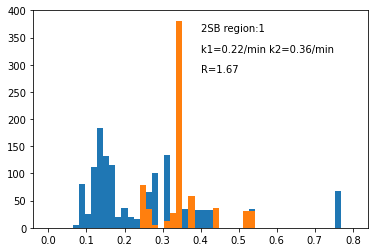

User: andrej studen CSRF: 15fd6d8b78b4383d25d39a8378157e8a
User: andrej studen CSRF: 376babe458d85888051e78cca7c3d073


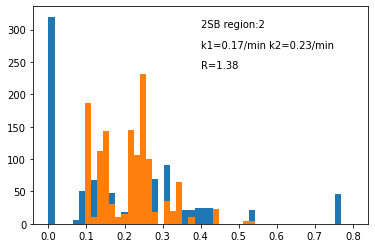

User: andrej studen CSRF: 5722c8602352b0552669a52ceb882218
User: andrej studen CSRF: fb3de1be5ada77b246d4f8c8738b3991


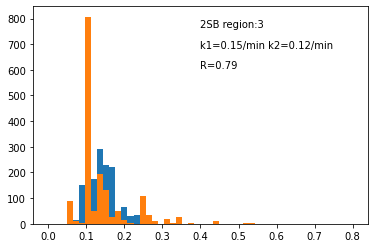

User: andrej studen CSRF: 23553ee85459897c2f2e23564100c6cf
User: andrej studen CSRF: a3701b58f7313ab121eb7897bc9f1a1f


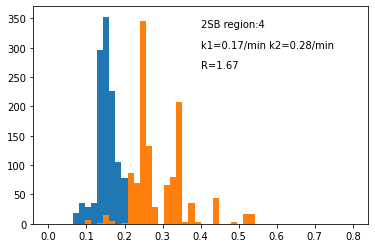

User: andrej studen CSRF: 4074ab98d101b5f5293443e01304a687
User: andrej studen CSRF: f0663007ec24241a2b3d995636233697


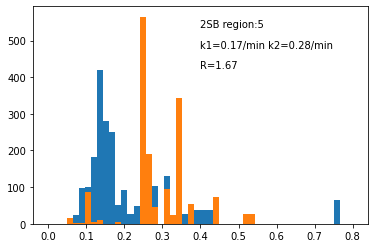

User: andrej studen CSRF: 312bd46be507563695a04e2774621366
User: andrej studen CSRF: 87063f0afd1bcdc962fd186be9c6a1aa


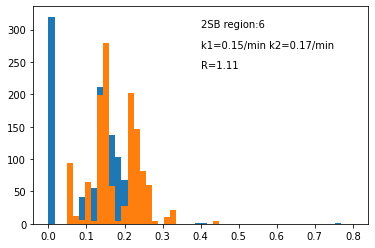

User: andrej studen CSRF: 41d317684bbfeffdac49cac793551fed
User: andrej studen CSRF: d2d453eed445e527101febc389937178


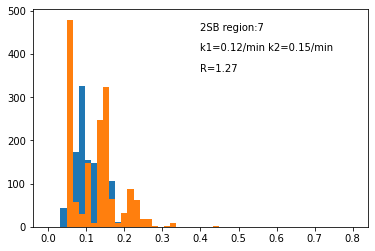

User: andrej studen CSRF: 96ac2cf3984f221a955702187eddcc53
User: andrej studen CSRF: b329a4c907b286ee7c0829163f616f02


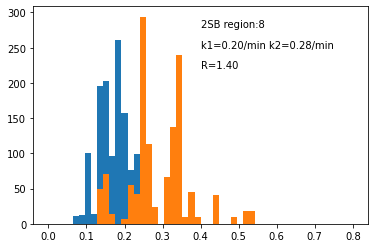

User: andrej studen CSRF: 4695fb2538023c13f6c18c2a70a5247f
User: andrej studen CSRF: b5c1a0ea2eb70eed8b129bd7b1b8301f


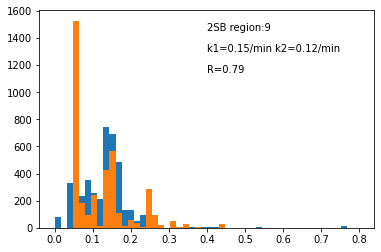

User: andrej studen CSRF: 724d4aa99524e490180baae5f3ab7611
User: andrej studen CSRF: 9c252a6ecdf165801b03168621e044b0


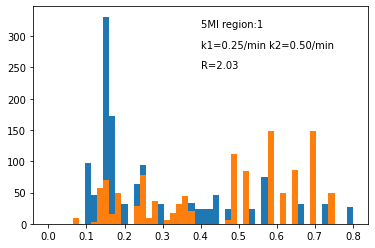

User: andrej studen CSRF: ee5054a280396e1dceacf10afab9ad3b
User: andrej studen CSRF: a7dd618799bf3a683d92714e3dc7463b


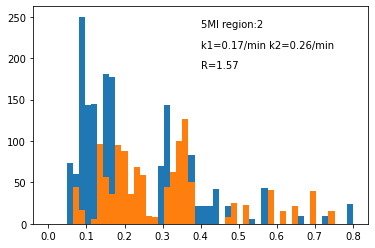

User: andrej studen CSRF: d9725db7a5c0fc4c7c413bb1b359edd0
User: andrej studen CSRF: 5dd2ce093e262bf975132375a589cbd4


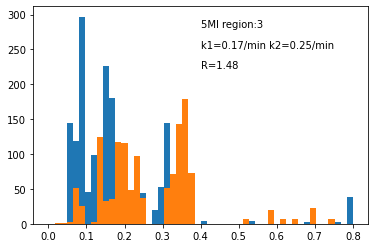

User: andrej studen CSRF: bb385baefe05e88dd0b7fb13a0db51cc
User: andrej studen CSRF: fa5892bf9f650fb533855ebbeee41aa7


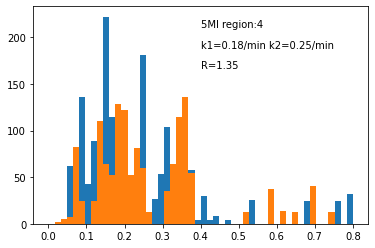

User: andrej studen CSRF: 21d6839f370122020a7d595c8db11203
User: andrej studen CSRF: 98163020ec92ec31405967fa1a398836


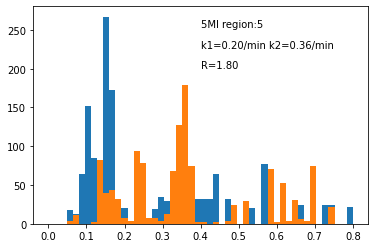

User: andrej studen CSRF: 1a9933be769f625fb49fa03beb427516
User: andrej studen CSRF: f7e9fb3b0901bbcf4dae65960b72787e


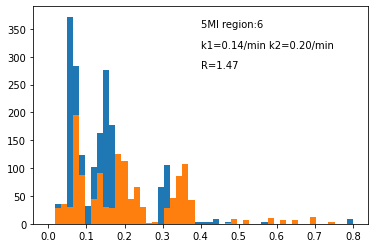

User: andrej studen CSRF: dd6d59aef80f70e971c2b8a624f9a0a2
User: andrej studen CSRF: dfe42e36dddf7341d8fb9a7bec38cc9d


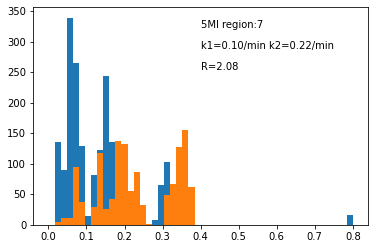

User: andrej studen CSRF: 854838288cc763a421b10c3e216d0205
User: andrej studen CSRF: c1e463952820e25334f37d198f8d6d3f


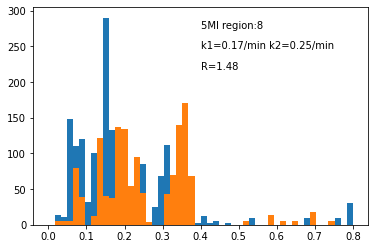

User: andrej studen CSRF: d39ae99427247b78168685c6ea755c8f
User: andrej studen CSRF: 66eaacfadf2969b35457a9ee2a6744c4


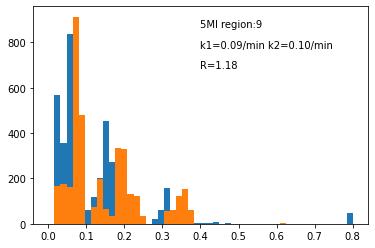

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 8158934074ab49fd9418dbe294c688cd
User: andrej studen CSRF: 737a1330f68b8422ff104b77c7b4323e


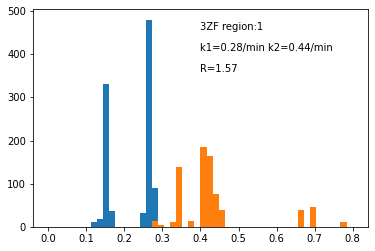

User: andrej studen CSRF: 4af906db9dd65baf34ccea8aad56d4b1
User: andrej studen CSRF: 96ea1b8dd39f39d1a5531996460f3fe3


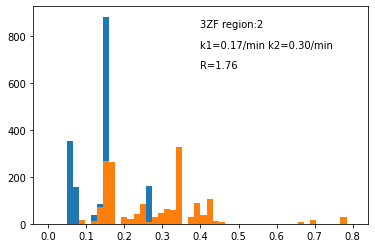

User: andrej studen CSRF: c4c0ce33cdf8e8875ee0251ba8501af6
User: andrej studen CSRF: 21a8755c93cce0dcf7cd7f325f23a28f


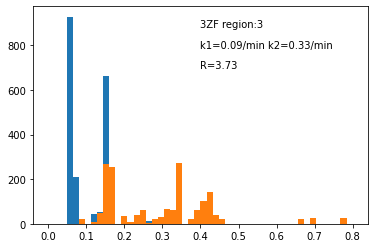

User: andrej studen CSRF: f140d5fd0ec19cdaaa37864ed2cad803
User: andrej studen CSRF: d0bb2fae3f67c14d1ca567583aec2f11


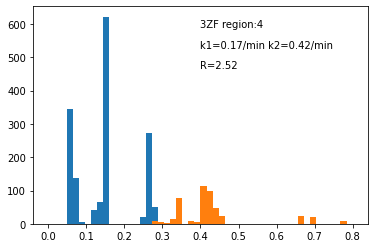

User: andrej studen CSRF: 5566f37fdb63e19d031d087b88f3b545
User: andrej studen CSRF: d400e169fc831a7fd488677b668a1d71


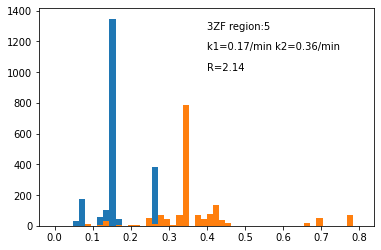

User: andrej studen CSRF: d43979917fb2efa501139bb25aa917f0
User: andrej studen CSRF: 9a6ce3b268ed9ae91858953d11446640


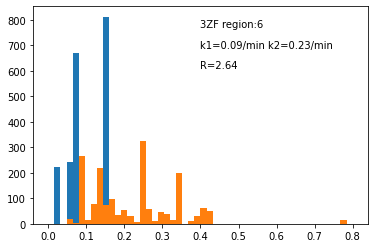

User: andrej studen CSRF: 50c8177c0e34cdb9f1ae02089f84ddb5
User: andrej studen CSRF: 38ac4962a9665f14803d633521a90e0b


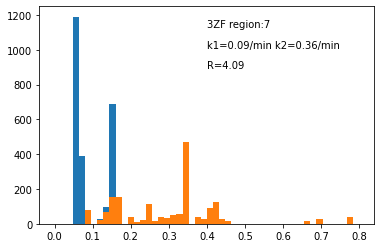

User: andrej studen CSRF: 301c609523b828901bd3b27cc36851a0
User: andrej studen CSRF: 6d6e24c9077e4f74c7eaff13445266da


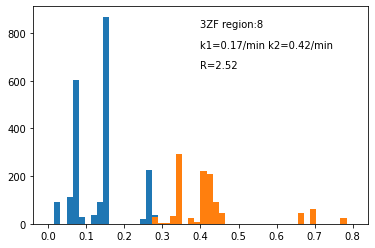

User: andrej studen CSRF: 1192f34dd9cacd97f51bd9db2aa4bee7
User: andrej studen CSRF: 7721ccc180c882df562c9e8608e7d4f3


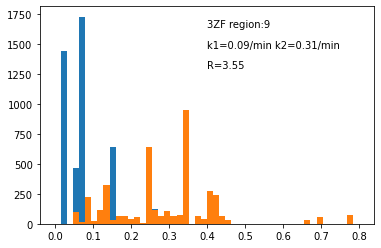

User: andrej studen CSRF: b2fcee6aad5992bf83fbe4ae0486f6a7
User: andrej studen CSRF: dc011f1c59908d11161ca2704275d085


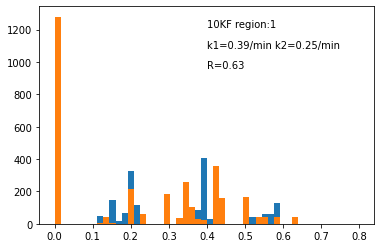

User: andrej studen CSRF: cf316729e2969ac00da8952069d49c17
User: andrej studen CSRF: 5369716cd4e6671637c319b32e36b9a7


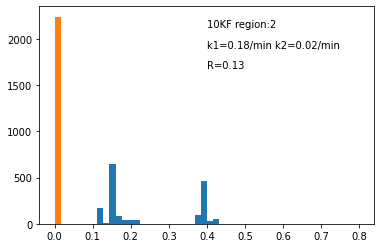

User: andrej studen CSRF: 6a7775af026ecd6f71f9e39e65f3efee
User: andrej studen CSRF: fe52acd07a1924938e9b1582fc2dcbed


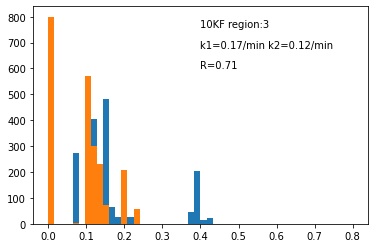

User: andrej studen CSRF: 97bbe2f6b68fe4c8e49d4d0ffd04b659
User: andrej studen CSRF: 55de634665284de68b322f35939d6b5e


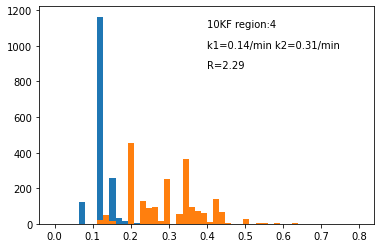

User: andrej studen CSRF: a41ccc39b4def1396f77ef8fead145e9
User: andrej studen CSRF: 1487cac5dfdb4f567ded8877347b1d8e


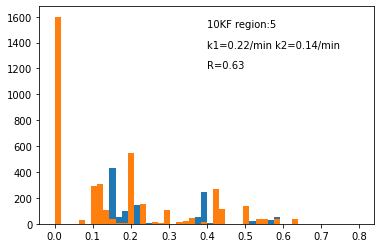

User: andrej studen CSRF: 08cc72ef3cbcd1c5fae137d5bc230c1b
User: andrej studen CSRF: 1bfa830d1df3aa956c78eba60bc1c8db


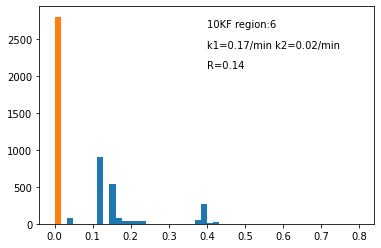

User: andrej studen CSRF: 6e52d06ccbcecbed54a705401764e10f
User: andrej studen CSRF: be47cd9a17e77de587ac3ecb819a31fc


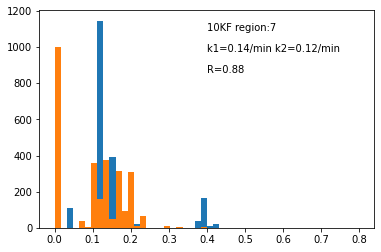

User: andrej studen CSRF: f6c5fa50a4f93bb8b85ca73f63807632
User: andrej studen CSRF: c0a8ed9d73ea57c4f477242ecff70731


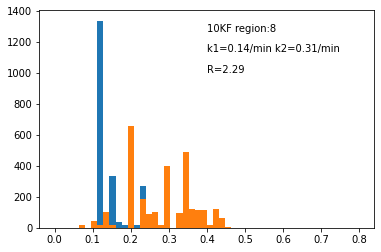

User: andrej studen CSRF: eabe5d5a8ea67fea85eca2dce0c69dfe
User: andrej studen CSRF: 8b3fabe5fc033cc0d7aef9ee21c25f56


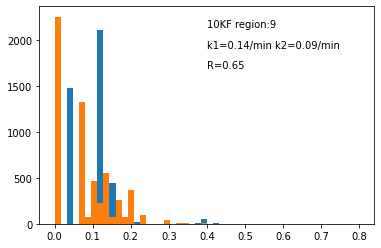

User: andrej studen CSRF: daf5614060abe6bdb9c2dd8755edf162
User: andrej studen CSRF: 23060980ba3a881163edaa9bdad5675b


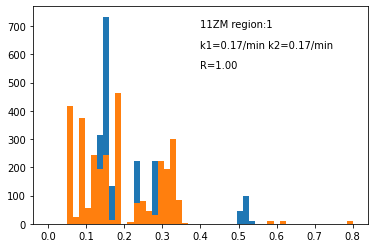

User: andrej studen CSRF: 46c38eb0442c45c5768a93e07156d25a


/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 55f970adfd8812c0f2731497284faaf3


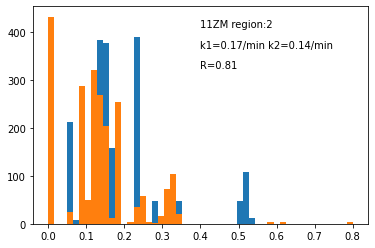

User: andrej studen CSRF: b372f1b11a94b27dd2279f1f42614678
User: andrej studen CSRF: f9e6deaa46be3c34e62283320bc69c52


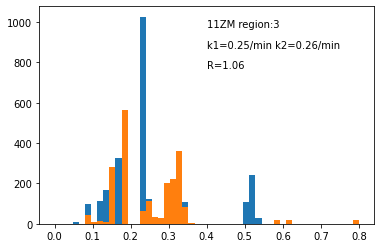

User: andrej studen CSRF: 92d7c3db9f01c06c3678453fe7e7c3c6
User: andrej studen CSRF: b9a9effe4eaa610b3912dde658537002


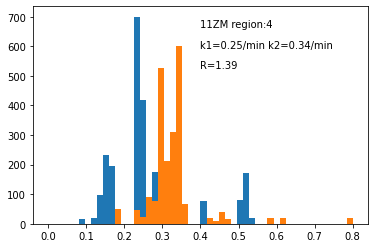

User: andrej studen CSRF: 02d795a85bed64826cb6c2e75a237277
User: andrej studen CSRF: 3d552e2b75a7057820dfb0dd3b8ebbdf


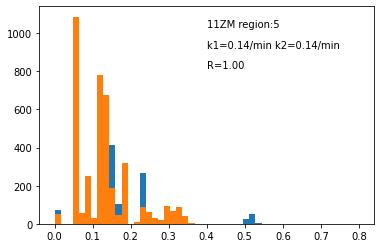

User: andrej studen CSRF: 955179ee68a84f6793b1a86e1c746299
User: andrej studen CSRF: 1e44226a181be441beda2e4f6d54479f


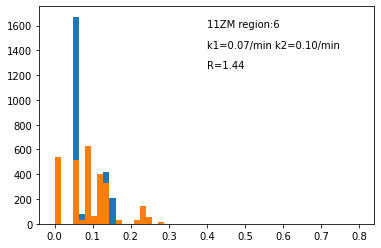

User: andrej studen CSRF: 6794f90960815fc2ef4e9ecb4e033f26
User: andrej studen CSRF: d7b08b591439eca3a48c92953b3903b3


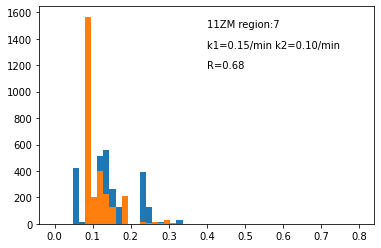

User: andrej studen CSRF: 505b4842cdeeb8ebbc3b14a0827636c0
User: andrej studen CSRF: 9d2d25ed6d84d2d6fed7bb9862d00843


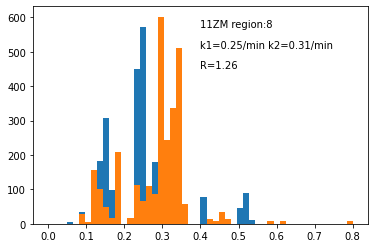

User: andrej studen CSRF: fc25f7ccd8be7183c58fdaf3cae36165
User: andrej studen CSRF: 73d0e95f18a2a352570ec9576182c261


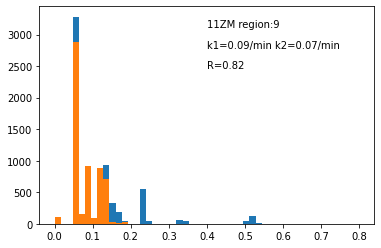

User: andrej studen CSRF: c960e5cd9beed207f076df4be8a1fdf0
User: andrej studen CSRF: 884efe173c592a6bc1b7cf08bb084094


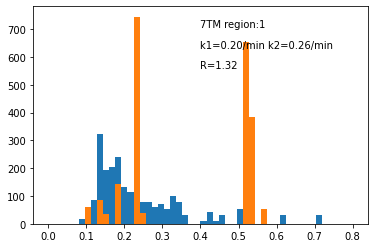

User: andrej studen CSRF: 59a89dfbaea869d8978c789a23434137
User: andrej studen CSRF: 840b59768ced33be634ed2a1ed442eb2


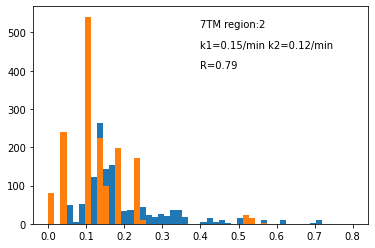

User: andrej studen CSRF: dfab887eab47da331a9641190c22a443
User: andrej studen CSRF: 5c40d09ae9c9a0aa1d4583ea42787b88


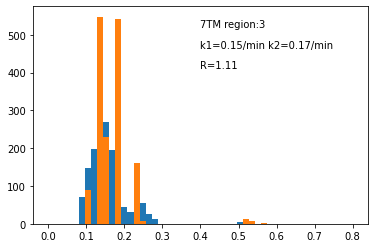

User: andrej studen CSRF: 2c530448278c13d14c44fbaf8c9e8f90
User: andrej studen CSRF: cad8148c9db288e883176c7c0a726aa9


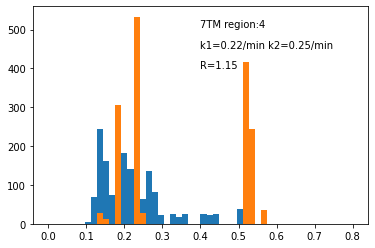

User: andrej studen CSRF: e9119bf08b0a980f46db712fc0a9fcb9
User: andrej studen CSRF: ccf8aea4b08a97e6a24fd68b9f29bb4a


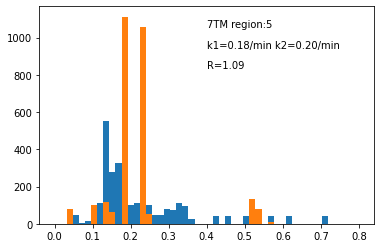

User: andrej studen CSRF: 02ad32ca59f4cb8bd882418592afa93c
User: andrej studen CSRF: 7120b334bf36c088b4510697fa3ba5a3


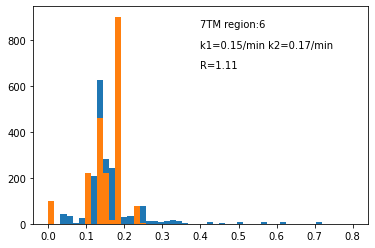

User: andrej studen CSRF: 2b9abd5c024265bb95fe020d3566249f
User: andrej studen CSRF: e4d6814dd8af2e721902cf6935467d3f


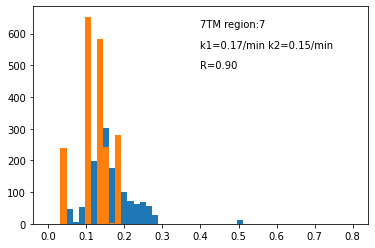

User: andrej studen CSRF: 76af52ea36bf413e4c0130cd7c85a6e9
User: andrej studen CSRF: b747f50239bdd487b3e47915866cc79d


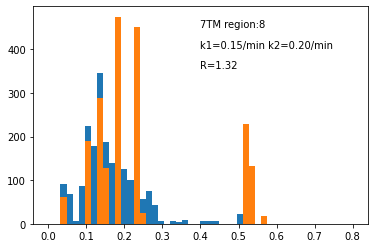

User: andrej studen CSRF: ceef61cbe4c489e5a6fd030196d8ae0c
User: andrej studen CSRF: 58cf5f4933a12d8c4bd5e02f1ea157ff


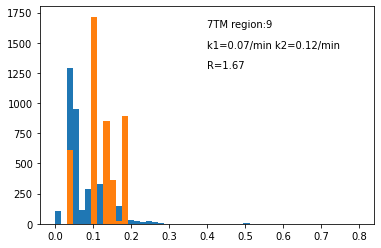

User: andrej studen CSRF: cb749d44cfae973574a3b753cfe74182
User: andrej studen CSRF: 8ace48760caa4d444e8e601c47ea20f3


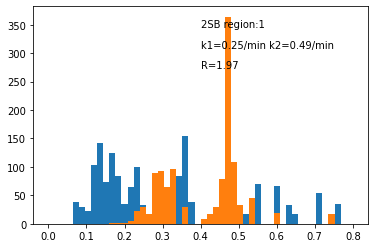

User: andrej studen CSRF: 2848128ae431fc534ee1f20792232c37
User: andrej studen CSRF: 533ef9b29661587409db5773b9cba18b


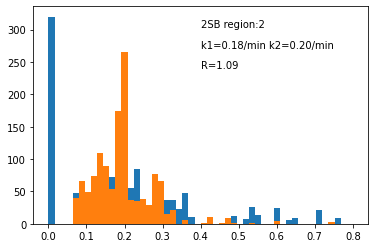

User: andrej studen CSRF: 4d7208ebba2f630011089075baa447ba


/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: e9c62c81649710002acc67ee707a28e3


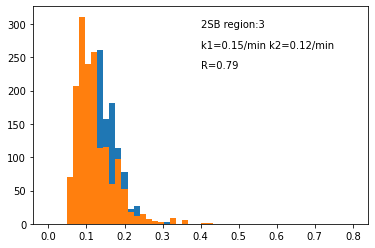

User: andrej studen CSRF: 9896e7e9196902e1a6f75caeea0c413c
User: andrej studen CSRF: 54cc50a2d2ebee1bf833efe0a0034685


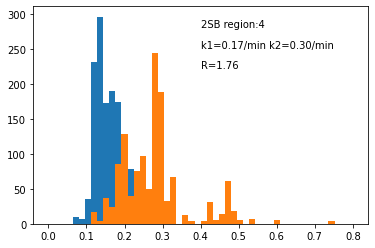

User: andrej studen CSRF: 31a05bcc934f4815a461390fed423e2d
User: andrej studen CSRF: 78085c4ae06d99a3bf9cffe65e54f771


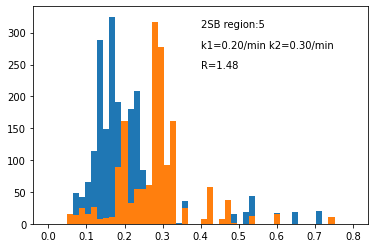

User: andrej studen CSRF: 09a0c6c6de55fd5545b78cfb06e72c63
User: andrej studen CSRF: c7c71e60648bebbe28b18da65c3847aa


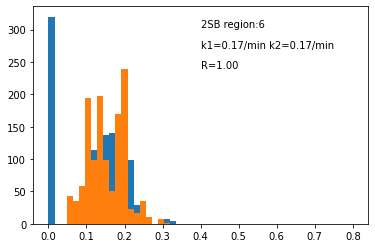

User: andrej studen CSRF: 92acdbb074bafd0a55ad4d986d5413a1
User: andrej studen CSRF: ebc36ccd4f61d0a800918a2791025bce


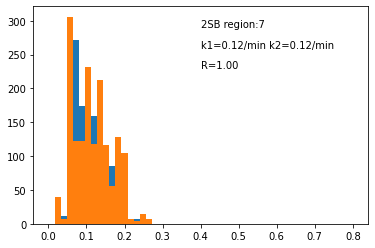

User: andrej studen CSRF: 49c4316569e92b3d6b884ade419e5d70
User: andrej studen CSRF: c3f9268b276358a46dc8007a5cb1084d


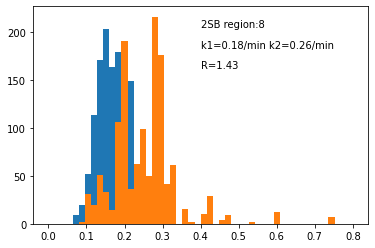

User: andrej studen CSRF: 774ca4fc8c83deefe454e7c10a168c50
User: andrej studen CSRF: 5becffa97d0a2f66537fa6b1d511bd82


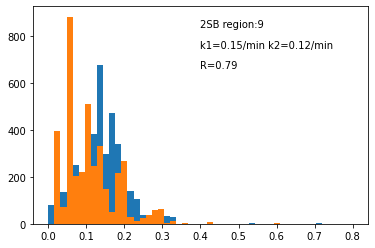

User: andrej studen CSRF: 289a9847b9546cb8713035243565ee0e
User: andrej studen CSRF: a4624b5715ffe6b85740fc0e47a9c4a5


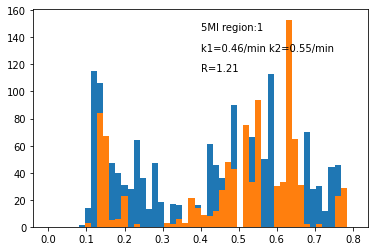

User: andrej studen CSRF: de90e0580b49c6e3dc2878eec3a0fa8e
User: andrej studen CSRF: 31f1e122afcf7dd74026f8caaa8c6679


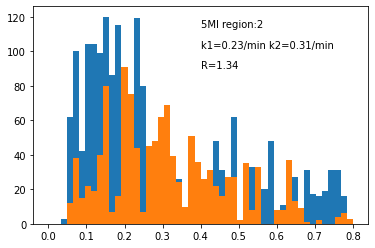

User: andrej studen CSRF: 65f2633578e7271524ff9213af86781a
User: andrej studen CSRF: d6c7e2e2696e55b3348a3bfd3b4318eb


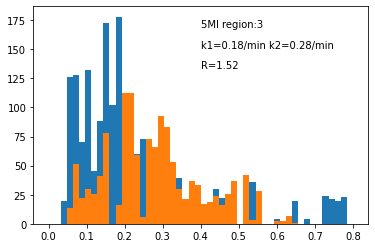

User: andrej studen CSRF: 0f43c1e045ed126055f70967ffd47c25
User: andrej studen CSRF: 53c14b8eb49ee6e0a7eb4e8e536df658


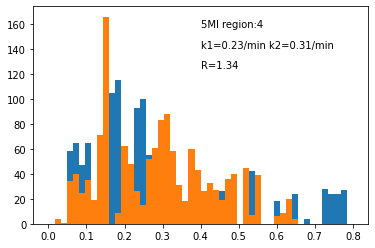

User: andrej studen CSRF: 01fc8381d5909e5b136860379615cffb
User: andrej studen CSRF: bee4c93d6ef68f26b56e61a6cd45c678


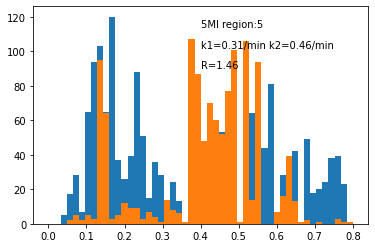

User: andrej studen CSRF: c94e12de79b3825d048c17fad229492a
User: andrej studen CSRF: 6de4704b559ad4de2fff910f1db29f6e


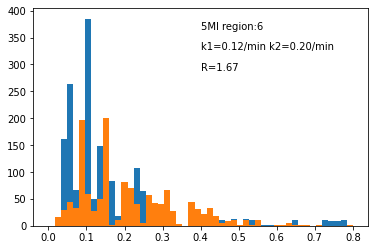

User: andrej studen CSRF: bc815fbc4a584818e589f82587a5dcc6
User: andrej studen CSRF: 13c328dc39deddafa85bd00c528e85ed


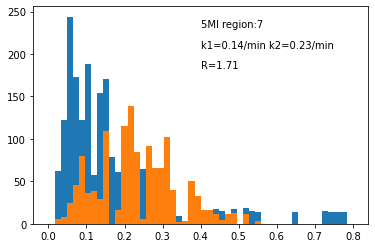

User: andrej studen CSRF: 750dbc41c255a6e36ca21e24eb650634
User: andrej studen CSRF: 99c09440adbbc065df6f7af8ced2c33a


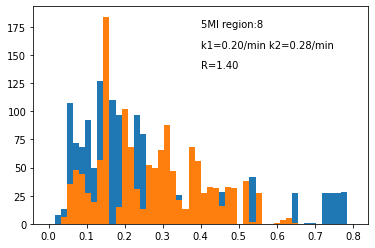

User: andrej studen CSRF: 2f94105555870528709e2482fa26f589
User: andrej studen CSRF: 9b9a6d8d792b158995249cab03866dc9


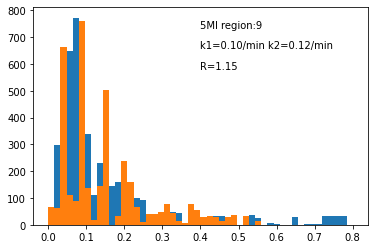

User: andrej studen CSRF: 452d69ca623d7819cde23b0f8a9e28e2
User: andrej studen CSRF: 89ccc7bc23098e7541b948b1f76eb02b


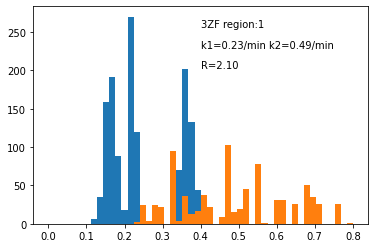

User: andrej studen CSRF: 4bccec8ae2eb2d768040586e89152184
User: andrej studen CSRF: ffc38a1799918294b931538d5788ea82


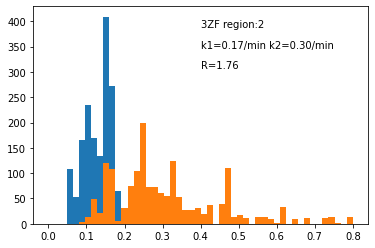

User: andrej studen CSRF: 2ded5c0034fd5090e10cd6b9d3b57ae7
User: andrej studen CSRF: 843e53c1383be7ca90cb34378fc649d2


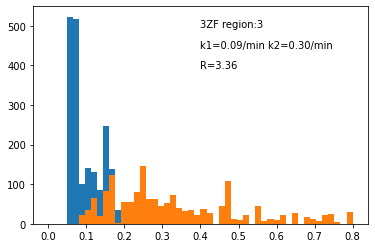

User: andrej studen CSRF: df73cc6639da3e6c092bbe5a1c2343f2


/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: ce874d0b4208b9494145107867da0e2f


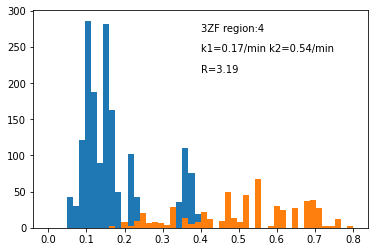

User: andrej studen CSRF: ad592421a2a24df98920b27e802672dc
User: andrej studen CSRF: 51b87258da9c6983fb4cc3b781079bf1


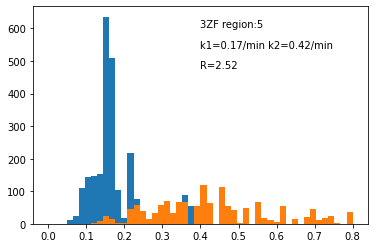

User: andrej studen CSRF: c336bfe3fb4e3d8cc937f6c7ddf3bc59
User: andrej studen CSRF: d28eef61721ca5e967e09f8ac019ed88


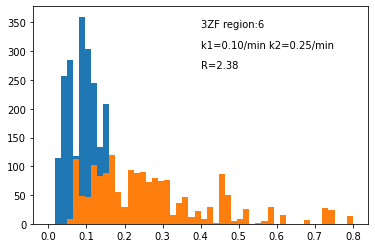

User: andrej studen CSRF: 6071b5072dcbd1347a4fdecfce35e72b
User: andrej studen CSRF: a2850542654d0e107e1d88d4e5af262d


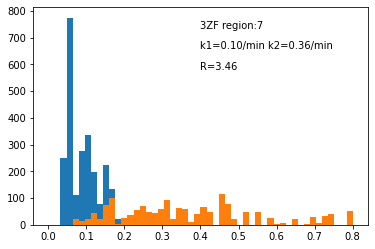

User: andrej studen CSRF: 98309fa346cfccbb480d3ea7c6152a4b
User: andrej studen CSRF: 981b66a17144ef51ab3fa478b378daa9


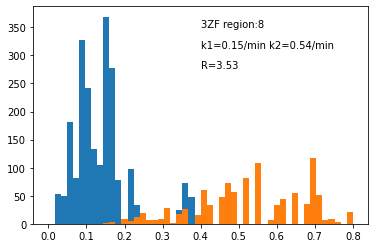

User: andrej studen CSRF: af81106a739ab24fc2fa781cf6f4b530
User: andrej studen CSRF: d1ad0123d63fa037d97cfb990451ed37


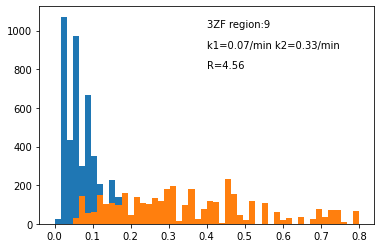

User: andrej studen CSRF: 3c67fa8903b59783086a49c5ccd19e80
User: andrej studen CSRF: 2d2493caa81341053d04bec388365ccf


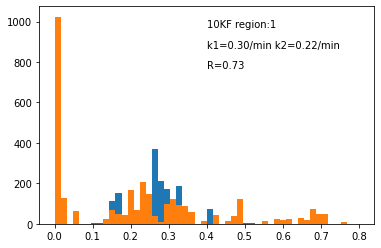

User: andrej studen CSRF: a588814a4c60cd86a835f380f4739237
User: andrej studen CSRF: bef1b134e25238a176ffbee50a4847b7


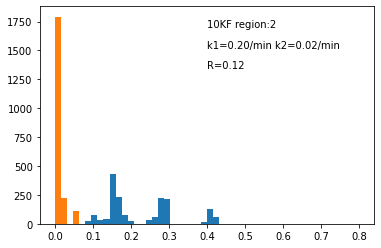

User: andrej studen CSRF: 559cf0cb8d8f7522007d6fa556293ff4
User: andrej studen CSRF: 84bd2d4d00a872246bfc1a586edb7368


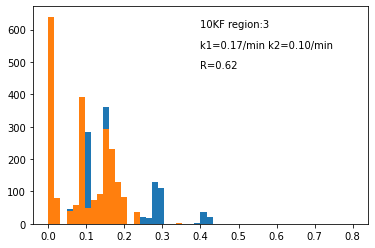

User: andrej studen CSRF: 90701a868842232774cc75e6a80338c0
User: andrej studen CSRF: 6b1fd2bc5ed6ed74ef34b952317cf6b4


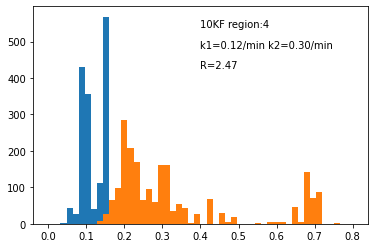

User: andrej studen CSRF: a84dd118fa02444f33fbd3556b1974e7
User: andrej studen CSRF: f40e87ab4e724754e162fce6f8a7d033


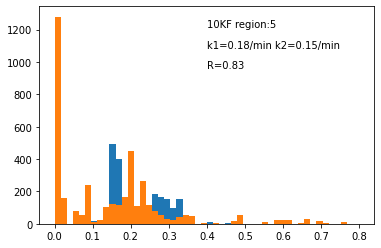

User: andrej studen CSRF: 8660cecef579a92370563d4751e30879
User: andrej studen CSRF: 58dcefa6693799706dd805fc25b7c933


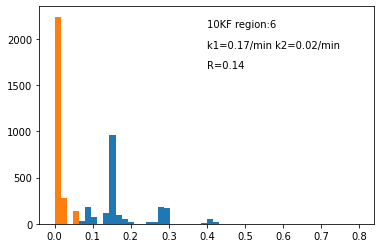

User: andrej studen CSRF: 4157ae317cdcba59d9758719d32a90aa
User: andrej studen CSRF: 2dcbc527a490d574fdc078e9986a440f


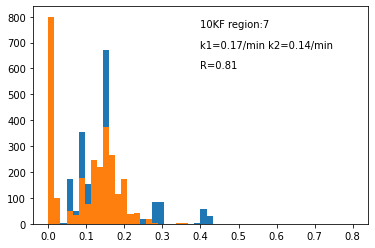

User: andrej studen CSRF: 10c582d7efd523f6b9edd02284d66aa2
User: andrej studen CSRF: 8a350eab93b434fc634ed2fcf2c96a59


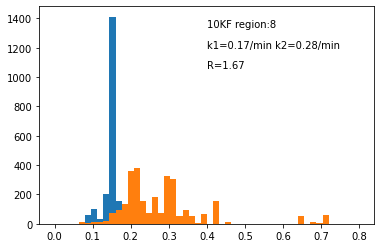

User: andrej studen CSRF: 9f9b76146b287d152ad191a0e169a1e3
User: andrej studen CSRF: 03800b56747911c86041909adcc1636d


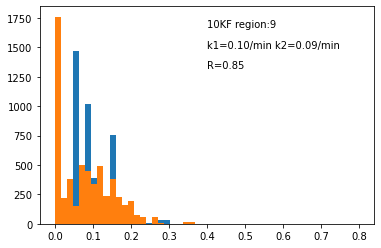

User: andrej studen CSRF: d1c2465323fb9db9bd688345eeedf099
User: andrej studen CSRF: fa4511e4c8544f1a802e47554bef7eeb


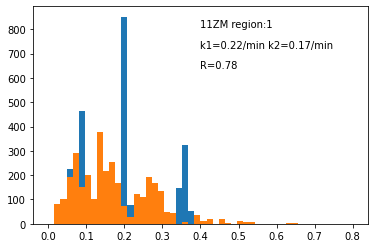

User: andrej studen CSRF: 10a3058c947103c697375d6aa63f7c52
User: andrej studen CSRF: e60cb5362d70a3ea94e8e01b0c2c1070


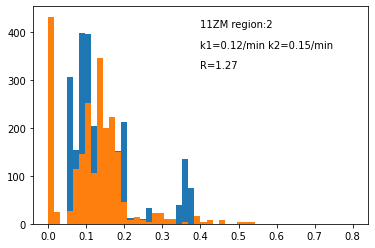

User: andrej studen CSRF: 4a53aae05c4e812175f8611efbbef3a3
User: andrej studen CSRF: 1fe5c09d97634cfaa88e6a66785ec275


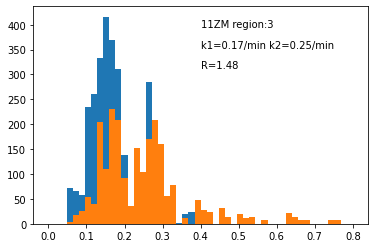

User: andrej studen CSRF: b9020b7c7b33ec178414e2c83d9df4aa
User: andrej studen CSRF: 6866abf2f781f6feefe4562a8db47cb3


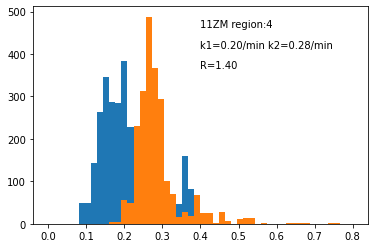

User: andrej studen CSRF: 95a91bd15d2f7d729c6119b2db047f27


/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: e73cbc432b174a13fe5425017ea20ec5


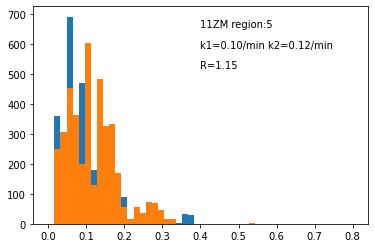

User: andrej studen CSRF: 52d87b8e71ec4c5991ab997513eca9bb
User: andrej studen CSRF: 5243614dece02db262b2791f49dff83e


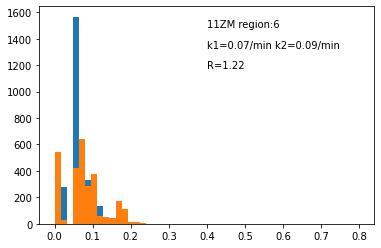

User: andrej studen CSRF: 7cae67f3e08b746e1d89616c043ae363
User: andrej studen CSRF: 1bd17341a8d7bb439c8f40dd22ababa1


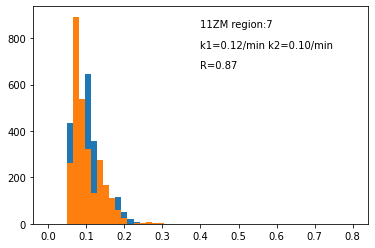

User: andrej studen CSRF: 1e0095734b13fcfc5fe071669bdd54d6
User: andrej studen CSRF: de2dc484ad0a079db6045fce41fdf6e8


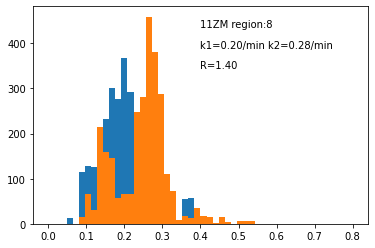

User: andrej studen CSRF: 79c4d32b2946ea15463aa748ecda550b
User: andrej studen CSRF: 914ecf48d3d2ca755fc983cc16096ca2


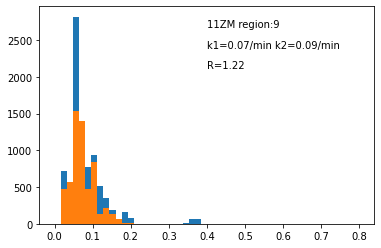

User: andrej studen CSRF: e7ec7d700b8016880aedec178e9bf6af
User: andrej studen CSRF: 33fef38f5c37ded9770a7fc273e18a0a


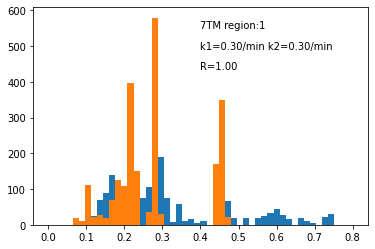

User: andrej studen CSRF: 25e8a2d6e010b5963f02cf9057a8d27f
User: andrej studen CSRF: 1edd82cda4ed9b74b95bfcb380ead599


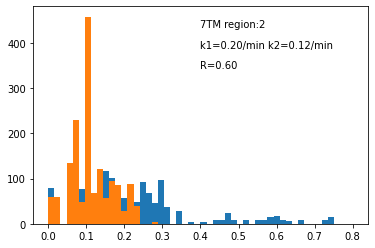

User: andrej studen CSRF: 1ff11dc427fab2734b22bce23a226da3
User: andrej studen CSRF: f5d3072b71fb726542f0543d90f1aa50


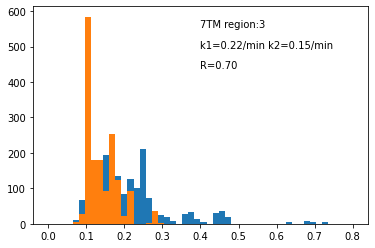

User: andrej studen CSRF: dfdeed9ef6a73dfc7406629f2236eb6f
User: andrej studen CSRF: 1dbe6c46cc0e756fcf5a1deb2f5ecfc7


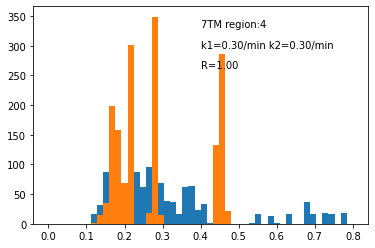

User: andrej studen CSRF: f6778d1c2cf42a1f0175a6e7f112d613
User: andrej studen CSRF: 21f443917b3d2ae1b1ff0500d63f4f8b


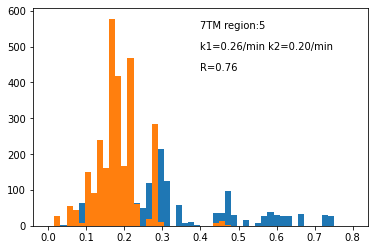

User: andrej studen CSRF: a672545ee6ae2738480014497543b199
User: andrej studen CSRF: eb52c13ac485092732e480eb7ff789f2


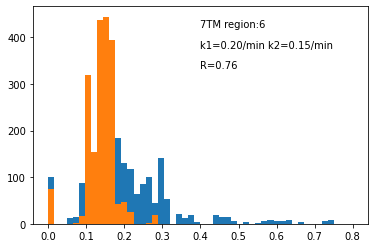

User: andrej studen CSRF: d08baa6586a4c6b1843cd0c5e678fd3f
User: andrej studen CSRF: 7ecbd152f432dcbf23a6f268defa2a68


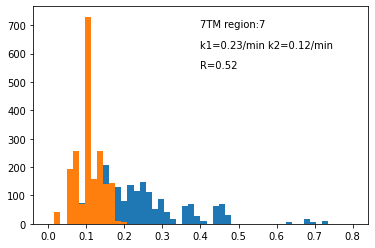

User: andrej studen CSRF: b9972b8811f698979be36597f04088e3
User: andrej studen CSRF: f45c22f5772d30a739657628818e6824


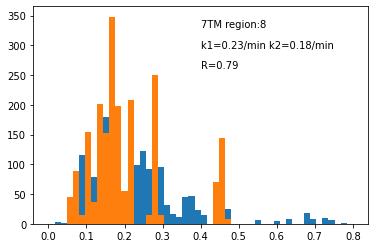

User: andrej studen CSRF: b4883a9cc27478798a68746a18f1cbb9
User: andrej studen CSRF: 9ed25959edafb852439e3bcec5b7f936


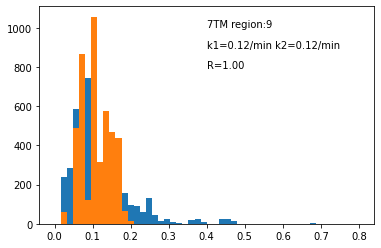

User: andrej studen CSRF: 6aed1208305bccd9c56726f375d49b43
User: andrej studen CSRF: f1acbdd535940d325fe8e051302f31ea


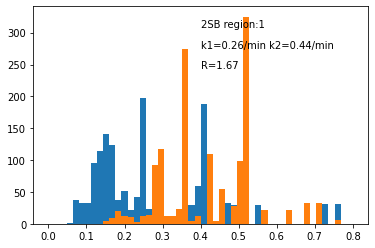

User: andrej studen CSRF: 8fb353b19e6d7e9ee403fbea812ba317
User: andrej studen CSRF: cb2d4f7c343918611b3c85b184f0d390


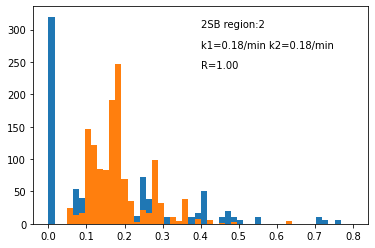

User: andrej studen CSRF: 055e3ca8c1e270f871870fb7df750bc9
User: andrej studen CSRF: 6ce1dcff5db0c55cb986006e62d848dc


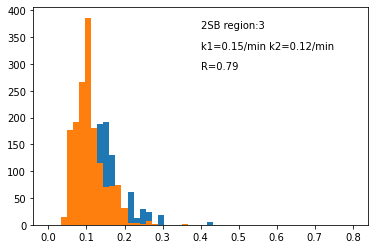

User: andrej studen CSRF: 3ad316b332e960980f487119c777589e
User: andrej studen CSRF: 121c1b14327004af8389b24dfb1a5079


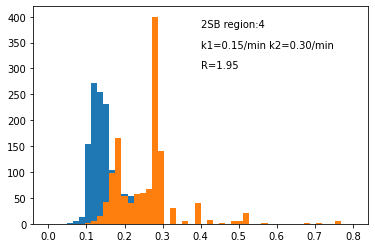

User: andrej studen CSRF: 183689de6b46e0c6901e8010ea86c548
User: andrej studen CSRF: 4f7095ee2d8e2c45a7c19685a2f1a323


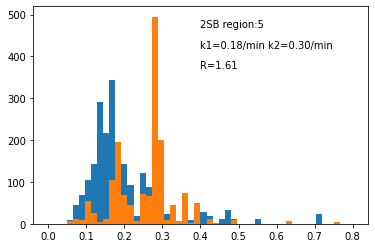

User: andrej studen CSRF: e52146fdb291f159ed1e0bda3dcb0ca9
User: andrej studen CSRF: bfee2c49cc7af55f5c7bc4949c704c21


/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


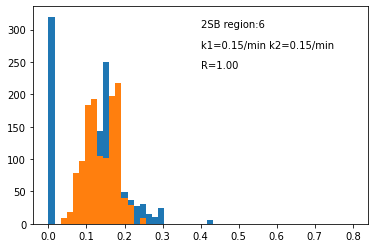

User: andrej studen CSRF: 543bb07d713b9074f28509ae9001d1e5
User: andrej studen CSRF: da2bcd78cecb8dc9d11e0f5af11201bf


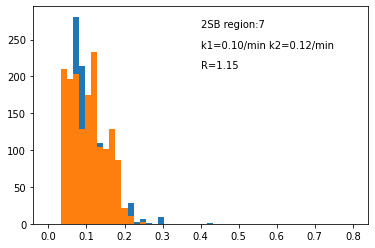

User: andrej studen CSRF: 2095d598dcf09951f6f044bbb7236c90
User: andrej studen CSRF: 61c26fe71f6c5311adcbb6ac18f46af5


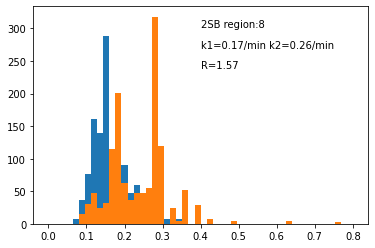

User: andrej studen CSRF: d93fcacc1ae71ed1961fc665964f63d3
User: andrej studen CSRF: a0b5e6511ae1765107a6d93b2686a1a0


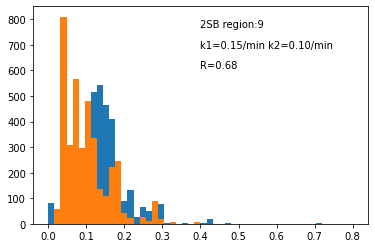

User: andrej studen CSRF: 3d7e32f43be10726ee1c6f93f540c77c
User: andrej studen CSRF: a57b9698fd591c0dc96abd8af8e8f36f


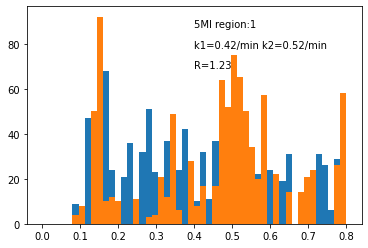

User: andrej studen CSRF: 473bc991ee958eea19925669f44aec0e
User: andrej studen CSRF: 8be12f39e36b73e0e5fff70e2826ed9d


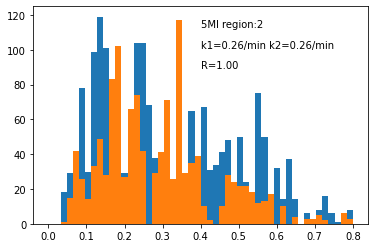

User: andrej studen CSRF: 59f953c3465121f4748024c40003f429
User: andrej studen CSRF: f42ad302e5ff5cc74bbf27430a2056cd


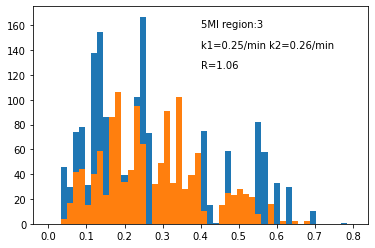

User: andrej studen CSRF: 270d8457001d3f6b978fa3e58c7ca57b
User: andrej studen CSRF: 753a48d8013eaa4416f1d435265cce81


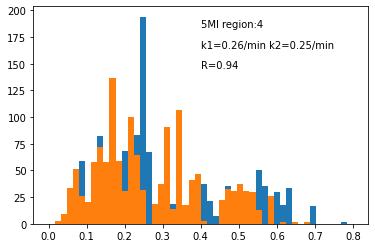

User: andrej studen CSRF: 48a6c4c51db9833c2b01ddeec2deaf30
User: andrej studen CSRF: 96bf992247a5b016efcda99dae1e14bd


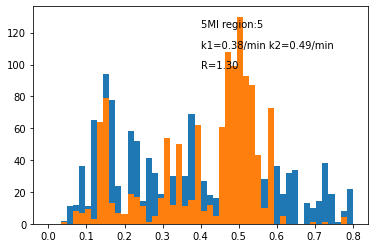

User: andrej studen CSRF: 0bf2e1fce1774810448702bf3bf1bb6f
User: andrej studen CSRF: 1628494ccacdc41dbf5bc48521738b65


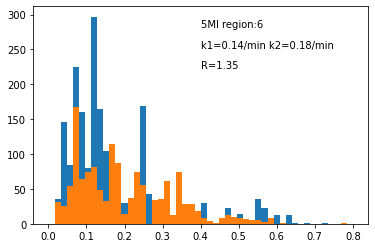

User: andrej studen CSRF: 5289fff35e553354714a64431adc900e
User: andrej studen CSRF: 25bb8686aa30d8e6a0c6c472d931d159


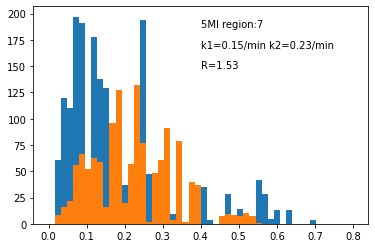

User: andrej studen CSRF: f13add051d545f4921446d7c1aa93e64
User: andrej studen CSRF: cfd99a5bea3aeb152f6466f501776d3c


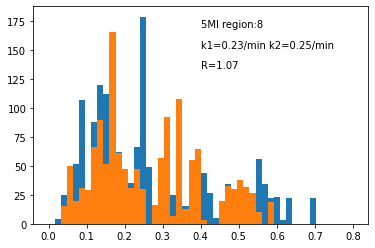

User: andrej studen CSRF: 9f6f87606497ec412c4d824396c0e871
User: andrej studen CSRF: 2120b612582d4211b0d732e3b4ec8c37


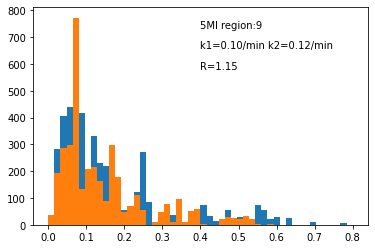

User: andrej studen CSRF: bec97981cc9eedad1cd83c245593f926
User: andrej studen CSRF: 3f2cfb7976800e6818d92005c13c812f


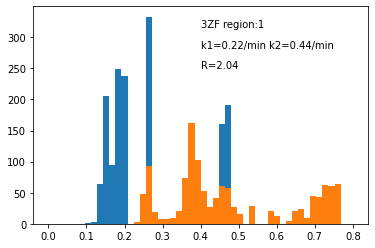

User: andrej studen CSRF: 4712c7501f8d04727f2058970635c520
User: andrej studen CSRF: ffca23a730a561a9bf3f8a6c6dbea3d7


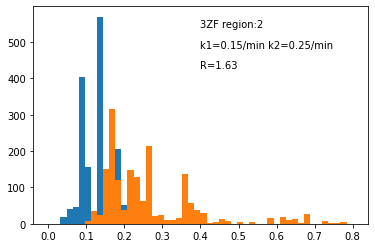

User: andrej studen CSRF: f22e63c5782a1b357fd8ef48edcd91a1
User: andrej studen CSRF: 4f2c3c2b185c45f8f8883726c382ebb2


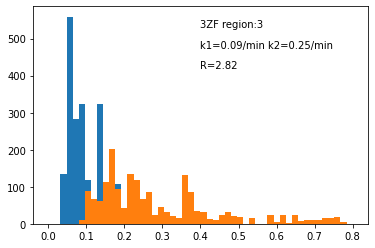

User: andrej studen CSRF: cc50e35251196c19e4e80904838898a2
User: andrej studen CSRF: 2598fa31486ee91a73356938eff7689b


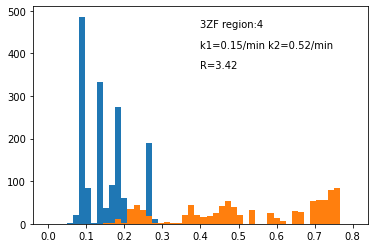

User: andrej studen CSRF: 9288398da4d192e27419e8010bbc0053
User: andrej studen CSRF: 0a7a11c15e1da6db1771d3b07d6d9ad5


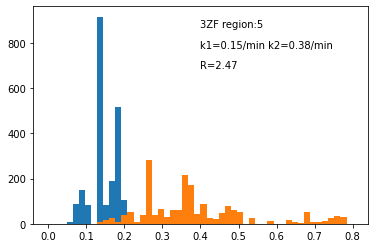

User: andrej studen CSRF: 61eb7dc3d8462637a258ec02fc6b6b3a
User: andrej studen CSRF: 2fba340a95e051ff1b4e7a826a876195


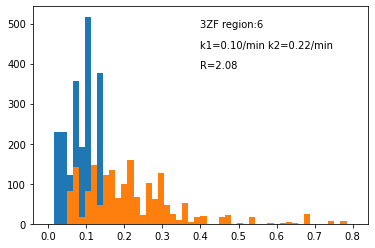

User: andrej studen CSRF: e3d4236b9927cf568bdc1552f0b8c1e0


/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 791841abb6717bd6feaa5d242910ee6e


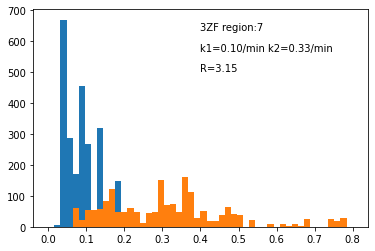

User: andrej studen CSRF: d51700bca768b37469a623e63630856e
User: andrej studen CSRF: aa7f3ed1ae0c3f4f219e08e66d42f46f


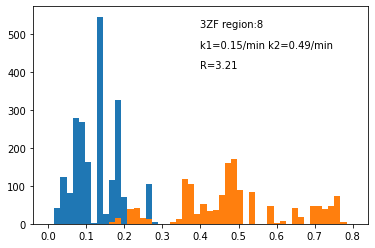

User: andrej studen CSRF: 2812ee4fdb6ccf21faf61c1882c679a3
User: andrej studen CSRF: d40f061526392c71ae1e034f0519a416


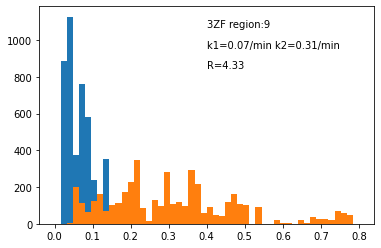

User: andrej studen CSRF: d4fe99ba62e1142a152eb0fcdf3dba29
User: andrej studen CSRF: a725301c8d2d9ac1f2879ada0ee58f1e


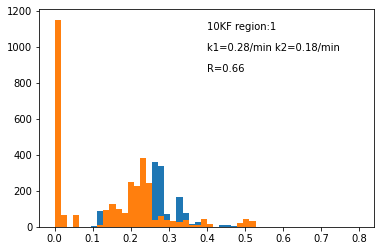

User: andrej studen CSRF: 2f9b69103a20ec11b684f6bee60346ef
User: andrej studen CSRF: aeb920748cd0c3b35bb3ad9d967fbba5


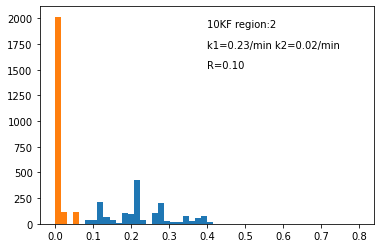

User: andrej studen CSRF: aa15e71aca21867751285f6b60e849df
User: andrej studen CSRF: a6033b5b47d441da8cd85abafee7f57a


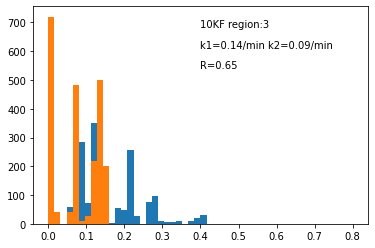

User: andrej studen CSRF: 91beb9cc3d526e858defab2b0a26c6aa
User: andrej studen CSRF: ae0384a867f7f056eb85f15d8c536eae


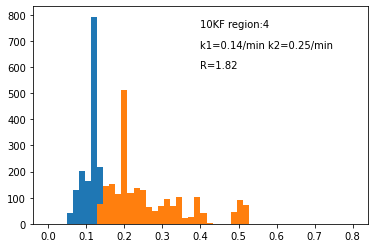

User: andrej studen CSRF: 90045286b87f9642783f4d212a6087e9
User: andrej studen CSRF: a431ec7494cb50413f3a2ca8bf7fdf68


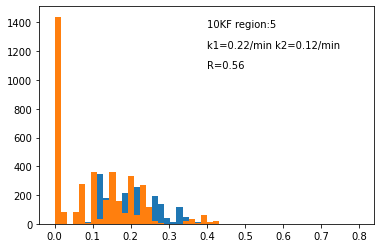

User: andrej studen CSRF: ada5f792b2526c0b51a94995e63368c6
User: andrej studen CSRF: 8b181268fbfd8279100a662a38d277cf


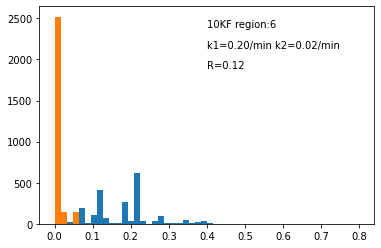

User: andrej studen CSRF: ad258bedb21a9608e0d060d8a8791825
User: andrej studen CSRF: 75dec0d4afe85670a5ab799cf5bae80a


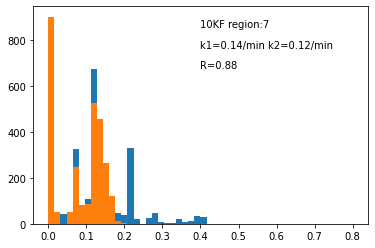

User: andrej studen CSRF: 23d4be5bdf4cf74e73f2f0ab316ab474
User: andrej studen CSRF: 6ede1fba063522277a53be9260744eff


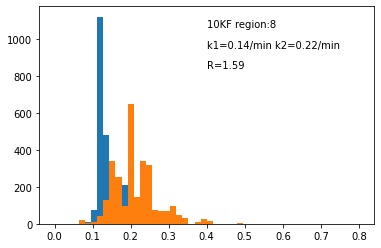

User: andrej studen CSRF: 2415b13bb9f54b7b56db104ebb31cfaf
User: andrej studen CSRF: 76b3f3bd1633ba4621a92bc8d8edcd67


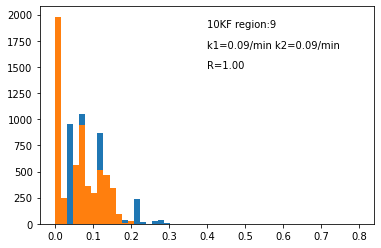

User: andrej studen CSRF: 930f36451e6a6a5c6937eaa23827430e
User: andrej studen CSRF: 434e8ee695d82a8ef1d328f664e749b4


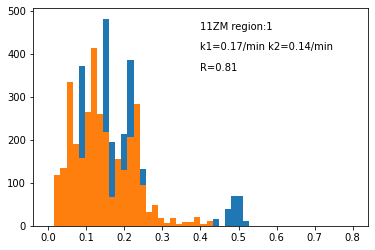

User: andrej studen CSRF: a311bd92d47bdccb8449cc429e954d3a
User: andrej studen CSRF: a7aae6d9d2c8c43d3f3fb2309894c55b


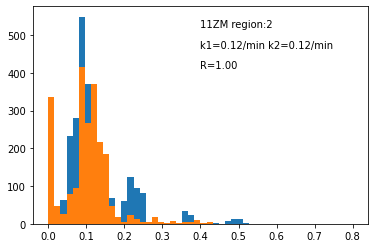

User: andrej studen CSRF: e74c64e17c99b97e5db9ddcd7b7321d9
User: andrej studen CSRF: bc9c8e06b88831bce65978d46dbba8ff


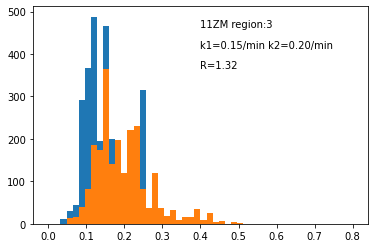

User: andrej studen CSRF: 2d5786f8c72fad1d972955577ed71d53
User: andrej studen CSRF: 84b50779f09d305f3ce0a13cfd320419


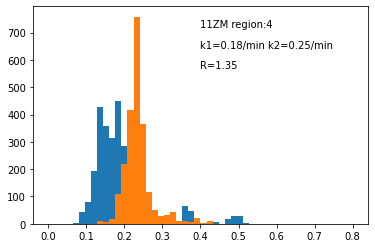

User: andrej studen CSRF: 299a67c7f1eb0b33fd1735392e430639
User: andrej studen CSRF: 32ba36470ed46aa85fe65d6a62e61e44


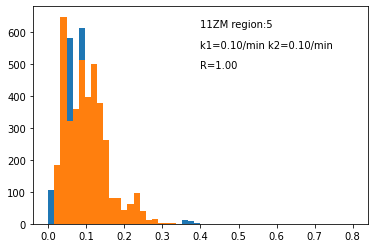

User: andrej studen CSRF: b1a98ebf095bba361a8e3a74e81edfb7
User: andrej studen CSRF: 1040d7d6b97f6979510df9051f119aea


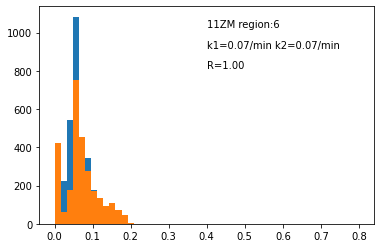

User: andrej studen CSRF: 9b132a4ef40a533681b28767fe053369
User: andrej studen CSRF: 058602dfb7a80bcba965965fa1e34d31


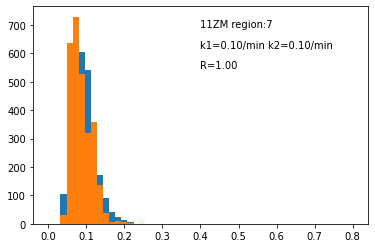

User: andrej studen CSRF: 5eae69959439fe080e5cc4007fc731fd
User: andrej studen CSRF: 0b0e8c3a2671daec87dda272485eaa0e


/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


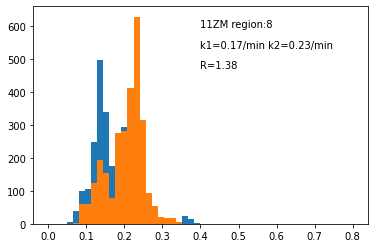

User: andrej studen CSRF: 23b21c5f10574ef07cc3335c35b5ca83
User: andrej studen CSRF: d737d001a80bc3b34a02a47af1f045b9


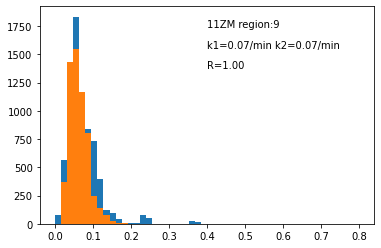

User: andrej studen CSRF: 835b909c3213028fefa95b7b6655c58d
User: andrej studen CSRF: eb9100595295287b15927b91409ee0ae


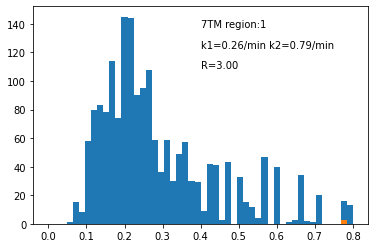

User: andrej studen CSRF: aaed6dd4212a7278048bbf199e2c2f38
User: andrej studen CSRF: 33c66e47cd04806f3a36857422e08552


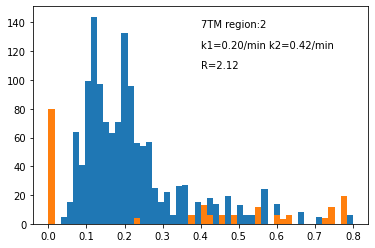

User: andrej studen CSRF: fe82770c11328d62557af62de4419e6c
User: andrej studen CSRF: 0a24d8cdbbb20884c0379a8153968ad4


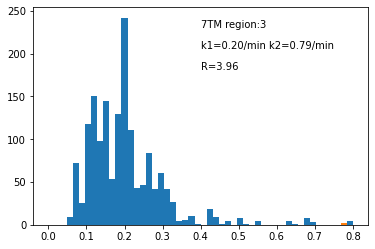

<ipython-input-234-b44355a10f82>:89: RuntimeWarning: invalid value encountered in double_scalars
  s[state]=sum(x*y)/numpy.sum(y)


User: andrej studen CSRF: 8dcc9965b294fe8c5b43e848485c69ab
User: andrej studen CSRF: 99a0f8a51972900d9cdd65d81fa80195


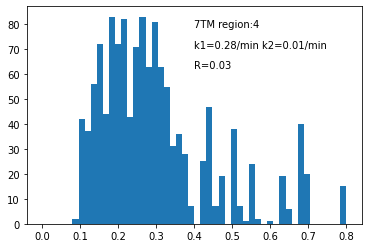

User: andrej studen CSRF: d7d5928c48e92aac097a0ae4a19306e7
User: andrej studen CSRF: 6a44d70ebe703e5b85491d1c1cb45421


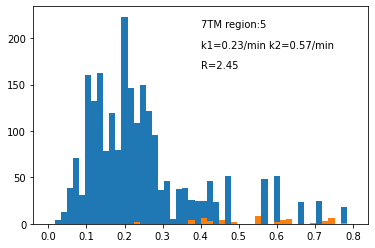

User: andrej studen CSRF: 680653d2ddec8822d44f0fd85c8a1c8c
User: andrej studen CSRF: ee4c55abe21cef58101e5656ae047b2f


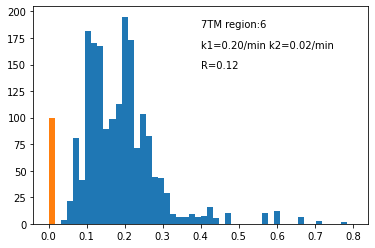

User: andrej studen CSRF: 47be9f7634c66fc69395a2ad9f042057
User: andrej studen CSRF: 356ada2ea714f9717693b1b8ef0ef7f8


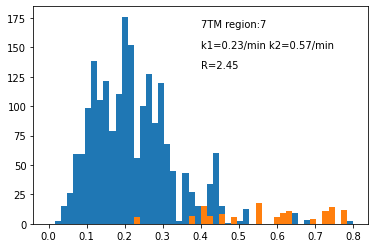

User: andrej studen CSRF: 9b0110e2303fa9d177701842703c8c00
User: andrej studen CSRF: c4cb3a29ef3c83cb5bbbc7e8ad123a9e


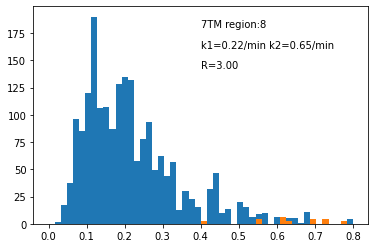

User: andrej studen CSRF: 3ade21506839170d0cc1144f4ad68011
User: andrej studen CSRF: e8e86c20583d42483a871d6d2d294591


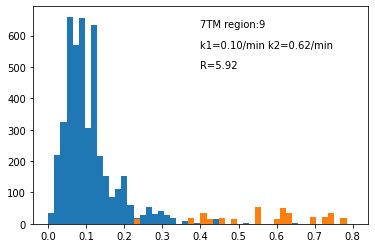

In [236]:
nclass=[10,20,30]
ds=db.selectRows(project,'study','Imaging',[])
patients=list(set([row['PatientId'] for row in ds['rows']]))
for c in nclass:
    for p in patients:
        updatePatient(db,fb,project,locDir,p,c)


In [199]:
nclass=30
ds=db.selectRows(project,'study','Imaging',[])
patients=list(set([row['PatientId'] for row in ds['rows']]))
idFilter={'variable':'PatientId','value':patients[4],'oper':'eq'}
ds=db.selectRows(project,'study','Imaging',[idFilter])
rows=ds['rows']
#rows=[ds['rows'][1]]
rId=1
k1Mean={}
k1Std={}
k1Median={}
k190p={}
k195p={}

for r in rows:
    pId=r['PatientId']
    if pId.find('8')==0:
        continue
    state='MIR'
    if r['SequenceNum']>1:
        state='OBR'
    p=r['aliasID']
    
    for rId in numpy.arange(1,21):
        w,w1=getWeights(locDir,p,nclass,rId)
        fitPar=getFitPar(locDir,p,nclass,rId)
        fz,hM,hW,cM,cW=calculateK1(w1,fitPar,range=0.8)
        #x,y,w = makePlot(hW[7])
        #matplotlib.pyplot.bar(x,y,width=w)
        #matplotlib.pyplot.text(0.3,20,'{} {}'.format(state,rId))
        #matplotlib.pyplot.show()
        for r in w1:
            x,y,w = makePlot(hW[r])
            try:
                k1Mean
                fy=hMy[r][state]
                hMy[r][state]=fy+y
            except KeyError:
                try:
                    hMy[r][state]=y
                    hMx[r][state]=x
                    hMw[r][state]=w
                except KeyError:
                    hMy[r]={}
                    hMx[r]={}
                    hMw[r]={}
                    hMy[r][state]=y
                    hMx[r][state]=x
                    hMw[r][state]=w
                    
#generate table

            
for r in hMy:
    ymax=-1e30
    s={}
    for state in hMy[r]:
        y=hMy[r][state]
        x=hMx[r][state]
        s[state]=sum(x*y)/numpy.sum(y)
        s[state]=median(x,y)
        if max(y)>ymax:
            ymax=max(y)
        matplotlib.pyplot.bar(hMx[r][state],hMy[r][state],width=hMw[r][state])
        
    matplotlib.pyplot.text(0.5,0.8*ymax,'{} {:.2f} {:.2f} {:.2f}'.format(r, s['MIR'], s['OBR'], s['OBR']/s['MIR']))
    matplotlib.pyplot.show()
    
        
        

ValueError: too many values to unpack (expected 5)

In [283]:
def getReadings(db,fb,project, locDir,patient, nclass, state, region):
    readings=[]
    idFilter={'variable':'PatientId','value':patient,'oper':'eq'}
    if state=='MIR':
        seqNum=1
    else:
        seqNum=2
    seqFilter={'variable':'SequenceNum','value':str(seqNum),'oper':'eq'}
    ds=db.selectRows(project,'study','Imaging',[idFilter,seqFilter])
    r=ds['rows'][0]
    p=r['aliasID']
    weightOption='M'
    for realizationId in numpy.arange(1,21):
        w,w1=getWeights(locDir,p,nclass,realizationId)
        fitPar=getFitPar(locDir,p,nclass,realizationId)
        fz,hM,hW,cM,cW,mean,qstd,qmedian,f90p,f95p=calculateK1(w1,fitPar,range=0.8)
        readings.append(qmedian[weightOption][region])
    return readings

In [321]:
readings=getReadings(db,fb,project,locDir,'3ZF',30,'OBR',4)
print('{}/{} {}'.format(numpy.mean(readings),numpy.median(readings),readings))

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


0.1717014552788048/0.0123290601946793 [0.0144468093384034, 0.0126375219636926, 0.0123519953996662, 0.0125862693669712, 0.0117293897461073, 0.0111634965893434, 0.0117049841737494, 0.010668459217788, 0.0100689856147897, 0.0118181001711018, 0.0120033348738202, 0.951586202467306, 0.0122334823506609, 0.725326075134794, 0.0123061249896924, 0.0125570770581166, 0.0124897531830398, 1.53309457488615, 0.0118638413292519, 0.0313926277216508]


In [372]:
import matplotlib.pyplot
import matplotlib.image as mpimg
import json

#extract patient values for a particular realization,
#return region averages and histograms of k1 in region
#based on pixel selection criteria, which is either 'M' 
#for maximum probability or 'W' for probability weighted contribution
#of cluster in each pixel (see calculate K1)

#fill ImageDataRealization
def getPatient(db,fb,project, locDir,patient, nclass, realizationId,\
               state, region):
    avgMode='M'
    idFilter={'variable':'PatientId','value':patient,'oper':'eq'}
    if state=='MIR':
        seqNum=1
    else:
        seqNum=2
    seqFilter={'variable':'SequenceNum','value':str(seqNum),'oper':'eq'}
    ds=db.selectRows(project,'study','Imaging',[idFilter,seqFilter])
    r=ds['rows'][0]
    
    p=r['aliasID']
    oDirRemote=fb.buildPathURL(project,[p]);
    
    w,w1=getWeights(locDir,p,nclass,realizationId)
    fitPar=getFitPar(locDir,p,nclass,realizationId)
    fz,hM,hW,cM,cW,mean,qstd,qmedian,f90p,f95p=calculateK1(w1,fitPar,range=0.8)
    #plot most common responses
    cmSort=numpy.flip(numpy.argsort(cM[region]))
    
    #last argument
    for i in numpy.arange(3):
        idx=cmSort[i]
        #print('{}: {}'.format(idx,cM[region][idx]))
        fname='{}_{}_{}_centers{}.png'.format(p,nclass,realizationId,idx+1)
        fp=os.path.join(locDir,p,fname)
        img = mpimg.imread(fp)
        #imgplot = matplotlib.pyplot.imshow(img)
        #matplotlib.pyplot.show()
        rf=oDirRemote+'/'+fname
        if not fb.entryExists(rf):
            fb.writeFileToFile(fp,rf)  
    
    realizationFilter={'variable':'realizationId','value':str(realizationId),'oper':'eq'}
    stateFilter={'variable':'state','value':state,'oper':'eq'}
    nclassFilter={'variable':'nclass','value':str(nclass),'oper':'eq'}
    regionFilter={'variable':'regionId','value':str(region),'oper':'eq'}
    
    #fill database
    dsQ=db.selectRows(project,'study','ImagingDataRealization',[idFilter,stateFilter,nclassFilter,regionFilter,realizationFilter])
    if len(dsQ['rows'])>0:
        qrow=dsQ['rows'][0]
        mode='update'
    else:
        qrow={}
        qrow['PatientId']=patient
        qrow['SequenceNum']=nclass+0.01*region+0.0001*realizationId
        if state!='MIR':
            qrow['SequenceNum']+=1
        qrow['realizationId']=int(realizationId)
        qrow['state']=state
        qrow['nclass']=int(nclass)
        qrow['regionId']=int(region)
        mode='insert'
    
    qrow['k1Mean']=mean[avgMode][region]
    qrow['k1Median']=qmedian[avgMode][region]
    qrow['k190p']=f90p[avgMode][region]
    qrow['k195p']=f95p[avgMode][region]
    qrow['k1Std']=qstd[avgMode][region]
    qrow['centers']=';'.join([str(cmSort[i]) for i in numpy.arange(3)])
    qrow['cW']=';'.join(['{:.2f}'.format(cM[region][cmSort[i]]) for i in numpy.arange(3)])
    db.modifyRows(mode,project,'study','ImagingDataRealization',[qrow])
    
    
    fname='{}_{}_{}_histogram{}.png'.format(p,nclass,realizationId,region)
    fp=os.path.join(locDir,p,fname)
    x,y,w=makePlot(hM[region])
    if state=='MIR':
        color='tab:blue'
    else:
        color='tab:orange'
    imgplot = matplotlib.pyplot.bar(x,y,width=w,color=color)
    matplotlib.pyplot.savefig(fp)
    rf=oDirRemote+'/'+fname
    if not fb.entryExists(rf):
        fb.writeFileToFile(fp,rf)  
        
    #print('Saved to {}'.format(oDirRemote+'/'+fname))
    #write file to file
    #matplotlib.pyplot.show()
    
    
    jsonHistogram={'x':x.tolist(),'y':y.tolist(),'w':w.tolist()}
    fname='{}_{}_{}_histogram{}.json'.format(p,nclass,realizationId,region)
    fp=os.path.join(locDir,p,fname)
    with open (fp,'w') as f:
        json.dump(jsonHistogram,f)
    #write to server
    rf=oDirRemote+'/'+fname
    if not fb.entryExists(rf):
        fb.writeFileToFile(fp,rf)
    #fitPar?
    fname='{}_{}_{}_fitParFinal.txt'.format(p,nclass,realizationId)
    fpRemote=oDirRemote+'/'+fname
    if not fb.entryExists(fpRemote):
        fp=os.path.join(locDir,p,fname)
        if os.path.isfile(fp):
            fb.writeFileToFile(fp,fpRemote)
    
    

In [ ]:
patients=['2SB','3ZF','5MI','7TM','10KF','11ZM']
states=['MIR','OBR']
classes=[10,20,30]
regions=numpy.arange(1,10)
realizations=numpy.arange(1,21)
for p in patients:
    for s in states:
        for c in classes:
            for realizationId in realizations:
                for r in regions:
                    print('{} {} {} {}/20 {}/9'.format(p,s,c,realizationId,r))
                    getPatient(db,fb,project,locDir,p,c,realizationId,s,r)

2SB MIR 10 1/20 1/9


/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 0ee8068393df22fb03a06fb7d7f325f5
User: andrej studen CSRF: 7fa99e87faf994970e034e1109522a4f
2SB MIR 10 1/20 2/9
User: andrej studen CSRF: 5525eea4135a4f3e6ed848516d295c01
User: andrej studen CSRF: cd255ec77d361c343030956d9ca2b5b9
2SB MIR 10 1/20 3/9
User: andrej studen CSRF: 2eb25ba503187f3a2be301825114154b
User: andrej studen CSRF: 1b3c896097730f977278fb27e4c22214
2SB MIR 10 1/20 4/9
User: andrej studen CSRF: faddd63c4ddd4a95cf2063ff65e00624
User: andrej studen CSRF: 14a89cf76c829493ff37e474dc7c785c
2SB MIR 10 1/20 5/9
User: andrej studen CSRF: 5b38bf675e6b357978b020e512e8eebd
User: andrej studen CSRF: e95500ec380e742d01e2d719c9a692d5
2SB MIR 10 1/20 6/9
User: andrej studen CSRF: bc0d0d346f0f61656e41783ef32f617c
User: andrej studen CSRF: 956916faca40ab92031605eb795402e9
2SB MIR 10 1/20 7/9
User: andrej studen CSRF: 6b7213ec1221434d5fe6f30d35b1736e
User: andrej studen CSRF: 0d6feae77916fc97e4c2f639704851d9
2SB MIR 10 1/20 8/9
User: andrej studen CSRF: f895f7e8

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: d40ce72d34c2f813dd8d0a42470a5797
2SB MIR 10 1/20 9/9
User: andrej studen CSRF: ede71adc4bd20ce6ce17b49248214f5f
User: andrej studen CSRF: d93d6a622affcfa416aadcc195c979f3
2SB MIR 10 2/20 1/9
User: andrej studen CSRF: d282bb7680bf66ac31f10435cc0d4765
User: andrej studen CSRF: 1c6b3986862dbd7ba117bdff2d7047fc
2SB MIR 10 2/20 2/9
User: andrej studen CSRF: b7d9a5b6db179226bc03ace09fe0454a
User: andrej studen CSRF: ac78c61df659659f9adf06be1a698c8a
2SB MIR 10 2/20 3/9
User: andrej studen CSRF: 617b560242ab4ad53aea6826bc7c950e
User: andrej studen CSRF: b696c2810d94ebb5d84102e851826e24
2SB MIR 10 2/20 4/9
User: andrej studen CSRF: 2bf237c5557792c12b639fad003f35cf
User: andrej studen CSRF: 2edac479842b1762dffb35d7373055b2
2SB MIR 10 2/20 5/9
User: andrej studen CSRF: 4f90b1434349780fa244228e1ed1c66c
User: andrej studen CSRF: a551782e9a0e1148a7646052f76c85e3
2SB MIR 10 2/20 6/9
User: andrej studen CSRF: 2499d44c1b80c0a2ed08f11a59ddfd1a
User: andrej studen CSRF: 207bb26e

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 4f4bf266f35dc81a36e1dad52084964e
User: andrej studen CSRF: 89d000f13dc04cd60b161dd19c9fcc53
2SB MIR 10 2/20 8/9
User: andrej studen CSRF: e6d1c23467ac7285656087accc119e9d
User: andrej studen CSRF: 48386968feb9365dd914f7d7b0db2bc3
2SB MIR 10 2/20 9/9
User: andrej studen CSRF: e077ad227e11314c8ea2638f2192a5c0
User: andrej studen CSRF: d1d30a148d6570dbb68c522676851741
2SB MIR 10 3/20 1/9
User: andrej studen CSRF: 5e9a90a698f4228725bf7dbb9ab97596
User: andrej studen CSRF: 3fb81ef346e0189e8030ada68221e262
2SB MIR 10 3/20 2/9
User: andrej studen CSRF: 79b402d755315a795d7b5ee2beb8b6fc
User: andrej studen CSRF: 3d9a4f12e202e4890e8b30006b618f49
2SB MIR 10 3/20 3/9
User: andrej studen CSRF: f91ecc0af830d423b5424c813cc6e32c
User: andrej studen CSRF: 192d461235421599c17de533e12b5afb
2SB MIR 10 3/20 4/9
User: andrej studen CSRF: fcb24425504602fd84854d875fe63d2f
User: andrej studen CSRF: e6311ee85fdb531829e6fc05cb17f56d
2SB MIR 10 3/20 5/9
User: andrej studen CSRF: 3e2f81c6

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: f658fff6ee6b5c25c6bb613f96517333
User: andrej studen CSRF: 087d17bb3a7a247106e49f658a7185ba
2SB MIR 10 3/20 7/9
User: andrej studen CSRF: 44a940ebb3c3150f6188d8081be30838
User: andrej studen CSRF: ada260fa7e249d74cdb8bbed12fd93f9
2SB MIR 10 3/20 8/9
User: andrej studen CSRF: 38216461bcd4e4cfe393a322226335b7
User: andrej studen CSRF: 2582cee6a57186e7a8ac2faf8449f5c8
2SB MIR 10 3/20 9/9
User: andrej studen CSRF: 8a4a41eafdcbc38327f89569c4c618cc
User: andrej studen CSRF: a144e76245ffe67ebd731bf0cd2e2873
2SB MIR 10 4/20 1/9
User: andrej studen CSRF: 7ccb91ccbd6a98db2b3dc751e80e4be9
User: andrej studen CSRF: e16b3df05678c22f62f8e6547b41f7f5
2SB MIR 10 4/20 2/9
User: andrej studen CSRF: e6fb730156701978190a77b64ff2b54f
User: andrej studen CSRF: e7a5dbd82a9e3c27a4129823848b2375
2SB MIR 10 4/20 3/9
User: andrej studen CSRF: 0d58fa40dada03cc0b0e21f3f5b2d677
User: andrej studen CSRF: eecab595e0165b3dbfd26bc7e1f9d233
2SB MIR 10 4/20 4/9
User: andrej studen CSRF: d27dcb72

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 10 4/20 5/9
User: andrej studen CSRF: 6c32e91bbfd2eefc726dd7a09b042a8a
User: andrej studen CSRF: 73d8efcfe330c330063210911fe218eb
2SB MIR 10 4/20 6/9
User: andrej studen CSRF: 7c42bfce4c4eab1cba064c121d2f22ba
User: andrej studen CSRF: 096a70b51ed416dffbb0a2ad2e447b5a
2SB MIR 10 4/20 7/9
User: andrej studen CSRF: d4fd465fb7184e35b559e1910c33a149
User: andrej studen CSRF: e933a5b087a1c9b82304e3ce416fd2c7
2SB MIR 10 4/20 8/9
User: andrej studen CSRF: bef1cc290370f307191c1e0a92f3791b
User: andrej studen CSRF: 041ba3926d4f47d178f9cb55d2c57968
2SB MIR 10 4/20 9/9
User: andrej studen CSRF: 21c94c0bc63c02e8610b47e2aed54242
User: andrej studen CSRF: 1a3d6cdb50277ca00d246138d0e82457
2SB MIR 10 5/20 1/9
User: andrej studen CSRF: 199b685c8b80ac55a250a61a09631134
User: andrej studen CSRF: d9c634980de55b65be591ef047ce6086
2SB MIR 10 5/20 2/9
User: andrej studen CSRF: 807e7d85c030f77d8733bb79b8363254
User: andrej studen CSRF: ccdb1873cad90399ee5244d9a1ff8871
2SB MIR 10 5/20 3/9


/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: c5b4d978e9fceb3dd8af17fed2ecdcdf
User: andrej studen CSRF: 20625278badfe9af62dce1fbc09a5b75
2SB MIR 10 5/20 4/9
User: andrej studen CSRF: ba9615b844886a4592302e90ecd9815b
User: andrej studen CSRF: 78c8fb34e64f49d945c4dd603c14a01c
2SB MIR 10 5/20 5/9
User: andrej studen CSRF: 12f9cbbe1bbb033ea41a77fd071d1ba6
User: andrej studen CSRF: 58f7e08ae44598cdc71267eb2d843be1
2SB MIR 10 5/20 6/9
User: andrej studen CSRF: 8c10d8a86c541ac8093c33653dcc71ee
User: andrej studen CSRF: 8121d356225c9dc94287150ead30647b
2SB MIR 10 5/20 7/9
User: andrej studen CSRF: b7b9e9be0ec37c707efc57ae2069e418
User: andrej studen CSRF: 31479d5dddaba47327d78c418eab2c56
2SB MIR 10 5/20 8/9
User: andrej studen CSRF: 28d38110479128b7c929e26f2e09f088
User: andrej studen CSRF: e3c0858edf98f02e052ec02a05f211f0
2SB MIR 10 5/20 9/9
User: andrej studen CSRF: 475991b6573a2749e292a46ac9906bd1
User: andrej studen CSRF: c96eb413da82360fbf090ebe1138a90b
2SB MIR 10 6/20 1/9
User: andrej studen CSRF: af338d68

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: f161dc8350892b1fcdd36d2d3b01c917
User: andrej studen CSRF: 119bdc2fd9ad62bb1d5621bd4aca89fc
2SB MIR 10 6/20 3/9
User: andrej studen CSRF: e39ccb966770bac6a6bc22e4ec3471db
User: andrej studen CSRF: d088b51ddb0656b0f1c752ebc163efcc
2SB MIR 10 6/20 4/9
User: andrej studen CSRF: 8237b7252d3202f800657fe00b09bfa6
User: andrej studen CSRF: bbad3217d7455efe12e15bfcf427edc2
2SB MIR 10 6/20 5/9
User: andrej studen CSRF: d74fffea61f889bd8ff72be4d52ad8c7
User: andrej studen CSRF: 10df2cf9e5039c4b2ba6c54c37518e18
2SB MIR 10 6/20 6/9
User: andrej studen CSRF: a78ed0cc5c8d230c372f02a0cd7f7485
User: andrej studen CSRF: d30c663ceb2e0e2186ec58d7ba3f47fb
2SB MIR 10 6/20 7/9
User: andrej studen CSRF: b0156e9e9f702c1ab744dff8698655c9
User: andrej studen CSRF: e230928514def97e01fb3d693c2b037a
2SB MIR 10 6/20 8/9
User: andrej studen CSRF: c7c011f131b2c022a1620e0b0fe83263
User: andrej studen CSRF: b1059f3a314fea5e4241ff7d998cf994
2SB MIR 10 6/20 9/9
User: andrej studen CSRF: c29e0a25

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 10 7/20 1/9
User: andrej studen CSRF: b24ffdc71005083fb4b6af65dd467b46
User: andrej studen CSRF: ea4dd16f3db9ddf9e68b41977a83eaa4
2SB MIR 10 7/20 2/9
User: andrej studen CSRF: 113094f77c61569c9acbef4d1edb8cd2
User: andrej studen CSRF: 337b1ce35583eb14fc53056bbc24b511
2SB MIR 10 7/20 3/9
User: andrej studen CSRF: d361dbf6b6876273d7073efd739330bd
User: andrej studen CSRF: 08176037c17e9a1683b2d4f400e38dcb
2SB MIR 10 7/20 4/9
User: andrej studen CSRF: 305dbf6aa05d9b9a095957961f154137
User: andrej studen CSRF: 90b180983fe9427f243348ad7b79ecc1
2SB MIR 10 7/20 5/9
User: andrej studen CSRF: d889556955bb05b0cd575e0d57803610
User: andrej studen CSRF: e509a820dfe007904dba8f8193bc1c1f
2SB MIR 10 7/20 6/9
User: andrej studen CSRF: cb9a5fec57203c5357d062aecd7f07ea
User: andrej studen CSRF: 8c79eb00e15def5e17e417b3b5f26e5c
2SB MIR 10 7/20 7/9
User: andrej studen CSRF: c0d5cf0365d29d8643fe2c4ab7fe2357
User: andrej studen CSRF: 29c008846f1da2eece69150b3ac2627a
2SB MIR 10 7/20 8/9
User: andrej s

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 7cc5ada55e22cc350df0923265aff54f
2SB MIR 10 7/20 9/9
User: andrej studen CSRF: 3afb66bc0c1d320721cea97ce35f8996
User: andrej studen CSRF: 137786214db49b427f1e9f5ae3d5f901
2SB MIR 10 8/20 1/9
User: andrej studen CSRF: db9ec7c9c301c54672356e54dfe48356
User: andrej studen CSRF: 9c70117afdbd49d92cd247dcbbfaf764
2SB MIR 10 8/20 2/9
User: andrej studen CSRF: 17115a033041ab53e33f024fcb273691
User: andrej studen CSRF: 19cf0528538c9d5660de4c502e406f44
2SB MIR 10 8/20 3/9
User: andrej studen CSRF: 657b9aed7f36f0a1931721cd4de8ce8c
User: andrej studen CSRF: 84be5e5113ed7fb26864c86e7287ee86
2SB MIR 10 8/20 4/9
User: andrej studen CSRF: 1ee0b37205b8803e073a0eb9fe9174aa
User: andrej studen CSRF: 6c76333b7a0bf953d1da915a760070ab
2SB MIR 10 8/20 5/9
User: andrej studen CSRF: 00179c5dc0ef6d0e87ed82bc6a9e2a66
User: andrej studen CSRF: b06b071692cddcb2a5014a6c0be46037
2SB MIR 10 8/20 6/9
User: andrej studen CSRF: be204d0d76079c5d460f80e690ae2828
User: andrej studen CSRF: 8eebcb52

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 259717ab05694a9b39635c82f2b2f210
User: andrej studen CSRF: 22e692d3e977fb9404b900e599128e43
2SB MIR 10 8/20 8/9
User: andrej studen CSRF: 8785f22f02e3df31ae836d2f9ce5a242
User: andrej studen CSRF: c6b42e51ec066656dbc72a7942e80f0b
2SB MIR 10 8/20 9/9
User: andrej studen CSRF: 7e34cc235a2eaf2fa348dcd9fcff24dd
User: andrej studen CSRF: 3ef1a16613828935994871f0b4a25401
2SB MIR 10 9/20 1/9
User: andrej studen CSRF: 5abb07fabccdcdaf55bd7e9c7c7d4126
User: andrej studen CSRF: 45b896d9d62763578115d113dedd157b
2SB MIR 10 9/20 2/9
User: andrej studen CSRF: 2edd2fb98970ea60c16a4858cab8ca34
User: andrej studen CSRF: 40b2a56bf55b6c703b39acad56eaf49f
2SB MIR 10 9/20 3/9
User: andrej studen CSRF: 6e9a404e70f2fe2ae8247c4f1a7f5618
User: andrej studen CSRF: 76ad26a3b164d1ac9327d1d8e1c6afb0
2SB MIR 10 9/20 4/9
User: andrej studen CSRF: 7e1be4acdd002c89cdf59f1721999c8d
User: andrej studen CSRF: 90fbada860f22a530ff988c7599280e3
2SB MIR 10 9/20 5/9
User: andrej studen CSRF: 00856ba6

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 10 9/20 6/9
User: andrej studen CSRF: d34eb2774bb0857b1dad936c10776dfc
User: andrej studen CSRF: 8c665b216ed17d30c58f7134cac61633
2SB MIR 10 9/20 7/9
User: andrej studen CSRF: b7506f16bb69742be07ce2fb30e34d61
User: andrej studen CSRF: e1b9313a7343b529341e69cc5322df8f
2SB MIR 10 9/20 8/9
User: andrej studen CSRF: a96542a594db86bfabc0735c065a09a5
User: andrej studen CSRF: 0149e2726ede49581078f2dd4ef92ab7
2SB MIR 10 9/20 9/9
User: andrej studen CSRF: a9d91da8bc381447df18ef694abfa494
User: andrej studen CSRF: 47f514f7f18bbb05dc56a09262fa566a
2SB MIR 10 10/20 1/9
User: andrej studen CSRF: 78f7630824dfcedd8fc4f53981a682e6
User: andrej studen CSRF: f05291b39d901d137f22d1071ba0c84f
2SB MIR 10 10/20 2/9
User: andrej studen CSRF: 74737d6b3b9810c55e8289c854ac2a87
User: andrej studen CSRF: 70bc052df8e67d4be6ee8eee8cc521b0
2SB MIR 10 10/20 3/9
User: andrej studen CSRF: 99f66ae566ff17381f20df74cbd95869
User: andrej studen CSRF: 1592de7fc340297b73d960cf90ae0e55
2SB MIR 10 10/20 4/9
User: andr

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: cabf37d36cdebc9d577bcee20e3550db
2SB MIR 10 10/20 5/9
User: andrej studen CSRF: 45cdbd0ae8cd6240b73aaa856cd461ee
User: andrej studen CSRF: d57162a2c0d9a7caaba589f2ba1a3761
2SB MIR 10 10/20 6/9
User: andrej studen CSRF: 6138d5ce10bbc33fae45533b879df181
User: andrej studen CSRF: 3c995291bde0034ab071bef2325ee6d8
2SB MIR 10 10/20 7/9
User: andrej studen CSRF: fec979b1223c48297f16ebf4fb9a758f
User: andrej studen CSRF: 9d26d53839e940a67719704c9c74c1fc
2SB MIR 10 10/20 8/9
User: andrej studen CSRF: a77cf0d7284901cdefec49b61e43893b
User: andrej studen CSRF: 330df87cca008f9df8ad4e4b21a7c240
2SB MIR 10 10/20 9/9
User: andrej studen CSRF: f7ab78cb4238abe7321fea2426314de6
User: andrej studen CSRF: d337ab42274213c69979eb79572b578b
2SB MIR 10 11/20 1/9
User: andrej studen CSRF: 686fe2c9e7b0844f73605f3fb61f2f7e
User: andrej studen CSRF: 88e6bf0c1d05800f1431fbd6cf144c76
User: andrej studen CSRF: 4bec622699aa2fce959dce504ce333ac
2SB MIR 10 11/20 2/9
User: andrej studen CSRF: 7

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 8b3b9a812ae7bd9939067503c34313ad
User: andrej studen CSRF: a6f01b44134dafc320b1d7af4acb933e
2SB MIR 10 11/20 4/9
User: andrej studen CSRF: a038e9a589263e2cabc255a4db18e3b5
User: andrej studen CSRF: 7a69f9d45ba25cfdbd1bd16e5c05b1c4
2SB MIR 10 11/20 5/9
User: andrej studen CSRF: a0445586ad588cd14357e325f975e7a1
User: andrej studen CSRF: 9c9ced7d3db6339a05e79da8ffc5ee96
2SB MIR 10 11/20 6/9
User: andrej studen CSRF: 3258951297aab833b3530faa16896345
User: andrej studen CSRF: 86348b8b28f9cc9d3723b92c8e9c6a7d
2SB MIR 10 11/20 7/9
User: andrej studen CSRF: 68645f8bffec0896711f1448debe0f50
User: andrej studen CSRF: a0d992c0155c25781baa90d58a078494
2SB MIR 10 11/20 8/9
User: andrej studen CSRF: 11940f3f96188822836e94f3b83d4a44
User: andrej studen CSRF: a2efd0445e451fa24343dbce05ffa555
2SB MIR 10 11/20 9/9
User: andrej studen CSRF: fac4350fb8011395766ee93fd7e8f3bd
User: andrej studen CSRF: 3689615b16972630230df9d52b1602e0
2SB MIR 10 12/20 1/9
User: andrej studen CSRF: 5

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 10 12/20 2/9
User: andrej studen CSRF: a2904fa9259a989e2865796cc1db371e
User: andrej studen CSRF: 4f83e4acd2f78574d47e5d5ea8e4e2ba
2SB MIR 10 12/20 3/9
User: andrej studen CSRF: 6bcaec904a641cf993c6b25f0dadf837
User: andrej studen CSRF: 2bc47a89d6e47782317fd943c6771dd8
2SB MIR 10 12/20 4/9
User: andrej studen CSRF: 1274e8776fcd68237a865567a8f1c7e7
User: andrej studen CSRF: fd9c7ff487bf94131612a191d77ba037
2SB MIR 10 12/20 5/9
User: andrej studen CSRF: 6ef66fd092fb04abe465d39221a99c2b
User: andrej studen CSRF: c561f886d9fdcc5922654719ab7c9f42
2SB MIR 10 12/20 6/9
User: andrej studen CSRF: aabdfedc79929a240ffe55e6f4360492
User: andrej studen CSRF: 48bc63c1e83a657b504245de116d3669
2SB MIR 10 12/20 7/9
User: andrej studen CSRF: bab2b7e86e04ef8e7054f494223635d8
User: andrej studen CSRF: c70b1e3dac90d4458f530319b11128f2
User: andrej studen CSRF: bb33d4655990552fa4bf47b6aed27b8e
2SB MIR 10 12/20 8/9
User: andrej studen CSRF: 65f0348110b744ffae7221c8e548ea3b
User: andrej studen CSRF: 4

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 2f2667bc87d2174314a9e109d63092a5
User: andrej studen CSRF: fdfeb269e2192369c63cc6039af4349b
User: andrej studen CSRF: cb5bbe82bba067353e89e16d5b8a6ba5
2SB MIR 10 13/20 1/9
User: andrej studen CSRF: 685a5349834c01982fff2f2d09d889f5
User: andrej studen CSRF: 3626b521368f2246e31a3abac406691f
User: andrej studen CSRF: df8ab59b39d38f8396c86ff2fa2ead43
User: andrej studen CSRF: d71730d259f901053a3cafe2b0d8570a
User: andrej studen CSRF: 78ff258d52f6e5bdc9de435b63fd7b5d
User: andrej studen CSRF: 3ec5763f74918b26ebe530d6a5fc8501
User: andrej studen CSRF: 2cba14ef92e505145452e2a8a1027b8a
2SB MIR 10 13/20 2/9
User: andrej studen CSRF: d24c5ec9dc2d40f678a65af1a523622e
User: andrej studen CSRF: 1f1d6af793dbf472c563fb3252990f15
User: andrej studen CSRF: 30041620e9480c5e1dab17f4cd09dc73
User: andrej studen CSRF: 579991b9c946c2d4505b142ef74a63bc
User: andrej studen CSRF: 6778993ee94ce3173ca90ee1836e9ce5
2SB MIR 10 13/20 3/9
User: andrej studen CSRF: 56330499761e90f27845fd7358

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 28b0c87877ae4845ba0e69607c76f890
2SB MIR 10 13/20 6/9
User: andrej studen CSRF: 06a3f1c490e6441a55945ea049e78d09
User: andrej studen CSRF: 11df6f40e76e43ab3bf25c617ee59296
User: andrej studen CSRF: a8932b731d724960a2b05d2865171a09
2SB MIR 10 13/20 7/9
User: andrej studen CSRF: 30dd210cac0b1408b6f3e96e921fb533
User: andrej studen CSRF: 25fdfad44f792b3a600f6e2da464758d
User: andrej studen CSRF: 78883a542459b041f5a204d6c0a1a5e0
User: andrej studen CSRF: aca6b10c847ced5e1699a58521cae2c7
2SB MIR 10 13/20 8/9
User: andrej studen CSRF: 602abe68060f236602641409957bf693
User: andrej studen CSRF: e3582a72fa5f6c4d21d589bbfe961353
User: andrej studen CSRF: 742b0224d61e94b08fa1c9c06aeed9e8
2SB MIR 10 13/20 9/9
User: andrej studen CSRF: 1514b6c092a5d2c2ef200eceafff08e3
User: andrej studen CSRF: 6af3d172801da676c7706384977124e2
User: andrej studen CSRF: 438dae148221bc48933c7b806e17629d
2SB MIR 10 14/20 1/9
User: andrej studen CSRF: 0ac174014ba7b87a9c24e05e708e8ae3
User: andr

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: ae09c404a9acc947c4b120e74485071f
User: andrej studen CSRF: 07602902299f4ef3a52bf467f87df318
2SB MIR 10 14/20 3/9
User: andrej studen CSRF: 3b68f5b4ae843969629426e64cb51cc2
User: andrej studen CSRF: 721e8a8008bc83d6a011f5c9bd78911d
User: andrej studen CSRF: 00124cb3f4201500082b09520e39cac1
User: andrej studen CSRF: 699983e6ac28034120eccb46f5050819
User: andrej studen CSRF: 264856d6acef5c074107f562928325a2
2SB MIR 10 14/20 4/9
User: andrej studen CSRF: c852642d25d122113b0760453df0d824
User: andrej studen CSRF: 441501e1574c20da1dd432056125dcbc
User: andrej studen CSRF: 734cf365e2faf0b5c3d8150bc196dcc6
User: andrej studen CSRF: 28bc52515b9da20683f92cc9fcc8c6df
2SB MIR 10 14/20 5/9
User: andrej studen CSRF: c78ac0b8d2e3f6ae9c7cd8c17f9f3390
User: andrej studen CSRF: adce7768a2246c61dff6a52b913890a8
User: andrej studen CSRF: e903e7ed6532ae2486fb0938460e09f0
2SB MIR 10 14/20 6/9
User: andrej studen CSRF: c88ec0a9fcd4e008e15509fe647fb709
User: andrej studen CSRF: 7f91c

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 84e80ad75b82b0ed8d3fdc215447b9f3
2SB MIR 10 14/20 9/9
User: andrej studen CSRF: b04b2ad04930696c1f902469dcd723dc
User: andrej studen CSRF: bc5accc9c9edbe4ebcd83f4f771b146a
User: andrej studen CSRF: d1a8765f1a3e288e9fc5775d40acf594
2SB MIR 10 15/20 1/9
User: andrej studen CSRF: c8fbd7b7dd52268d55e51cf8b68990e3
User: andrej studen CSRF: eee09f974c1be4cc62e01a35099f67b2
User: andrej studen CSRF: b5e462360a4a0243faf5900e8a34ede6
User: andrej studen CSRF: 410d8b0029221d395dda4fa5ac0b3a16
User: andrej studen CSRF: 1d2771cb5bba7b2a066615942d8f9d7e
User: andrej studen CSRF: e5faf81c359da6e08d0ae7411096de84
User: andrej studen CSRF: 6ba23a66ed1ed3c58995d2e76b6e0e1c
2SB MIR 10 15/20 2/9
User: andrej studen CSRF: ed6bfd52991188518d7da197ea9056f1
User: andrej studen CSRF: 97cb6caf9b64d06cbde324385dd57455
User: andrej studen CSRF: f42b993b53087e523d985446c69bed44
User: andrej studen CSRF: 186a3059a8a81bd1d9cc66de98b00a73
2SB MIR 10 15/20 3/9
User: andrej studen CSRF: 2dd08

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 24adf8c47b488ad6f0a10a3d8acd1ee3
User: andrej studen CSRF: f6a3017d0785d6133b640d586f42122d
User: andrej studen CSRF: a0bfd845927f0adc2edeab63a1073cd6
2SB MIR 10 15/20 6/9
User: andrej studen CSRF: 6747d3ec8a93b3dd3b3e14e622600af4
User: andrej studen CSRF: 78903ed6abd4e56b6284763a8e63223f
User: andrej studen CSRF: 4326356bb4f62c3fc16eefadc79797bc
2SB MIR 10 15/20 7/9
User: andrej studen CSRF: f5ff6d7002f4c343a2765526068565f5
User: andrej studen CSRF: 12b7e51e7733ad85100cd55acabc2b27
User: andrej studen CSRF: 3823c5f76afc8035432bc8b3fffb73bd
User: andrej studen CSRF: 265e9067c72ea4c75ff119df88316a1b
2SB MIR 10 15/20 8/9
User: andrej studen CSRF: 5512d6c7fed7e94fa308247d23871726
User: andrej studen CSRF: e1b37f0b693f895e72784592ce5339fb
User: andrej studen CSRF: 2d38ab8e88977d62b97e421625d9aaf5
2SB MIR 10 15/20 9/9
User: andrej studen CSRF: f3afc9311cb98156a61389e14adfe574
User: andrej studen CSRF: fe41f02be500723ad5aa9a5084388d74
User: andrej studen CSRF: 73c26

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: f37e72317c0c95456ddaf9a93ae7c983
User: andrej studen CSRF: 2509647891f943af45bbfb1781b4374f
User: andrej studen CSRF: 3fe0e06c97a751ca9a0043af957eed75
User: andrej studen CSRF: b4d62a6ac88d061de8e7d229f77755f2
2SB MIR 10 16/20 3/9
User: andrej studen CSRF: 62d725d1e11092173b4450af57f4cf18
User: andrej studen CSRF: 88cf6433ea3b7b5615aa91637687ea4e
User: andrej studen CSRF: dbf59d0d52251030dad1d1f25110d69d
User: andrej studen CSRF: ee14747c0304cc2028411cdc87c3465e
User: andrej studen CSRF: 916be6181262761f996bfaba7876f34d
2SB MIR 10 16/20 4/9
User: andrej studen CSRF: 5a8db5af67096b3b203c5800ed7b2d03
User: andrej studen CSRF: 1fcfebe156c8930fad25b6ecf7cd109d
User: andrej studen CSRF: 60e27d67f504a614b33d8f6212f5e90f
User: andrej studen CSRF: cc3991630a8fb9b9b1d912b784912e8a
2SB MIR 10 16/20 5/9
User: andrej studen CSRF: 0842cc50ebbacf9d49cf966191fd7fce
User: andrej studen CSRF: b65b0865a02ff4ac4c8272d93a7d20c3
User: andrej studen CSRF: ecbc53c90c3ffa60adaea7e691

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 8b2f2a32dc8396fa81e65c171805cb3b
User: andrej studen CSRF: 78b12b0a1fc93ff13972bf667a9ba9f5
User: andrej studen CSRF: e0e94235d97b01daea36d73777fdcb4a
2SB MIR 10 16/20 9/9
User: andrej studen CSRF: 61dd656a4d75759b966ac7c43d54bf0a
User: andrej studen CSRF: 861fcf8e9a6e1db1d39e605dc002a81d
User: andrej studen CSRF: e0c05a7bc19f9d3a9c5ba746fbba09ff
2SB MIR 10 17/20 1/9
User: andrej studen CSRF: 64365d47309dfa75bb503921625c3a50
User: andrej studen CSRF: 02f8a08a86769ba5e34f5308224f6432
User: andrej studen CSRF: 4d788192183ef89ca2863b6cbd9963cf
User: andrej studen CSRF: b6a874f721469fdfd900c78f4fc76dd6
User: andrej studen CSRF: b35fbd8038c6805ae14639355f4f2175
User: andrej studen CSRF: 431320b56b967e4c24fe685467bbcb50
User: andrej studen CSRF: c2364935fdb36f3df50c411106059a15
2SB MIR 10 17/20 2/9
User: andrej studen CSRF: 24523219740a7be6df522aeeb07ad55e
User: andrej studen CSRF: 099215d1d86a5f41a698e8241022ec77
User: andrej studen CSRF: 80f58e89de8d19ed4e511d969e

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 10 17/20 5/9
User: andrej studen CSRF: 841a613e313480f8f334e26a6b92a9d1
User: andrej studen CSRF: 183b0ed85312991b6397623a057259bc
User: andrej studen CSRF: b5f4670668e53ffd33640fb24104b243
2SB MIR 10 17/20 6/9
User: andrej studen CSRF: 24a66a37c5c77f975c5d58c752f8934a
User: andrej studen CSRF: bf37c7bb8cd0a67934577dcd2f000a99
User: andrej studen CSRF: b0c4ec80aa19b4edd5a19a1cfa833b21
2SB MIR 10 17/20 7/9
User: andrej studen CSRF: d2dd393ed8379e101e67ceb7cb87a264
User: andrej studen CSRF: dfedcda4bd48d951e9bef9486742b73b
User: andrej studen CSRF: 263839da09c928b1e7342159d2a51b5d
User: andrej studen CSRF: afb2437fb4abd0a489a81526c748dcbb
2SB MIR 10 17/20 8/9
User: andrej studen CSRF: 465ac670c4b6a484d1ff7975046c0644
User: andrej studen CSRF: 1cb2b60f87c0ca36ab7eb6356e61beef
User: andrej studen CSRF: 94703196f6d4d539bc6349d9de5a9a8d
2SB MIR 10 17/20 9/9
User: andrej studen CSRF: ad06832f3d272238e2f46cf43396634c
User: andrej studen CSRF: 02c5f85eed6d652ab9b59e8d23b07616
User: andr

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 25c81ebc15708dbd9c068e3bb85eab48
2SB MIR 10 18/20 2/9
User: andrej studen CSRF: 6412ad129625d6e8698c5eba9c3ac5b5
User: andrej studen CSRF: 247b768424a7378b3a03dc156dca05ff
User: andrej studen CSRF: 63c666fa642bf9f4be4d3c6f8aa67cab
User: andrej studen CSRF: f6f868013fd927806f703c9397fa6098
User: andrej studen CSRF: a6ecd2f31e7467bbada77f1622f8e0ed
2SB MIR 10 18/20 3/9
User: andrej studen CSRF: 8a8e0167c8ccd67e551177aac888cb96
User: andrej studen CSRF: 8496888c848884d068a93b4e491b9db6
User: andrej studen CSRF: 937b32447d3824793b1cc578c123c65a
User: andrej studen CSRF: 2a888e810b99acc0a6b1aabe79a364ac
2SB MIR 10 18/20 4/9
User: andrej studen CSRF: 8e8f0fbb056523283e340798390a769b
User: andrej studen CSRF: 2d10bf7743306f32c124b64b5935d93f
User: andrej studen CSRF: 524834696dfa13e1a529d960a1a1b67d
User: andrej studen CSRF: 607daee14f450c74f0cdee3ee29c7a50
2SB MIR 10 18/20 5/9
User: andrej studen CSRF: 8fc2d78b378b6b72b4413183a9553b12
User: andrej studen CSRF: cc39e

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 10 18/20 8/9
User: andrej studen CSRF: 0a70ce2446e09f7ee4e1d419a7d12a69
User: andrej studen CSRF: e60ee03f9561a7d5bb84842c7001b0cc
User: andrej studen CSRF: 5302ec7a40989887c86985e1fc696510
2SB MIR 10 18/20 9/9
User: andrej studen CSRF: b8cd34993d88d780edff85540a58707c
User: andrej studen CSRF: 0a75c0ed998a83dfa7aa6503576301b8
User: andrej studen CSRF: 835e26a6d77d74dfdb7811125f646690
2SB MIR 10 19/20 1/9
User: andrej studen CSRF: 11f9e7c4dc89ea1e22cad5cbd39d8351
User: andrej studen CSRF: b530e964e29fc4cd51afa88ee7cb4df4
User: andrej studen CSRF: 23a721c7973ff9f424bcdb5930c50400
User: andrej studen CSRF: 78ed0e0d6f631412a408b1412d57b2fc
User: andrej studen CSRF: 3ab394538210eefd0643f3b16fe7f259
User: andrej studen CSRF: 9bc4c702ace972e56d6c39f206207b9f
User: andrej studen CSRF: ff7dba7554b9316a988cf892457b159d
2SB MIR 10 19/20 2/9
User: andrej studen CSRF: 2f0dbc47f7f539e1d6357d362ff1be1d
User: andrej studen CSRF: f053dbbe1114d1c8b8b4ab54cb2d1065
User: andrej studen CSRF: f67e0

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 3759d031d91373f3ee44f1e754e48299
User: andrej studen CSRF: 373b36ad0570f83d09bf853896cf37f1
2SB MIR 10 19/20 5/9
User: andrej studen CSRF: dc27a8461299c8c40a4c8b87fa294213
User: andrej studen CSRF: ca6a7a386d0d8ba08fefb5f42eb6880a
User: andrej studen CSRF: 482930452700e717500695ab919a6b60
2SB MIR 10 19/20 6/9
User: andrej studen CSRF: 741a4837b1dd66daa623fed21d47215c
User: andrej studen CSRF: e4c6578327a40a891f65f48b35eb0542
User: andrej studen CSRF: 85b27e8e1d6788f6c3c7fdf771c6872d
2SB MIR 10 19/20 7/9
User: andrej studen CSRF: d864a3e9e40314071a24e616c192f45d
User: andrej studen CSRF: 751e1d0866d5cc0200d08c4b282336b0
User: andrej studen CSRF: 0779f20e9b4ece3e12d215384b252571
User: andrej studen CSRF: 08a74112fd4a17fde74c8be48a409f34
2SB MIR 10 19/20 8/9
User: andrej studen CSRF: bda71bef43f05b800b5e26098c1f55a8
User: andrej studen CSRF: fe79de180ad0fae954694dc7bea70729
User: andrej studen CSRF: 754af3bd6fa98b3163ac92eb6ba85cd0
2SB MIR 10 19/20 9/9
User: andr

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 8e36622a849a2ac82f83cee1e9fdee97
User: andrej studen CSRF: f2de8c129647d68d834dc78827b7cf9a
User: andrej studen CSRF: 1eba38ae2ae86558d35163079eed9659
2SB MIR 10 20/20 2/9
User: andrej studen CSRF: e8d83b95fc0302e63e3df8b092f3af47
User: andrej studen CSRF: 6e819b67b4ee47d8f7378306adfe3dfd
User: andrej studen CSRF: c7e27b08507f544a8f05b80cd6284760
User: andrej studen CSRF: b3e79dcf459ac3add117f338243b3345
User: andrej studen CSRF: 048bf821b73d7ed2a33131335acd525b
2SB MIR 10 20/20 3/9
User: andrej studen CSRF: a007da147deeb8279df73b0f422aadea
User: andrej studen CSRF: 311331b7712cbb25aeceea9483015d71
User: andrej studen CSRF: 2af9a08c16e120cada1feeec47b8cc6f
User: andrej studen CSRF: 24e28c908f042077f3d293236cf3ba63
2SB MIR 10 20/20 4/9
User: andrej studen CSRF: 70f55fef582273835eb43ac56926c5c3
User: andrej studen CSRF: a2e8f65c0ff193edf3606fa751b02db6
User: andrej studen CSRF: b0545dd962e9f3867751312c3a3c5fcf
User: andrej studen CSRF: a6236db544ad975afd0b7ce1c5

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: d4a30a8b2fe642670d77251a2eb48a21
User: andrej studen CSRF: 5b54d38979a48d24e45cbf19340eddd7
2SB MIR 10 20/20 8/9
User: andrej studen CSRF: b0baa100b2392f2e03122711ebd8b0a9
User: andrej studen CSRF: 6e09deec24ee6367557aac737f0b4391
User: andrej studen CSRF: fbee24c9f4258cc106cae65ef466c6df
2SB MIR 10 20/20 9/9
User: andrej studen CSRF: ff92750515c3e9b05491597fc78bbaae
User: andrej studen CSRF: 70863061bddfe6521ded70c80550a101
User: andrej studen CSRF: 3760f69cd636216276c046a5bf293b8c
2SB MIR 20 1/20 1/9
User: andrej studen CSRF: b318fdcc38b9718ff60adabd1187671f
User: andrej studen CSRF: 737a129ac9b3ee1b7fc487fa98eac199
User: andrej studen CSRF: 145fd286c679ce0f6f072b6f0ef822eb
User: andrej studen CSRF: 33e95eddaab3af89c887504035736478
User: andrej studen CSRF: dae235be6c65ced16ff8087636423a11
User: andrej studen CSRF: 8af8b44a051b44e9843cb319326d9d9b
User: andrej studen CSRF: ec26be5ad645ac77cd28f6476e885fab
2SB MIR 20 1/20 2/9
User: andrej studen CSRF: efece2b

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 5e03b8910ce87b99432f062df65b5278
User: andrej studen CSRF: 948179e07411c1c8b9993ab6a7c3367a
User: andrej studen CSRF: 79ecf6d4b72d5745c24ee8796ecbbd41
User: andrej studen CSRF: 01b2da715b1dfa3acd50fc1f558c7ccc
2SB MIR 20 1/20 5/9
User: andrej studen CSRF: 9b43c8c1a76650eaf6f6ee960938f03b
User: andrej studen CSRF: 1ea0cd212ed2469f811ade4f258f361a
User: andrej studen CSRF: 1ce951721e5276c1f9c97296ec42ac6e
2SB MIR 20 1/20 6/9
User: andrej studen CSRF: 1a7b1867a602b01203d6301630003f71
User: andrej studen CSRF: f51453adf1c6745a7fcc26a03e531649
User: andrej studen CSRF: b5f96d1558470c74c15682b8ec5b2e99
2SB MIR 20 1/20 7/9
User: andrej studen CSRF: 3a62c55e339262b884ff00c9529346d8
User: andrej studen CSRF: 84e888f942d0735f96fc23f3909033f7
User: andrej studen CSRF: 3ac384ff31f73d39caa04fb67c2f20c4
User: andrej studen CSRF: 6d85ee1f8125ac8e6a11502fe0bb23b9
User: andrej studen CSRF: e3ba82d6475adf242a64c81d5d3bca97
2SB MIR 20 1/20 8/9
User: andrej studen CSRF: 97646f2df

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: ed41a87c105ccff65fc6c97090a4053b
User: andrej studen CSRF: 45dca4c0209d1296b94181c0ca48396a
User: andrej studen CSRF: 76a482cddba6858fa544e146cc6d7f5f
User: andrej studen CSRF: 9977de3b5f6983047998e2726a4272ee
User: andrej studen CSRF: f69ba692834faf1b39e72d311476fa99
User: andrej studen CSRF: 6a5bd08eb2e4e82429b52dd83f3cf40b
User: andrej studen CSRF: f5352ecc64278362efe49d10c585b394
2SB MIR 20 2/20 2/9
User: andrej studen CSRF: 1fb142b2723d3bb90a45a6c7225a77a5
User: andrej studen CSRF: 5f1671cd8a26a87626bc2b728cdc8c50
User: andrej studen CSRF: 918de83c98c873ffffa22e4490faf489
User: andrej studen CSRF: 0d9474a9001d7fe8030a1bbc2eb81dfa
User: andrej studen CSRF: 3696a096f064ab5236e736e702bdcf7e
2SB MIR 20 2/20 3/9
User: andrej studen CSRF: 0adb5de19db40e32205775240f06a27f
User: andrej studen CSRF: 5f42a0070038374a4f50c5dfca1c0c3e
User: andrej studen CSRF: 3b6e2120bea1a0ea31e45efecfe0748d
User: andrej studen CSRF: 6eced5395b3cf908764d7ad87eefa36a
User: andrej stu

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 4dd195bc4e00de736b3a8778665dcc55
User: andrej studen CSRF: 0fb3ce8b66178b6cb270787011ea5c8b
User: andrej studen CSRF: 3bb886b1d066745f07b0525559b78536
2SB MIR 20 2/20 7/9
User: andrej studen CSRF: 686928b90bd0e9a8d953ce90e5ca23b0
User: andrej studen CSRF: 8a975d40cf8f6e1a19d414b7e308c899
User: andrej studen CSRF: eb818ebad34bf3a46cf5475ba7d2b795
User: andrej studen CSRF: 211770274ff419d3c3df713a45d92d3f
User: andrej studen CSRF: 8826b8faf474d15595b16eb48ea326b5
2SB MIR 20 2/20 8/9
User: andrej studen CSRF: c906f59aba5ae5282e9f234b1524235e
User: andrej studen CSRF: fc89bee483f6314c23c6e14dcd168547
User: andrej studen CSRF: 285e11632318d04b17981413f73b9a8d
User: andrej studen CSRF: e91f140741bc9b8d51cded59990faa5e
2SB MIR 20 2/20 9/9
User: andrej studen CSRF: b35a00e80d2e768fa79738041d9b0591
User: andrej studen CSRF: 1da987184c3c50e446d69e64dea71783
User: andrej studen CSRF: e782b10d41fa6fe9be7b185e198c3df2
2SB MIR 20 3/20 1/9
User: andrej studen CSRF: ab227ac4c

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 20 3/20 3/9
User: andrej studen CSRF: d9ad88f1374987806a09119906d25197
User: andrej studen CSRF: 3e1e2219968e0378653d4e3dbd84b1d3
User: andrej studen CSRF: 82019e617f5284305a9f944d30dfe406
User: andrej studen CSRF: 753854af215f9d85b8fe2acc9f9f6d58
User: andrej studen CSRF: 1449726fe0c990e7b10e225bd14fd76e
2SB MIR 20 3/20 4/9
User: andrej studen CSRF: b4b3515ac93140c9df99ea3f83bc72ba
User: andrej studen CSRF: 5316306d9a87801822eca3c2f77d74d1
User: andrej studen CSRF: 8e9a4563d79cb114780a314a53391fa2
User: andrej studen CSRF: 211f91407cd55cc467c9f46f9ff7aff0
2SB MIR 20 3/20 5/9
User: andrej studen CSRF: 32e2a1ffb88eaf1b15fbd262c744ca20
User: andrej studen CSRF: 258b50d83533dd61d13325a887717ed6
User: andrej studen CSRF: d170f6d4a0a9b0686eed7c566388afd5
2SB MIR 20 3/20 6/9
User: andrej studen CSRF: 788aa8f2d56a06ee3372d0a7c62a861f
User: andrej studen CSRF: a8fd0eaefe427c2a6d6a67f87690c4e9
User: andrej studen CSRF: 7eccce43d802ef592b7a25e8e62d0d16
User: andrej studen CSRF: 504505539

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 6cbe59009320d3f1145293893e75348d
User: andrej studen CSRF: 04e018d6d5f6746fb076612269a851d6
2SB MIR 20 3/20 9/9
User: andrej studen CSRF: 1632f9d675c2d4165565c79556b4321a
User: andrej studen CSRF: f44d167d281acb438a7dc586c42ad946
User: andrej studen CSRF: 45945d747e19215cfec3f5dbc42c8d10
2SB MIR 20 4/20 1/9
User: andrej studen CSRF: 292e0b4b9e6eb832a6ce42c38548b1be
User: andrej studen CSRF: 60957a6a6fe99e55db2e20ee272bab90
User: andrej studen CSRF: 62012e2961c1a9398e2e6f571d6ab9d1
User: andrej studen CSRF: 8cc3d9f74cb3d54e13ca306ea0f9d847
User: andrej studen CSRF: 7c0bb945e5f5a1a971c13a1387591acf
User: andrej studen CSRF: 2f8303ba99c31943ddddffc56eee8584
User: andrej studen CSRF: defad421da831b3f8ed9b9c4fc9aee2f
2SB MIR 20 4/20 2/9
User: andrej studen CSRF: aac86189a556b46f3aac0048468e4882
User: andrej studen CSRF: 08097fda179888cdebc7b1303e4a4886
User: andrej studen CSRF: db6ea4ee02b1a6c6581a118a4079eb64
User: andrej studen CSRF: 4602fa41e690022847a59ad48e5ef

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 20 4/20 5/9
User: andrej studen CSRF: be74ddfe16aba7413a4972fb548b6e02
User: andrej studen CSRF: 87dfbd4dc4a0d29ca992e1152f700f3a
User: andrej studen CSRF: b496f3a4f23803ef500fff90de4af104
2SB MIR 20 4/20 6/9
User: andrej studen CSRF: fff972aedf6f1701322c95ca9150a050
User: andrej studen CSRF: 29ab7cd11d14c10512b09833a313c347
User: andrej studen CSRF: e7f38dcab138a45897ad1a805946d389
2SB MIR 20 4/20 7/9
User: andrej studen CSRF: d431b3ffbfde697516a6fe4cc861acdb
User: andrej studen CSRF: 68719ede6b4d45bfdb5cc23ce20b9f84
User: andrej studen CSRF: 113f540e9ec562a3bcc60a7d6131dd19
User: andrej studen CSRF: 86bd6ac01e7c881cc5ecf962cae240c7
User: andrej studen CSRF: bbd42122ebde126892e6ca47e82f7d40
2SB MIR 20 4/20 8/9
User: andrej studen CSRF: d2c097de3a04a1935bee80809546d58d
User: andrej studen CSRF: 6f7451c93084788fd8a3f16a472618d5
User: andrej studen CSRF: 823263f323e9b923244ecaad66cdd83a
User: andrej studen CSRF: c6d691e50b4b4558cd5e365c395cebf4
User: andrej studen CSRF: 3b23219a5

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: cbaebfed9b213b14dc5b5868d9ed8386
User: andrej studen CSRF: 8ac84ed1aca81405bcea82e61137431e
2SB MIR 20 5/20 2/9
User: andrej studen CSRF: f7e4bf04476ceb26cc6bd1fe371f33e3
User: andrej studen CSRF: 071ad57c7a0d47887c00a342562d5bb8
User: andrej studen CSRF: e0387fc9d3b88dc9d8b70787fa24728c
User: andrej studen CSRF: 26d847af7e7bc3883c55f6aa2df94c6a
User: andrej studen CSRF: 7846c7ca14b58f64c6a9c8dab162a2ea
2SB MIR 20 5/20 3/9
User: andrej studen CSRF: a0eef5e2e3c267fc6f1d120c60198fdb
User: andrej studen CSRF: 4882143b8f917ed5dd242d0e0b72903a
User: andrej studen CSRF: 9a16d9fa93bedd083dbb92f84e5f62ab
User: andrej studen CSRF: cfbe54f5d78ab25040df114083b6c1ef
User: andrej studen CSRF: 9f7e71bec85d1cadc919f7b5408dfafd
2SB MIR 20 5/20 4/9
User: andrej studen CSRF: fa111656a4c4d8bfc61ac24cdda180a4
User: andrej studen CSRF: 8f9d518ec94c83ec79990b822b6f2917
User: andrej studen CSRF: 342121e01bea232d69b3cb81bff1614c
User: andrej studen CSRF: 74fd232a01b3d1c1af503f22ccb19

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 76ea19828ce56baa581d70301951484a
User: andrej studen CSRF: 3d903fef45c18000739c11a571c9b0b0
User: andrej studen CSRF: 7d330df2bfabb8f1c11d52239daf57b0
2SB MIR 20 5/20 8/9
User: andrej studen CSRF: e7379727d52a304e18acc9881dda9401
User: andrej studen CSRF: 007d931e68737e084e8df9edd951a1b3
User: andrej studen CSRF: 787a4797d16f631d8529633ccf60a0fc
User: andrej studen CSRF: 1da85fdfca3821169b792ba0d9d408c0
User: andrej studen CSRF: b15f83180ff03a87db01b8e0f561687e
2SB MIR 20 5/20 9/9
User: andrej studen CSRF: 1e220d014a1b6f6db99e8ebd779acb15
User: andrej studen CSRF: aaefc54e69a247b648d18cfc020afbc9
User: andrej studen CSRF: 4b83659c418a108d8724ba4ca5cc85a0
2SB MIR 20 6/20 1/9
User: andrej studen CSRF: c02ac877f6cbc099a8ab3fa1cc8be9c5
User: andrej studen CSRF: 49cd2b9a06a6f7121fd39eecfce949cf
User: andrej studen CSRF: f798e37a14982bd0971d1583fff0ab5c
User: andrej studen CSRF: 55557b9eff8ad96079b531e9731e2af1
User: andrej studen CSRF: b3994fee74596d699b2b4486fcf31

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 98d11239b10a1b68f43c22d9dcbfa77f
User: andrej studen CSRF: 23fc53e6acba2da17c6b99815715ec33
2SB MIR 20 6/20 4/9
User: andrej studen CSRF: 7acc1ba70fcccf5b0e97a468cfbbafb1
User: andrej studen CSRF: 5a71876b77741adfb4ae08b249b6f2aa
User: andrej studen CSRF: 882ba5469ddaae26ed04d6c2fefceda7
User: andrej studen CSRF: d8e1cd8be7ec3550500104acc0d68f30
2SB MIR 20 6/20 5/9
User: andrej studen CSRF: bb6b4d23f38293c183368b70a5ef0986
User: andrej studen CSRF: 65a7c8d98f3dcc6bdc17c631e381cfa0
User: andrej studen CSRF: 5c4bfe855879bbc956f15400610b54c2
User: andrej studen CSRF: 7fea027f2462414e9066322727443ab5
2SB MIR 20 6/20 6/9
User: andrej studen CSRF: 2f466bacaa7e51459c87a50b90a83b82
User: andrej studen CSRF: 4084baae44fe3a28b623188e692567b3
User: andrej studen CSRF: 3f1c36808c507c57a6d5df21e57736c3
2SB MIR 20 6/20 7/9
User: andrej studen CSRF: 954f4643cb05d48ee6b411b4ed0acb7a
User: andrej studen CSRF: 5f2ab346bfd42eb166b4670b9bf105b8
User: andrej studen CSRF: 0c1108c20

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: ff1d0c89a423b111ac3c565b0abaebc3
User: andrej studen CSRF: 245376e34211a50aba3faf687d2b4fdd
2SB MIR 20 7/20 1/9
User: andrej studen CSRF: 486a73d9b3a2f7bc1ea1ff4efbb67656
User: andrej studen CSRF: 2aaa16a32796cedfa612bbfcf66c8fa5
User: andrej studen CSRF: c457e8846b94e1a3410a76c8afe66f3a
User: andrej studen CSRF: 71226a9cb265045f3943763a111ab042
User: andrej studen CSRF: 439e111cbd834beab521fd850a618566
User: andrej studen CSRF: bde284b85d9d6033e70c9b037fabde57
User: andrej studen CSRF: 9d1bccc74187ac13cd0a6b5c4f8df239
2SB MIR 20 7/20 2/9
User: andrej studen CSRF: 6a2b7b8a2d3626249a449a2648218d67
User: andrej studen CSRF: f4f79bd6e32929afaad293e58947bf74
User: andrej studen CSRF: eb5a712bced668222f7d17ed09aa4832
User: andrej studen CSRF: bcd999d90a28d376aced41fbf842c388
User: andrej studen CSRF: 1425221b6ea50b946eb43a2b278a0187
2SB MIR 20 7/20 3/9
User: andrej studen CSRF: 3340de2be82fb0dca223af533777ffce
User: andrej studen CSRF: 75628d1e0af65f220ee5cfbf97be2

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 20 7/20 6/9
User: andrej studen CSRF: e343228f3f3104da2307cec9119af93a
User: andrej studen CSRF: 44a8b3b583e35c9a239b5e6c3f00dc2c
User: andrej studen CSRF: ad9098916e9bfb83b91f281136dbee6e
2SB MIR 20 7/20 7/9
User: andrej studen CSRF: 0afab73a27daa2d8356b1211fdf33ab8
User: andrej studen CSRF: 861487ce62f886c5c5d64c43b8f892d7
User: andrej studen CSRF: a00c00139b1f6e2000849ead18b07294
User: andrej studen CSRF: 79ee8e3339205484e38c42468fdc4e0a
User: andrej studen CSRF: 789f5e9e02f3c8f63c71969fca67b0a2
2SB MIR 20 7/20 8/9
User: andrej studen CSRF: f666cacf3dfd50ad74c409697e601480
User: andrej studen CSRF: 1e11b63ba91ffad59041d19f002ba442
User: andrej studen CSRF: f5a8c643621378c4f5b0f73244b501dd
User: andrej studen CSRF: fd939188ac8de18d78920a8691ba21fc
2SB MIR 20 7/20 9/9
User: andrej studen CSRF: b9390f0a99c3f3fa136c3e2541e3f4a8
User: andrej studen CSRF: 630b2e2a8a3ee01149f19029243d29cf
User: andrej studen CSRF: 8a23cbf66d8923875fa50dd50eb991a1
2SB MIR 20 8/20 1/9
User: andrej st

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: ff7505766dbc19701c213c2dfa3b5796
User: andrej studen CSRF: 5bb33176fb7280e10180f100a43fb197
User: andrej studen CSRF: 6ee4c373e389cff3904aa5a6b013eb2a
2SB MIR 20 8/20 3/9
User: andrej studen CSRF: 8725899ebc9ceb4a905bd9d6a0c1845d
User: andrej studen CSRF: e0b4f276f918ffabf8c0e490bbb47e8f
User: andrej studen CSRF: adc9eb64bf73502785185cb263519f0b
User: andrej studen CSRF: 63a57048170c715cde152ea05cb1a34c
User: andrej studen CSRF: 02df5c48b50edcd0d8850b88f8e7b16a
User: andrej studen CSRF: 9077424900d87b73f006676ab88b524a
2SB MIR 20 8/20 4/9
User: andrej studen CSRF: a973bde58229e30c015834c4e2ebd4ab
User: andrej studen CSRF: 5afba9b104ec51b2348bcdcd71d55a88
User: andrej studen CSRF: 6dfd56cc21a78b6f9fdd6809ddc642e1
User: andrej studen CSRF: 64602dd55dfb9b7ab5064ffbe24fc9bf
2SB MIR 20 8/20 5/9
User: andrej studen CSRF: 717b47a408bd669b5774513306d5c680
User: andrej studen CSRF: 5fd41149728e7e25c110b08a08338397
User: andrej studen CSRF: 26555b7f2bd3e416604928d75ca4d

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 9860ce1d075e369770177be51ef21d0a
User: andrej studen CSRF: 0133c03beffcb625579390576f0233db
User: andrej studen CSRF: 794cdc66cbf5b491293cf1c1b1acce37
User: andrej studen CSRF: ee8a20e9a223ad2e589938103c2a6240
User: andrej studen CSRF: bcd34b22b96cdf9af7108a1d09dfe26a
2SB MIR 20 8/20 9/9
User: andrej studen CSRF: 3d6ccaa46fd36731e73655123981727a
User: andrej studen CSRF: 3d809f7979c251365ae20df071643e21
User: andrej studen CSRF: 26f4e7462bb300f318a2b58b9dd721b9
2SB MIR 20 9/20 1/9
User: andrej studen CSRF: 8137f19c65f3be1d6c2b02437eb40f75
User: andrej studen CSRF: f5f1abfe16f21f9442346058d5e377d4
User: andrej studen CSRF: 07b5debaa09c8b3f6ea3d3193101e5cd
User: andrej studen CSRF: ad4db6bc1b52be03b6139d491b824b40
User: andrej studen CSRF: a7ffaae7c8835b3ed624bbf66badbf0a
User: andrej studen CSRF: 10bbd8605758c2694391c2faaeeafca2
User: andrej studen CSRF: cca9ab80be3397e3e7f83d46ca6027c4
2SB MIR 20 9/20 2/9
User: andrej studen CSRF: 3521f163b9e79f9089e507256b37e

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: def46de82a04d161fb58042989393cf0
User: andrej studen CSRF: ec9cecfec88da7099283c2a84704207c
2SB MIR 20 9/20 5/9
User: andrej studen CSRF: e44329f16ebdb158d095df1e11338022
User: andrej studen CSRF: a945911cfb060b09a0c6cb06c1e0d89d
User: andrej studen CSRF: 51885e4b25d990a7c5b8f8d5ce0e50ab
User: andrej studen CSRF: 835f9f1c7dab0d0bcb16b0f131d08643
2SB MIR 20 9/20 6/9
User: andrej studen CSRF: 2ae07bb5a254a116813c6e12acfa2e03
User: andrej studen CSRF: 6630cef418f4006304e24e305f1fbeb7
User: andrej studen CSRF: 7ff8f247fb98a335f8a0d5b26de802ad
2SB MIR 20 9/20 7/9
User: andrej studen CSRF: 5f0f17f388c19f6d174cf65211be8203
User: andrej studen CSRF: 2afcf6b56038687a4cb6e5de086dca0a
User: andrej studen CSRF: 8b349323b4dd65af9c85a6152a2c7ef9
User: andrej studen CSRF: 60908e05f652a5fb4033ce35bdc688e0
User: andrej studen CSRF: 2f562248872fbb17147b061fd9a00578
2SB MIR 20 9/20 8/9
User: andrej studen CSRF: b351e6e92c54e48e9dba8565dd41d786
User: andrej studen CSRF: 24b201ee4

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: add2957e354960272db2658512c22b2a
User: andrej studen CSRF: 734ea2a2a8cf0f92a92adc1b05faa4dc
User: andrej studen CSRF: 794e93811f101c228932d482bcb35e8e
User: andrej studen CSRF: 67c7d206d7da84f6b71623ec1ffa9575
User: andrej studen CSRF: 2dec3e55950e7161e239ad479da12c1d
2SB MIR 20 10/20 2/9
User: andrej studen CSRF: 953bf82929147a9549bce840479fe363
User: andrej studen CSRF: 2b8f9c3e5c50b7ea75c39f7819638687
User: andrej studen CSRF: 9da83ebf84c10cc4c30b293b191202cd
User: andrej studen CSRF: 51d0fcaddac93fe7d04d673e5d1e66df
User: andrej studen CSRF: 276d572a914e0657e8faf3a20372e3f5
2SB MIR 20 10/20 3/9
User: andrej studen CSRF: 01362a4f0e73e8a0da06b617e89a9ba0
User: andrej studen CSRF: e5bc833255c317a24e0eb98baa08ca28
User: andrej studen CSRF: ff125ce64e2881456bcd72a859bd5bb4
User: andrej studen CSRF: 9c81e8930669501596348147d1522561
User: andrej studen CSRF: 3722e3cf083b85ed6d7644b749c53ff8
User: andrej studen CSRF: 5e7d96ec6b2c1d110184ab7b1e83d820
2SB MIR 20 10/

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 20 10/20 7/9
User: andrej studen CSRF: 0b217323247d4775c0823fee4f66399a
User: andrej studen CSRF: bddcd1480a7fb70fc7fdaf98b6d92b64
User: andrej studen CSRF: d35fdd199c6cc3bf9efd483c0390310c
User: andrej studen CSRF: 8374f6300bc7f38dc4308324d771bca0
User: andrej studen CSRF: 485a0db1e5016e6b3fe7792626381fbb
2SB MIR 20 10/20 8/9
User: andrej studen CSRF: 36e9647b7086efe5c00728d3a0d86248
User: andrej studen CSRF: adec14a3d8c1a264ba79318d906692c2
User: andrej studen CSRF: f35bc77df2df4bc4cafa8287719fe41c
User: andrej studen CSRF: 52b6c05c155670717495f239f661ff46
User: andrej studen CSRF: 6588083cc23f2dd2a599c4c864643967
2SB MIR 20 10/20 9/9
User: andrej studen CSRF: b4091eeda414d172049443d7a6755e37
User: andrej studen CSRF: 6a25225720065ea32febcd4254ded111
User: andrej studen CSRF: ba85501374d70980d5aff9e24f335bc4
2SB MIR 20 11/20 1/9
User: andrej studen CSRF: c5b018500ad9fa14f7e5cf2da75a605e
User: andrej studen CSRF: 992905f7fcde6ae55873fbaf9336ab05
User: andrej studen CSRF: 2916b

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 050df72ef117c4389b1c967ab4763f03
User: andrej studen CSRF: 238ea14459d3ada09b47928e651db3cb
User: andrej studen CSRF: f1628784c467cb6e07f2f735aeeacf1d
User: andrej studen CSRF: 041d16a66ceedeff37d6372fb6762313
User: andrej studen CSRF: 1352924341d30a3827ffff65ef89fd3d
2SB MIR 20 11/20 4/9
User: andrej studen CSRF: ff039506a70d82b7f1bf99376ef16f63
User: andrej studen CSRF: 5f9cd71c218255d67739515ebd46d84f
User: andrej studen CSRF: 8927aa4cf261628df0769c52236815ff
User: andrej studen CSRF: 2b37bf1d8dc8ac385a16b3d53564c765
2SB MIR 20 11/20 5/9
User: andrej studen CSRF: 34828fe82cbe39f2d7fe042108771214
User: andrej studen CSRF: 4f9aa85c49594209169545fa5df9804a
User: andrej studen CSRF: d585e7a495edb121a875023243f5d56e
2SB MIR 20 11/20 6/9
User: andrej studen CSRF: bd4770fbf8bee75d2a7dc730a662ff44
User: andrej studen CSRF: 08ec977c945a1f0d28d5a46a588bf78c
User: andrej studen CSRF: 93a07871554b160a84e987345dee17ba
2SB MIR 20 11/20 7/9
User: andrej studen CSRF: 49f23

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 20 11/20 9/9
User: andrej studen CSRF: 002f92cdaf978c5947f1dadec8529ad7
User: andrej studen CSRF: 20ec5510118197f649e5c07a827aa1e0
User: andrej studen CSRF: bdd0eea1187e934b44154aeb43883965
2SB MIR 20 12/20 1/9
User: andrej studen CSRF: c0f80159fc1c7d47831f8af3b38cfe3b
User: andrej studen CSRF: 530c5686217704c06e97bd742b8e1068
User: andrej studen CSRF: e913f28bfc54e787c61a456a9872624b
User: andrej studen CSRF: ea2b574c335cd40ad3cbc87713a011a1
User: andrej studen CSRF: eeead35ca5b4eaf35b36f7aa0b692023
User: andrej studen CSRF: c6ac4d84e4af40a6ef158e2861740cad
User: andrej studen CSRF: 27ee06666adf3c6d4283862c2e69abb6
2SB MIR 20 12/20 2/9
User: andrej studen CSRF: 464e8e5cf682d5af5b80df55c1404473
User: andrej studen CSRF: fb05548d2f46ee7a8f20ea126de0f220
User: andrej studen CSRF: d0b7cf6a9ffa2e88c5af21ea6a962d1d
User: andrej studen CSRF: b27b0be2336f5afa697b812ea1c3d570
User: andrej studen CSRF: 42df7478d6c5057513ba89f21ff098a2
2SB MIR 20 12/20 3/9
User: andrej studen CSRF: 99796

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 38b7b3a2f1a57426e6bc3faa782ab05b
User: andrej studen CSRF: 90b55738594e06386876d466265a8316
User: andrej studen CSRF: 6dae554e35602ac29901d30015368648
2SB MIR 20 12/20 6/9
User: andrej studen CSRF: 69271db94e6c605cc53525c4e69da614
User: andrej studen CSRF: 28b1a52517417654f1956a2b7f94bfe9
User: andrej studen CSRF: fd4e15d1757cf653af7cce615939bf86
2SB MIR 20 12/20 7/9
User: andrej studen CSRF: b0b5f2d10c27adb13a937c9bd0368630
User: andrej studen CSRF: 0d91f2c6442435091447e21f4b8a7829
User: andrej studen CSRF: fdf7a8d52d2a60f49f79a6073f09ceb2
User: andrej studen CSRF: 044b896a9f673019a26c223ca85a14bf
User: andrej studen CSRF: 9fd361145b9e232c27c0df52a14fe15e
2SB MIR 20 12/20 8/9
User: andrej studen CSRF: ba90cdedf9ff934230a3f12246e02a41
User: andrej studen CSRF: 9a997c9e56ed0f17e269aa964f4ae644
User: andrej studen CSRF: c21ab21eb89a67acfc604dea09b9532f
User: andrej studen CSRF: d7b77e7a271da5190566425f32de3f8a
User: andrej studen CSRF: 86118683b5964570259c52f21f

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: c78156491386cd144c82c33595dfa046
2SB MIR 20 13/20 2/9
User: andrej studen CSRF: 1b6c752a863f7ec8fc9df63ce5b30625
User: andrej studen CSRF: 3b868ff01bc5e990a12efbbb419ac3ba
User: andrej studen CSRF: 3180828377bd04ddfe38ab3e9ef1afde
User: andrej studen CSRF: 77e8600088cd98edd9eda17b823e077d
2SB MIR 20 13/20 3/9
User: andrej studen CSRF: 2ede653cee0a08a0be017d83b7cb1e7a
User: andrej studen CSRF: 821d7c6aa1ab7ddc30bc9b72f3683ed4
User: andrej studen CSRF: 3f403ea25ee0a55ddc8df48d7c924e20
User: andrej studen CSRF: 07a7b7213fe75be746e41859a704e23e
User: andrej studen CSRF: 05cf9306b2e434917bca760709484a2d
User: andrej studen CSRF: 02b540f904cdae9be088e46c1a60940b
2SB MIR 20 13/20 4/9
User: andrej studen CSRF: 262559b14939c67436ad1c1e4a84fe35
User: andrej studen CSRF: 6eecb498eb31f2f0a26fa24a5a5b98fc
User: andrej studen CSRF: 177dc43cb78985fae3116d14a854377e
User: andrej studen CSRF: f0cb273f7562676a76474899a2360c03
2SB MIR 20 13/20 5/9
User: andrej studen CSRF: aec97

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 0efe3839015df40784264609f10f612a
User: andrej studen CSRF: 8784543f54b888276ea764756725f6b9
User: andrej studen CSRF: 541e53573aad3a6dd47ef78432e91635
2SB MIR 20 13/20 8/9
User: andrej studen CSRF: a0eddb7f5cd841c800b06e01a08367e8
User: andrej studen CSRF: 013a366be2322fefcb1fab330fe9de87
User: andrej studen CSRF: ab288ac1619fe93c64f38922e3d71ad5
User: andrej studen CSRF: ee89c15eedd85282b17ca782cc013406
2SB MIR 20 13/20 9/9
User: andrej studen CSRF: 9b6f9cb6bfd745a79f3f7236658e9d78
User: andrej studen CSRF: 0d10ae1c77fd582ac8e478ad5025bf3e
User: andrej studen CSRF: 342f7637fcefe1f4ba0a516883714dc7
2SB MIR 20 14/20 1/9
User: andrej studen CSRF: b2693ea7ad89b94a7e83d1734c93e50f
User: andrej studen CSRF: 134f508a2b35c21bccd8dd0b8abae192
User: andrej studen CSRF: a71fb44def194b3c5718365f8c965ae7
User: andrej studen CSRF: 28a4ac5720f0ca21a5fe1c5e18a43cb0
User: andrej studen CSRF: 3d2bf045fb590e4eee67441623f416ca
User: andrej studen CSRF: c1977d8a96e54dd23484a944a9

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: edff9d35dbd42525fe07e22cee42aed3
2SB MIR 20 14/20 4/9
User: andrej studen CSRF: 0b4b30002e7b17f43069111dba4c02b1
User: andrej studen CSRF: 8f683cc2d353490d4c5fb62ff8a9d194
User: andrej studen CSRF: 408bdadd526c572bd3812caa2b3ff36d
User: andrej studen CSRF: 610a77c8e2eee8b8d540f070dbbd265a
2SB MIR 20 14/20 5/9
User: andrej studen CSRF: b6d5cde261bc307f34ec0631fe6fa105
User: andrej studen CSRF: 14214a0dd7a3068d67a5f886a5aaaec5
User: andrej studen CSRF: 0b1b368867227f4acff651b4fcf85c81
2SB MIR 20 14/20 6/9
User: andrej studen CSRF: eea17ba203bea5ceb6582c155e408f49
User: andrej studen CSRF: 23f359b7920813658a3b6a73af849cbd
User: andrej studen CSRF: b105ae8010224c7ba25f4ae26448515c
2SB MIR 20 14/20 7/9
User: andrej studen CSRF: 3d2a29d94c79715a7821ed8d61ed3ad2
User: andrej studen CSRF: efb7dfeca8e3bc977eec91b4842e433d
User: andrej studen CSRF: d5e13eeeff6c0903c4e56929d9c378db
User: andrej studen CSRF: 1ab74535ce86d0339cddca63ccc095ce
User: andrej studen CSRF: 08ad8

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 218d7e2ab66c087a1fd990a828c6bbbe
2SB MIR 20 15/20 1/9
User: andrej studen CSRF: ff6e3c76249fc382deb1f6501b6be6f2
User: andrej studen CSRF: f354e688b87185a41b9ab825b6de04b0
User: andrej studen CSRF: 827bdb0ed8d6dfe46f9f700453abbb70
User: andrej studen CSRF: 9994bc43791654a3ca768f4453032908
User: andrej studen CSRF: ab159c0b8a58e076562a9daf1f9e41cb
User: andrej studen CSRF: af67f5ef4ffada4d38887994bd51e319
User: andrej studen CSRF: e6eb246599670d64d9263f9283e84982
2SB MIR 20 15/20 2/9
User: andrej studen CSRF: 206d0ead382e904f702071238804c7f9
User: andrej studen CSRF: 7cdfa32b66f7736e579e6e7a2d849f9d
User: andrej studen CSRF: 9c8bb094db8a2de3905e9dc65572f7c2
User: andrej studen CSRF: 042082e199651d6d7e86c69c12b56806
User: andrej studen CSRF: a5dad601d07f3bc78a4cfaaa187b1b22
2SB MIR 20 15/20 3/9
User: andrej studen CSRF: 16de2e76d4465ee60c484cf9cd0ad81f
User: andrej studen CSRF: ee376624dcf28b5ce50a0fd8198f24cd
User: andrej studen CSRF: 954b93d321a3899b90b922da82

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 20 15/20 6/9
User: andrej studen CSRF: 453cfc134e43bad188bec6957600d2f2
User: andrej studen CSRF: dc1a3e750bbc46c8981351f436629778
User: andrej studen CSRF: 2a12809836e348bb8c4cdce73477089a
2SB MIR 20 15/20 7/9
User: andrej studen CSRF: 93739fdb6ab8b65e58b9d05f213290f0
User: andrej studen CSRF: bb1f705f39fdeaa6de21d71c1005be4d
User: andrej studen CSRF: e28959570242e8e98a7e6b05763e825e
User: andrej studen CSRF: 23b63966a8ddb172fd6ecd8e59ba079b
User: andrej studen CSRF: 0f4596df08f62061f10cb8d5a35fa199
2SB MIR 20 15/20 8/9
User: andrej studen CSRF: 5adc67bad6dbe89f806b3a415346cb1f
User: andrej studen CSRF: e79f248d124377c4531412acd98361ff
User: andrej studen CSRF: 25b911492c55b5e8b35ed4088612c7db
User: andrej studen CSRF: 225439c3fca66370f1ce07453d3d812a
2SB MIR 20 15/20 9/9
User: andrej studen CSRF: 7fba594ef2ae8220b0a606bfde0fdae4
User: andrej studen CSRF: 9bd2446b76176ae41e1fa2dd7fa785eb
User: andrej studen CSRF: d5eb9f60e36fa3131fc69f45d9be7fb8
2SB MIR 20 16/20 1/9
User: andr

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 60c9d9fb8ed668fabd823d1f44b1ae46
User: andrej studen CSRF: 17299bddb69d6d788430ae100e03575e
User: andrej studen CSRF: f0f260147016eaaee78a7394464685aa
2SB MIR 20 16/20 3/9
User: andrej studen CSRF: e803f30082716a0a762d818189c32b9c
User: andrej studen CSRF: faf85695dfb559aa9e64ceae9f49a808
User: andrej studen CSRF: 46a5b5e880fd05635317e8816f2c8254
User: andrej studen CSRF: 45eca52c67e85815188ccf24b4f22c24
User: andrej studen CSRF: 25cac474f990ab09a12e0f24825efabd
User: andrej studen CSRF: 9276e2c6c61f92bf50c2e37d3829a59c
2SB MIR 20 16/20 4/9
User: andrej studen CSRF: c5427815f0f708fc075c34c95bae8ca4
User: andrej studen CSRF: aae74e39922f62f3145918d5fed597d3
User: andrej studen CSRF: d33edb8262c199d6d7c3e32101353c71
User: andrej studen CSRF: 30f538ac6362b83744519e408992e0d6
2SB MIR 20 16/20 5/9
User: andrej studen CSRF: acf5efbd27f11f0390d68df7ebdb6e62
User: andrej studen CSRF: ba972f2a49d71de2872967068157a81f
User: andrej studen CSRF: 00438d95a09fe17403d73217b6

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 7b21e91f01808b65a70094357724bdc1
User: andrej studen CSRF: 9255ce061090cb2eb3b8a31516531073
User: andrej studen CSRF: 448a459b0a0329501bce759902dfa13b
User: andrej studen CSRF: bb7a32f7386455cc8de970c2ed06571c
User: andrej studen CSRF: 32267efebe7c10577dfab8aa88391d57
2SB MIR 20 16/20 9/9
User: andrej studen CSRF: 396585de186721902ce0d99b4f7b0ca1
User: andrej studen CSRF: 6f692f8f88ffe72e78d1c8d524eee9bf
User: andrej studen CSRF: 18f06676f3465186712024bdeee21a71
2SB MIR 20 17/20 1/9
User: andrej studen CSRF: 0380c2812046f2db3203bf9a8fc1077d
User: andrej studen CSRF: bd6e70af5391888e0eac7abbbd6effbd
User: andrej studen CSRF: 4381f0f3d0c2a501658eec360364869a
User: andrej studen CSRF: 207aa961a804a63536b855d154e2a7be
User: andrej studen CSRF: cdd6482b049efbfed790bbf6005d5db4
User: andrej studen CSRF: d50faff3393cb5e814ab679efdd07fc7
User: andrej studen CSRF: a0a6fa840c247912840356f3d2ad58f1
2SB MIR 20 17/20 2/9
User: andrej studen CSRF: 08abd79a26f70beec32e2042fa

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: c18c4d8cd59390a10152ec28dcb07119
User: andrej studen CSRF: 42f19e3bed2f51a30780f45e25b4321b
User: andrej studen CSRF: 5fe63be9660af101087f932908f3c5f5
2SB MIR 20 17/20 5/9
User: andrej studen CSRF: 9f5825c91ebda05839da1b259827008d
User: andrej studen CSRF: effc45e436052874993a3719073eea3e
User: andrej studen CSRF: 29714fd270f86f6485afb6ea3bf261da
2SB MIR 20 17/20 6/9
User: andrej studen CSRF: 049c458e3e1d69bef39a96fc0f2e9399
User: andrej studen CSRF: a62436b014aadab1bd07daf69d8bcdf4
User: andrej studen CSRF: 2ad44c15dfb3d33fc1dcdcd6fd3536ed
User: andrej studen CSRF: b6313addf096797b619716424d682103
2SB MIR 20 17/20 7/9
User: andrej studen CSRF: 56da4fd22dc59ac3286e755a6827785b
User: andrej studen CSRF: 49988df4c0bb0a824c96955c408f49a6
User: andrej studen CSRF: bec1823107c2e7d310969ee560f08787
User: andrej studen CSRF: 8b74315788c3e7b9f90e398c285c2797
User: andrej studen CSRF: 7943d482171f8a77041fa0ca86d7e278
2SB MIR 20 17/20 8/9
User: andrej studen CSRF: 10051

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: d7b5de8fd025548f9c298cc1dcf5037e
User: andrej studen CSRF: f2108db6c4b3c5ff4f1e14a1d5d35cc0
User: andrej studen CSRF: f96ccbd2d4ce190964b239502c873b65
User: andrej studen CSRF: 392e9a45597ec10818bd6e7af1a6f5a1
User: andrej studen CSRF: 465036390ca90a1d289def2dc05c1a4c
2SB MIR 20 18/20 2/9
User: andrej studen CSRF: 2596263c9822ef09c8f0ebd5eb7d3509
User: andrej studen CSRF: ddd822b0f0fc0f51b08336eae4c7f919
User: andrej studen CSRF: a7d05c566741b791689522e04dc17fcd
User: andrej studen CSRF: 8a511fad491ab2024103b49e85e346ff
User: andrej studen CSRF: 3981226a16e0ec4b7ace39374ff315b5
2SB MIR 20 18/20 3/9
User: andrej studen CSRF: b1240f8a31051f25d3a77f1cd18ba3f8
User: andrej studen CSRF: cebaa4add2fd177d6b6ec93be8d3fcb7
User: andrej studen CSRF: 4f03175d7d0414c69317c36a9cb4745c
User: andrej studen CSRF: 3c6b57c9b5477526fd8ef506a0390520
User: andrej studen CSRF: d6e285de4ea20375a6d5e50b82a98afa
User: andrej studen CSRF: 16f45ee67374eb252fd34bf51f52ce68
2SB MIR 20 18/

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 3b9127002ead3dc229ff5fdc78708fb2
2SB MIR 20 18/20 7/9
User: andrej studen CSRF: ffce5507ff20dd87bb29c50245105b1c
User: andrej studen CSRF: 715fec82cddda493616beb0f44f170c1
User: andrej studen CSRF: b99917c5f80d4478d4ac004520feceaf
User: andrej studen CSRF: d33d2193fe287bef408cebbc65cb51e1
User: andrej studen CSRF: 506cf5188c25d891cda3be3a422ed919
2SB MIR 20 18/20 8/9
User: andrej studen CSRF: 7fc1e20d4cb6ee8002c499a7f7e1f237
User: andrej studen CSRF: 23b97dcd5b1be9928566d89d144a650e
User: andrej studen CSRF: bac1fe647d52c07373c6fa405e610797
User: andrej studen CSRF: 1d977b93a687acd14e829b99ce6d7619
User: andrej studen CSRF: c19b0f506a8b284b70169de37da1af85
2SB MIR 20 18/20 9/9
User: andrej studen CSRF: 18160ac4b12ce49d4e91704a814c4dde
User: andrej studen CSRF: 9b1c6529e11325a4b0acc6b35f39a6ae
User: andrej studen CSRF: 26998be28a4d89fa6229d416d614b554
2SB MIR 20 19/20 1/9
User: andrej studen CSRF: 84900f16760a67c7d4172d165c8bfa65
User: andrej studen CSRF: 59edf

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 97a67acc84e846a4da611a05d0e49978
User: andrej studen CSRF: bc6e5f9a3aeee48e45e836d841543398
User: andrej studen CSRF: f03acdb300bfb02567dbffec00e5a29c
User: andrej studen CSRF: fd96d51e77099fc842518a485c4db990
User: andrej studen CSRF: 51a7dd2e53f8211207ae32e899be693a
User: andrej studen CSRF: 8b0870c6652dc0a1a905f010a3373bd4
2SB MIR 20 19/20 4/9
User: andrej studen CSRF: 248358136bab554875c2f74166f33119
User: andrej studen CSRF: 3e4bf8846aa24fa7ee89567f8e85481a
User: andrej studen CSRF: e4d2be1751382c3005409f8369dcda90
2SB MIR 20 19/20 5/9
User: andrej studen CSRF: eba8dd947531a9edad18978c9f5640dc
User: andrej studen CSRF: 4b323451e5ec8a00b4666f2d1c51e24c
User: andrej studen CSRF: 3edcd1f6cdd5f8268c7bb5ff1b85fbfb
2SB MIR 20 19/20 6/9
User: andrej studen CSRF: 720304a3ce2865244b7b025e088dfbbe
User: andrej studen CSRF: f922263f66c200e57d31c2e4840c3b27
User: andrej studen CSRF: 9ab08d2e323883d26ee1f9b359f92d24
2SB MIR 20 19/20 7/9
User: andrej studen CSRF: 5b31d

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 20 19/20 9/9
User: andrej studen CSRF: abce4edb2692a4dd4e41911b94af1b66
User: andrej studen CSRF: 0e3aed932514ab17de4548952bdd29ae
User: andrej studen CSRF: 93c41fcc95de2aee245ea4be04fe050e
2SB MIR 20 20/20 1/9
User: andrej studen CSRF: 4463a679f93273ce1a73fe525ca7f99f
User: andrej studen CSRF: 2f29e921a56189c6c9501bffe49d95d1
User: andrej studen CSRF: ffe0fe4e5993df54af1d38a6d8f77372
User: andrej studen CSRF: 4b46133390db4682e00ef7a2e2223c17
User: andrej studen CSRF: 620c66cdcadcc4f31b3538164c7f13ea
User: andrej studen CSRF: e795f1c03253fc6daafc9cd1e2766f54
User: andrej studen CSRF: 6a49d2c3beaacb4815a9f0c7f6ee4bc1
2SB MIR 20 20/20 2/9
User: andrej studen CSRF: 1d74033176dce222f37c290e95fec828
User: andrej studen CSRF: c6ab69cb6214c0912eb545e285faf3ea
User: andrej studen CSRF: b85ebac6f402aa06b741f912c4e080f3
User: andrej studen CSRF: 9125c19b01e5d88d3dd107eff42da77a
User: andrej studen CSRF: a2579983393ed2b4e33fe997d1450376
2SB MIR 20 20/20 3/9
User: andrej studen CSRF: bbab0

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: d8f4f969ee0e3edf3638be4e191e691e
User: andrej studen CSRF: 41ca9b2ac362adf30081f81c15c54190
User: andrej studen CSRF: 5fae15c8e9a9afc5cc241b014958540d
2SB MIR 20 20/20 6/9
User: andrej studen CSRF: 1a73a76e26d5cbcd9b3fe001bf691e93
User: andrej studen CSRF: 2bcebfbc6033285aeb6c4242f4145e4c
User: andrej studen CSRF: 6db5f5e7669640edb9cc9a68ba83bbf7
2SB MIR 20 20/20 7/9
User: andrej studen CSRF: 077e48879a0b6e9de3df90aaf8bfefa0
User: andrej studen CSRF: a3277ac5628d4cfc185dfb1b5d5c8286
User: andrej studen CSRF: d8fc4f1582b5a943503d85875bf0f5d8
User: andrej studen CSRF: bc328db96a283b8a48a2f15c5e2dbcb7
User: andrej studen CSRF: 412810a061e38733f344a1a275bb5b9b
2SB MIR 20 20/20 8/9
User: andrej studen CSRF: 9cd5d21861c0faa3ca5464ad22ea12a0
User: andrej studen CSRF: ac0c224aa2766fe126b9a9ce11b0baba
User: andrej studen CSRF: f6ffca36aa44f1b9f86245849f41cf16
User: andrej studen CSRF: c82cc1ba9bd4d528b4f30e116e889651
User: andrej studen CSRF: 80b7a4589ceb6d512e4561d16c

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 6a02dc2c44d41885858d5f55b536c578
2SB MIR 30 1/20 2/9
User: andrej studen CSRF: d7e393269682507878d02feb8998f06e
User: andrej studen CSRF: 3e247818fc923b913b1ab82d96d90592
User: andrej studen CSRF: 4f515f1a929ba9058a75c798d4342ef9
User: andrej studen CSRF: 318d03a385ddd21ca00de29b202639cc
User: andrej studen CSRF: cbd767a03e0b856bda6cd77cd79635dd
2SB MIR 30 1/20 3/9
User: andrej studen CSRF: 61674e53bd536d5cc86c40318da1a694
User: andrej studen CSRF: af2a56318bf8ac45ee3fe63013a090de
User: andrej studen CSRF: c933c534d53d904d2640ab953431b6f5
User: andrej studen CSRF: 246e839ef8517e922a37d0250d518036
User: andrej studen CSRF: 4331b417662621401ad2e8116c0ba466
User: andrej studen CSRF: 9ea58b2f9c6a6da5f7bba9f9282ce733
2SB MIR 30 1/20 4/9
User: andrej studen CSRF: ef5e617147031d9a10b9683a7d01d42a
User: andrej studen CSRF: 92ca9bdf8a65df6fb2768008da22a645
User: andrej studen CSRF: f13093a2f89142d103d9595bdf7f5d18
User: andrej studen CSRF: b2720bd49078d0b8f460a0ca7a03a

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: dade270e2ad6e83ae01feb3ac029edfc
User: andrej studen CSRF: 1606e2066b1c51c506228442233d81de
User: andrej studen CSRF: 1def50ed24567473c445fac61517ea9e
User: andrej studen CSRF: 2687525fe85a110646ffe855c9fc0136
2SB MIR 30 1/20 8/9
User: andrej studen CSRF: 1583e203086c6190d7b7393269e2d152
User: andrej studen CSRF: 76365162ea28c4c5daa2dd9772e781f5
User: andrej studen CSRF: 0e095d6882a159b0e7b6015d90d5eca7
User: andrej studen CSRF: a71dc7ddc6294ab2979d77d4634fa17d
User: andrej studen CSRF: 955c7ab34a17a567bb251b72ea5f3cc2
2SB MIR 30 1/20 9/9
User: andrej studen CSRF: 72de6e833617098ac06b3e4b382bcc83
User: andrej studen CSRF: 9085f739550bfbead84864680aa9df0b
User: andrej studen CSRF: 919338faa7ded40ae81b882ff372967e
2SB MIR 30 2/20 1/9
User: andrej studen CSRF: 5e1f1b00d2fbd8d6a1287dadc072d482
User: andrej studen CSRF: 4156b67723af1f00d986902c44379504
User: andrej studen CSRF: dee3b08ca014be62f85dacd137150d79
User: andrej studen CSRF: dad061220491ac1596d2a01568f3c

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: b00ecb9d8f0ad532b6f17433f13bc5dd
User: andrej studen CSRF: decb3796761c163b375fbc9574692150
User: andrej studen CSRF: ec16cfa1e7798496ef8b2ba52574a14f
User: andrej studen CSRF: d0f53aeab3f7e80a6887324c686d6e23
2SB MIR 30 2/20 4/9
User: andrej studen CSRF: acae3dd94d7a243beda6a77de733426c
User: andrej studen CSRF: 2985fab3fc38fce76a79d05e2c3db073
User: andrej studen CSRF: 7528ed1fd350461443eac0920347ceed
User: andrej studen CSRF: c1c77d0652865f648fdb2d5c697d70ab
User: andrej studen CSRF: 979e6606ab40525f887bc0a3230bdd62
2SB MIR 30 2/20 5/9
User: andrej studen CSRF: fc8f88b73d0204c30a33d55b3ce6f319
User: andrej studen CSRF: 05347b1b407479946215f1c4b9a9479e
User: andrej studen CSRF: dc0baaef4cfc467e486f2dbcd7b5de63
User: andrej studen CSRF: b2525830dd1623a7ce2a7887dafe9a9b
2SB MIR 30 2/20 6/9
User: andrej studen CSRF: 58ba09a2c2fcb6197b77866e994ba22d
User: andrej studen CSRF: ec2e8137dbd2e58e3d48b3ba55b334d6
User: andrej studen CSRF: 5e9ed572d2b3331fd407ccaead4e3

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 33d4344d914d863b8c27d8792fd35945
2SB MIR 30 2/20 9/9
User: andrej studen CSRF: 3cd9b758296344f11ae3baafa87f6c2c
User: andrej studen CSRF: 4751de1e5719604c0304ae048c2ce5a1
User: andrej studen CSRF: 2d0528bfcb663508c53aaef2142c0ef0
2SB MIR 30 3/20 1/9
User: andrej studen CSRF: f228bca14886bef23b9996d758be6952
User: andrej studen CSRF: 899f498ec9fb30d76d535c6c8040074a
User: andrej studen CSRF: 2f18dc25b264e04b8223e02d7b6e0194
User: andrej studen CSRF: a47a12a68fce008c8cd0e5c79de83425
User: andrej studen CSRF: d117ed29a4f609f4ee8e008ee37c53cc
User: andrej studen CSRF: 56eddb519a74844ebdc0d30c9f1e33cc
User: andrej studen CSRF: 2c5ee1887636bf8108cf733c671b949a
2SB MIR 30 3/20 2/9
User: andrej studen CSRF: fa266847c25a50e05f4411959e7a4285
User: andrej studen CSRF: 6ba54598f86d8510b1f896c04dbc42f3
User: andrej studen CSRF: 294153c2207da31b22769c21f9f58255
User: andrej studen CSRF: 6ff66a09810efef4b5e59966246766b9
User: andrej studen CSRF: e44e5271d3e0eb138ec3048c6ae79

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: eeaeb81d8d7c9833a7ddcebc1a36c92b
User: andrej studen CSRF: 17106237112fd6c8eb3f8b3e7c86ab75
User: andrej studen CSRF: d93346f5a31723ba05b5c23796684db4
User: andrej studen CSRF: bc774b5264f36460e19aae77cc0a4fe3
2SB MIR 30 3/20 6/9
User: andrej studen CSRF: 3530d085ecc5b2b3328f2c9f6978c73a
User: andrej studen CSRF: cfe5a7c1d6de1f5422588744cf94ed38
User: andrej studen CSRF: 12d69ded5f747c383abfb8d0dc37a204
2SB MIR 30 3/20 7/9
User: andrej studen CSRF: c7369eb01939dd78076681caf669ac28
User: andrej studen CSRF: a2137523652bf467a55b253f824e84f9
User: andrej studen CSRF: 21f9490bfd5ca00a1c112ff7c5431897
User: andrej studen CSRF: e6bd4d079a0ef82acf16cc9c15aab172
User: andrej studen CSRF: ed6feb82a638325dded0e2b6c919b8db
2SB MIR 30 3/20 8/9
User: andrej studen CSRF: b0005f20f312f6f5ea98b2e76b824196
User: andrej studen CSRF: 28221b14fa9b945934e213224e019d34
User: andrej studen CSRF: cfb5482890d838f6420b0dfd1ffb31f6
User: andrej studen CSRF: d13fce764d2239464f1239cec55e0

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 50be584d1f929da0a6f00308c115ce1d
User: andrej studen CSRF: c31725358ef74eda0c439e5f61db4527
User: andrej studen CSRF: 462eabd644c00dc0413c9d5c85eeae1d
2SB MIR 30 4/20 2/9
User: andrej studen CSRF: a2bb03e7aebc1007973cf7fcc66e5abb
User: andrej studen CSRF: 0a9928b365cb429ec40489338460aa4c
User: andrej studen CSRF: 73728a48c437ff6256c0af748d31e22a
User: andrej studen CSRF: d42fa94dd7da05f0da648148d5662f6c
User: andrej studen CSRF: 24d3030da30ddf431c56945f1f35e40e
2SB MIR 30 4/20 3/9
User: andrej studen CSRF: 927b0483c675d892cdaed0871af9757c
User: andrej studen CSRF: 8c6e8d6db0efccd6266a733aecb5e9a1
User: andrej studen CSRF: 4f0b62205afdfdfb6e0fb693f985f7bb
User: andrej studen CSRF: d6d9516f95b9847f8dd35732142b7504
User: andrej studen CSRF: f830311c0c4af8edf22d4ae4605ebcf7
User: andrej studen CSRF: 1dc7b4c09136a9d89a28918069c84706
2SB MIR 30 4/20 4/9
User: andrej studen CSRF: af7a09c0cfba4cb0ed39fa84c8d1abc8
User: andrej studen CSRF: 4924001d0f2bab2126456ba0781b6

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 30 4/20 7/9
User: andrej studen CSRF: 891a24068c9a34b30a0dc6ba7355ae7d
User: andrej studen CSRF: ed1cbf3a4ec1afbd8dd647ac06c1700b
User: andrej studen CSRF: cfd3f3fd3d5b0e038356efe47de47cbd
User: andrej studen CSRF: d56a4822436ca246d503fa8d207b7350
User: andrej studen CSRF: 818ca3aca107fe3f1e7fbb9970c954f9
2SB MIR 30 4/20 8/9
User: andrej studen CSRF: 1f23681288dbd93017f16f9204a21490
User: andrej studen CSRF: 52cc4026d83809175c4b4eba7611ce6b
User: andrej studen CSRF: 39b115e92a0af43be10fd11e10edafbc
User: andrej studen CSRF: af55d566b28d9f5aa75cfee1f281a1e8
2SB MIR 30 4/20 9/9
User: andrej studen CSRF: fb849a9bf7aa2ba27e519d829462ac0f
User: andrej studen CSRF: 57db6a7c5d1445e057c393d3d37e9e6b
User: andrej studen CSRF: 72869e3ca3bc22e1a11fc7d1a5b0a5cf
2SB MIR 30 5/20 1/9
User: andrej studen CSRF: 0b1553418fd93a68c04120c4679ba851
User: andrej studen CSRF: 366f741b172a8ded5baebe43b3f7cf63
User: andrej studen CSRF: ecfccd89ac1465bc1ff306db33ae9a71
User: andrej studen CSRF: dd565b036

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 9bd600bb8241b7c81008d54901f17b9d
User: andrej studen CSRF: 693538d905396468a5adf1e204cc407a
User: andrej studen CSRF: 1c67291e454e69545258cc60094d217a
User: andrej studen CSRF: 2de661d9fc6855377a089468fa1ad5b3
2SB MIR 30 5/20 4/9
User: andrej studen CSRF: c14e34e053ea8e32f6b7e7ae9466566c
User: andrej studen CSRF: a83829601a6bf1c167373933ac67f19d
User: andrej studen CSRF: 5585e82c53483d6a5d800ec30c96f33f
User: andrej studen CSRF: be13daa4dfcf604594170f0cfdb73de1
User: andrej studen CSRF: 32723e580c27c0cd8d79b241067ebb1c
2SB MIR 30 5/20 5/9
User: andrej studen CSRF: 5df539b93799f9e722aef37aa59a88f8
User: andrej studen CSRF: d55d3edfc068dd91f649a68845553275
User: andrej studen CSRF: 12263b86c9e9f08e0fdf9221bcd77981
User: andrej studen CSRF: c2374417305cbdbda0823aedbcad1133
User: andrej studen CSRF: 2aec5da28ac901bf070a7c36b501c8bd
2SB MIR 30 5/20 6/9
User: andrej studen CSRF: b44c386c738568eef9e152a13532a494
User: andrej studen CSRF: c65e567490a6b6195d2b3eeb5e874

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 4577cacb06fd7124a7b2231cf12129f6
2SB MIR 30 5/20 9/9
User: andrej studen CSRF: f9708d30faec7466563db822a703453a
User: andrej studen CSRF: 52ae1d617bcdd8d1910fc4e0e9bd4957
User: andrej studen CSRF: 680f01acf2eebab2d5320b5eed19047e
2SB MIR 30 6/20 1/9
User: andrej studen CSRF: 8dacc2a0f9fdb4124c112462171a191e
User: andrej studen CSRF: fd2e150311604f9a664d585ae32b784c
User: andrej studen CSRF: 62cb3d436bc902dc7e0d7073c4a8798b
User: andrej studen CSRF: 3224f69b02aac1faab6aa137f865c5cb
User: andrej studen CSRF: ef06ff5163a6dc2565529d8ec1d4f63f
User: andrej studen CSRF: bf24b8ca6e7ea7433cf4645d410477dd
User: andrej studen CSRF: 786a06eb945b31cf9c9eff0fd87c9374
2SB MIR 30 6/20 2/9
User: andrej studen CSRF: c78472d15952424b6faed524e9ab55f7
User: andrej studen CSRF: d0da43d915a8f2ae982240018855025e
User: andrej studen CSRF: 1d1e49b914cce72ff72454014ceec91d
User: andrej studen CSRF: 73f649df929eba01a893131fd7e10df0
User: andrej studen CSRF: 610d1dbc433d8816922d1cae35ff8

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: b4905f3c7247e7196bc000338d5f916a
User: andrej studen CSRF: e8d9cd19f6afcd662d31eb9529d40c0c
User: andrej studen CSRF: 56b9a68aedebe7a8d5bd5265a3d746d8
User: andrej studen CSRF: 8825922062b13e65e9723f7395eeca87
User: andrej studen CSRF: 72f5c28b6bd18324a2f1d797b55074f4
2SB MIR 30 6/20 6/9
User: andrej studen CSRF: 35e17c3a0f9809f03d4b418a675d70d3
User: andrej studen CSRF: f6135b9e793f0ae3da2d6e301d3a1c31
User: andrej studen CSRF: f779240c2494c3074d426deba486ca79
2SB MIR 30 6/20 7/9
User: andrej studen CSRF: bee8815b6c605c4a8aefef265502b4af
User: andrej studen CSRF: bf8312dc1d0c7e53e86e52bb14e750e4
User: andrej studen CSRF: 427c64fd316f353c78291085c637135e
User: andrej studen CSRF: 663796f721527a19949089dc7e9af472
User: andrej studen CSRF: 5ee3f60b30a309adc4a5714034b7cb9c
2SB MIR 30 6/20 8/9
User: andrej studen CSRF: 5848dbaaac9658181bd0c920bdbe743e
User: andrej studen CSRF: 4fcf19b08d4426ca8319a942b3e37c9d
User: andrej studen CSRF: de61e83678a99caa8715bba5f983f

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 518154bac27649e292bcff563a78dcfd
User: andrej studen CSRF: ca9887778e52270aae14c5b58ccf674e
2SB MIR 30 7/20 2/9
User: andrej studen CSRF: 174140f1948a8b311b64179c95beda32
User: andrej studen CSRF: 4976c81dc8e01a245f030274afdded67
User: andrej studen CSRF: e8a4c14654590f6cc97771f4af86a12e
User: andrej studen CSRF: 72d3e0f46ce5b75ad324dddc0fd8ae4a
User: andrej studen CSRF: 002e016b732682cadeee298a87fd0c32
2SB MIR 30 7/20 3/9
User: andrej studen CSRF: f355fa798fe1b07505241fab3d3be51a
User: andrej studen CSRF: 6364eea0760666c7f2d601fc4990263e
User: andrej studen CSRF: 5efd2c936a3a9901a71d967bed61a940
User: andrej studen CSRF: 8e479fee732cc66aba69ca49dab937ad
User: andrej studen CSRF: 86739ca908ea86ec21a4d2d1d07b1fe5
User: andrej studen CSRF: 338ad0c2ae3d2fb4d7376068dcb1edac
2SB MIR 30 7/20 4/9
User: andrej studen CSRF: 3fd597221fa740dc475f0212cab52185
User: andrej studen CSRF: f5add0b5d05a1cfae13585ace26459fe
User: andrej studen CSRF: b333a473535af50458a8a865527f6

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 046f77a73a5282ac8a4b1ed066c410af
User: andrej studen CSRF: 98cb499103e83805cca6bc5ea0c47bbd
User: andrej studen CSRF: c439e2d1701e3b5facfa5d1a31495cda
User: andrej studen CSRF: 97f40303bdef294bfa70b29c8f4f9d9c
User: andrej studen CSRF: 6b298e25f59561732693605e858c31dc
2SB MIR 30 7/20 8/9
User: andrej studen CSRF: 4452f3beb4511c6d1031b2fb5da37083
User: andrej studen CSRF: 3ebfc2eec5fc49f1a88e11961a495294
User: andrej studen CSRF: 41497dfba01f3ec83e47859dc6a78301
User: andrej studen CSRF: effaa383dd64fd83fa55f64f410fa81c
User: andrej studen CSRF: 98f7be34369a8aeff58bf335de46ed14
2SB MIR 30 7/20 9/9
User: andrej studen CSRF: ef439a35a75589bddef7d9559b710d26
User: andrej studen CSRF: 43a0f2da0daa5b291e57f3fee21eb379
User: andrej studen CSRF: ecd04011a7658510eee212cd1b362607
2SB MIR 30 8/20 1/9
User: andrej studen CSRF: 6ac0ca8a7102845a598706b835fa6942
User: andrej studen CSRF: 43bcf4cc01bd25d5533b341d9ae3eb89
User: andrej studen CSRF: 9b74e4895ab18bf1f785774c27036

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 4576473e7a61998e4659984897a000d8
User: andrej studen CSRF: ca998c260c579c99e2c025406984a514
User: andrej studen CSRF: f10d9bec33a6d5e007a56ef3f7a50423
User: andrej studen CSRF: e34bdf5278ea2d7a9e69e5400970e022
User: andrej studen CSRF: 260e78233f11323b01542b983db10f0c
2SB MIR 30 8/20 4/9
User: andrej studen CSRF: 054cc06a6182bd0729f39dd68741c770
User: andrej studen CSRF: 096bb176f99aa2471d89495efb5553e3
User: andrej studen CSRF: 1de4dab629f34d46e5ffef3d7f46a752
User: andrej studen CSRF: 1203c1a535c6d242b9464c61769b9505
User: andrej studen CSRF: 71d1f04005207f19d2974a74901a2e56
2SB MIR 30 8/20 5/9
User: andrej studen CSRF: 0237aaf067bc2b40ff35485dc8a2779f
User: andrej studen CSRF: 3994ff152ffab386a82108ee91221f38
User: andrej studen CSRF: bf11b71bc2e4ba57e087b63a454bedfa
User: andrej studen CSRF: ab729a55879b320720b36fe7bfbfefab
2SB MIR 30 8/20 6/9
User: andrej studen CSRF: 1ffda1e38ee895e4f997f10906300ea4
User: andrej studen CSRF: f5a20a1fe409000b7fe954f584d63

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 3b7bb8e947260264d7eb33cb399d0e15
2SB MIR 30 8/20 9/9
User: andrej studen CSRF: 4196b4a6a799a36c175b88a157d63982
User: andrej studen CSRF: cdc55c84d120c6783edb1ac48ba5e6c3
User: andrej studen CSRF: 4df923d4bae4049f9e27d25b11760ed3
2SB MIR 30 9/20 1/9
User: andrej studen CSRF: abbbe31463f385be4764a1deb1c94378
User: andrej studen CSRF: 834b0359ebdbf0e77a2ed6d645082dfe
User: andrej studen CSRF: b3535561551090ef2c67930a0caf2110
User: andrej studen CSRF: 7e9db9a1072ae2c0a3a609058243ab53
User: andrej studen CSRF: 9cf0db40ce5d7b29f971d6251b9eb170
User: andrej studen CSRF: 6412d212402a7a010d10a3fcc833dc6c
User: andrej studen CSRF: cab532b923543d0ecdf384cfdb6051f0
2SB MIR 30 9/20 2/9
User: andrej studen CSRF: 2bab443f9631d944b7c4e754a3635ac8
User: andrej studen CSRF: 8cc0054d8121828382eef5acb3e8aa69
User: andrej studen CSRF: 58c30ba11e281773592ce04d3ef77f7f
User: andrej studen CSRF: a35979e71c837fc59a78e9a720c746e2
User: andrej studen CSRF: 63589a3a190d4d96d0535c16da215

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 30 9/20 5/9
User: andrej studen CSRF: 562770eddd4cecab73322ba09d756a57
User: andrej studen CSRF: cd7677792d3f8978ca212fe74950f2a1
User: andrej studen CSRF: 63e82b825a7ddeff6bc97828c4e21d48
User: andrej studen CSRF: 49c7c5220c92ddb9593101c7bd6e216e
2SB MIR 30 9/20 6/9
User: andrej studen CSRF: 25cb398623d8b8087d06d6c9779a7f97
User: andrej studen CSRF: 00449d6876138c1d59270c3b5c29f927
User: andrej studen CSRF: f3101a4401e1f7211727cfb02d941774
User: andrej studen CSRF: 4abbcf3fc7633f9d6328ad04d336e1fa
2SB MIR 30 9/20 7/9
User: andrej studen CSRF: 053f136d8a757c0abba6e7177be1b26e
User: andrej studen CSRF: 0e3fa3260bb58f4ec4bdee8f6f21bde9
User: andrej studen CSRF: e59b74a055dd9f81101efe0951add117
User: andrej studen CSRF: 2865ef8c8e89609a4edfedf2d812dadd
User: andrej studen CSRF: d91c9e3afcdd33a6a1585da260671544
User: andrej studen CSRF: 709655b7d2da96b2e53945f60a3954a0
2SB MIR 30 9/20 8/9
User: andrej studen CSRF: 171e018ab0007b2a4402b00d22dd4bd0
User: andrej studen CSRF: ca40e7446

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: df09d9c8deff4de0a814e7d73f7791bb
User: andrej studen CSRF: 40df55a247abbb12a1095254d52393e8
User: andrej studen CSRF: a599ecec72a3fac0d7aac4dc1badd806
User: andrej studen CSRF: b9b817958990d3fb069a04ff937e6281
2SB MIR 30 10/20 2/9
User: andrej studen CSRF: bf497e36fde41fdb3b9f631da6ba8a3a
User: andrej studen CSRF: 9b2766cad687b891f53a3386765935aa
User: andrej studen CSRF: 17cf3e6b11b1ce3452593b21c67ade2e
User: andrej studen CSRF: 74834a89e0e152930091606c863e3fd5
User: andrej studen CSRF: 46bc5cac469fa2e8137672a2f9c492bb
2SB MIR 30 10/20 3/9
User: andrej studen CSRF: f2823e8920c3c033258700228f17c298
User: andrej studen CSRF: b2408bb05bce7257ccfd57d4c85b0b18
User: andrej studen CSRF: d0efc1069682ca410cc6b9b183ba0dec
User: andrej studen CSRF: 95f3ba4f4deb82b5ee63c1067306ae9b
User: andrej studen CSRF: 355841374650d7165fe0e05ce5de56fe
User: andrej studen CSRF: b4eb3c376d3729bd786f4f66be001dd2
2SB MIR 30 10/20 4/9
User: andrej studen CSRF: f0f988e4296883312510254ba5

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 595a9701c686078996ece3da48a7a8eb
2SB MIR 30 10/20 7/9
User: andrej studen CSRF: 03230231e5c6432222ea7ae3ba9767b7
User: andrej studen CSRF: a98344da9e4820045437e279442027e6
User: andrej studen CSRF: 1092314c49065530f1d4a010ce44887a
User: andrej studen CSRF: 5b4eafcd4a546fc9acd7b9b62310ccb6
2SB MIR 30 10/20 8/9
User: andrej studen CSRF: b1ad3b4ccd24f7a73562edad93374b05
User: andrej studen CSRF: d377b12d17e8084d976e7cf2a9a09eb0
User: andrej studen CSRF: 616363a7ef4207925fb2925d3fe4f151
User: andrej studen CSRF: f7f32745df6ffbd3fbd7ed69ee7c9f31
User: andrej studen CSRF: 87b90f09cb6ec6c8a02ad8d63af41ce2
2SB MIR 30 10/20 9/9
User: andrej studen CSRF: fcc883588e7f8d996103059bd40a1e01
User: andrej studen CSRF: 15dbf53f4bf807bbcf48af3383dd5c3f
User: andrej studen CSRF: c520b610f895fe12905f8e2f4f57743b
2SB MIR 30 11/20 1/9
User: andrej studen CSRF: d5bc1ab4fb1cde7bc8b35cf56d909bea
User: andrej studen CSRF: 8ad786d2a6ba8a8e1c0941d81e72c7f6
User: andrej studen CSRF: f298f

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 9d16175f469c924d9ad19884abeb22be
User: andrej studen CSRF: e02f5c51fe78e75a12cc6b8b6ad085f7
User: andrej studen CSRF: 1e86fe092377690fb095fcc539325c5b
User: andrej studen CSRF: 0f924bbd64ccfb1cc3d737d2a252f9b8
User: andrej studen CSRF: a8b84386b4882472d967770737b5a1ee
User: andrej studen CSRF: 824b5c71df9284049fd8cf4fecd7c212
2SB MIR 30 11/20 4/9
User: andrej studen CSRF: 27fe0ffb02f28ca9c1b2e5ee2bb2d598
User: andrej studen CSRF: 2a9e4d7ef679b9b9f72bbaeb1f48b58e
User: andrej studen CSRF: 6e51a13c300f9cfb9feac514f2e79482
User: andrej studen CSRF: 463737cd682b6fc804432093ebbb9ca7
User: andrej studen CSRF: 3f227825f3b9ec48c6945a5a34370789
2SB MIR 30 11/20 5/9
User: andrej studen CSRF: f833bf13798d002fb0b73fee562f1990
User: andrej studen CSRF: 5a878fe32259716b5833a9fbd420cc38
User: andrej studen CSRF: 91e387ed3b06e425ee2899601afb319d
User: andrej studen CSRF: 018cd74d313292480bff882de6510451
2SB MIR 30 11/20 6/9
User: andrej studen CSRF: 885cd9418801f08835771062e5

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 452d961dbb8f587db7f9237fc20f46cf
User: andrej studen CSRF: fee76c85987a686a4bddaae3d65b823b
2SB MIR 30 11/20 9/9
User: andrej studen CSRF: 60c48a21247f4e0e6d2ef9b3af5151ee
User: andrej studen CSRF: cf70c4e55ede17752474aefb6eeefa4b
User: andrej studen CSRF: 40fc218b48b512763c3e29bf03edb5a7
2SB MIR 30 12/20 1/9
User: andrej studen CSRF: 45c0a1670ef81b3f6a2d6c88255b5d5f
User: andrej studen CSRF: 92b3a9e2b1a07e13430f8ce1fde4af1d
User: andrej studen CSRF: c01eaefa29f228f67149ca26d0a59079
User: andrej studen CSRF: beb2613f402df50a17407da1a7b23879
User: andrej studen CSRF: 052d17fc2adb78c13e31c716defafd97
User: andrej studen CSRF: a2bae25f02f3e7d98b7f61d1a21b4d37
User: andrej studen CSRF: 6f9dcfb49df7da4bdcaa1c1b273e6d1f
2SB MIR 30 12/20 2/9
User: andrej studen CSRF: 77f095656dbcac6be3c018db46e40962
User: andrej studen CSRF: 9d7b5b01f16a240791d558be3ed747c9
User: andrej studen CSRF: a793907a97bb95d343992af2c2b65abf
User: andrej studen CSRF: 847fef9bb3b85f57b016eeb58f

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: f318fcaa4982712a67b09fb814bbe7b3
2SB MIR 30 12/20 5/9
User: andrej studen CSRF: 2c21f47fc20ddd55ae1f535802a63b6f
User: andrej studen CSRF: a21d4dfe2a29ff186d593b5304b1cf4c
User: andrej studen CSRF: 7593b833e594c1ca62f5e3b436c50c07
User: andrej studen CSRF: abeda3bb03eb51131e2b2fbb1bb95a4b
2SB MIR 30 12/20 6/9
User: andrej studen CSRF: 7ab149c72c1e22c8b9385b9e401374e5
User: andrej studen CSRF: 27834e239e07fb0cc6bf0dfb04dd1f84
User: andrej studen CSRF: 808f6090528d057c76778f7729752924
2SB MIR 30 12/20 7/9
User: andrej studen CSRF: 3dc7850572e92c1feaca16faf7abc23f
User: andrej studen CSRF: da26a3301f48b4f4a3cd6579811c76bf
User: andrej studen CSRF: caabcdd062313cacc34a318f7891d37f
User: andrej studen CSRF: cabaaa5c9738db1bd67b740a41a27b9d
User: andrej studen CSRF: 9a80103153e806c4b8b78a937298b16d
2SB MIR 30 12/20 8/9
User: andrej studen CSRF: 494e9fc668beb0e3565fc09a58fce94a
User: andrej studen CSRF: 6980f3572c50984a87fb2edf6e438428
User: andrej studen CSRF: 47953

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: bac31720f60fad39dc0c672c11beb9aa
User: andrej studen CSRF: e23e44ea44e8ae7a9c586bf1613b1402
User: andrej studen CSRF: 6b4723a245b6e4114635ea9c4ec98b61
User: andrej studen CSRF: d62c74c50a140d0dcdf48d04061667a1
2SB MIR 30 13/20 2/9
User: andrej studen CSRF: 000c683716faafa4aafaeff6b8ee7f97
User: andrej studen CSRF: 88328824f242e1271940ea8e4b880d4d
User: andrej studen CSRF: b6db93171678444114863f17b4d5e165
User: andrej studen CSRF: bb802f3e5fc0a440e31b739977dd7879
User: andrej studen CSRF: 2753f7e799586e853b1a0ad9e40763e4
2SB MIR 30 13/20 3/9
User: andrej studen CSRF: fed72a76f357e1e9546a3de702ac1e72
User: andrej studen CSRF: a575bfc9b6ff649f15178a9550505cf6
User: andrej studen CSRF: 00dcdc2475359419c0ac7c95c1f40e70
User: andrej studen CSRF: 0ed9c8b3b92be0f03693c8094a6657c1
User: andrej studen CSRF: 60e1d7460a99090bfe58d0e320b9bf8f
User: andrej studen CSRF: 914320eac6d12d545abe999d51b63be1
2SB MIR 30 13/20 4/9
User: andrej studen CSRF: 82a055305b91712158715db95d

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 0ba5cd25ff5ce16e2a38321b0ab5560d
User: andrej studen CSRF: 6388089dca5b8f5a868ea54f2b508c55
2SB MIR 30 13/20 7/9
User: andrej studen CSRF: 11245549e9eb1e55d0c2ae0bea1b369e
User: andrej studen CSRF: 6594087b5882eed205218f0835fcf1df
User: andrej studen CSRF: 833b1d067dcc871b9235787143bb5a02
User: andrej studen CSRF: a7e612f86844002b4d09bfc80ecc0411
User: andrej studen CSRF: 2f916cebbe0a4ea348cc07526ed430b8
2SB MIR 30 13/20 8/9
User: andrej studen CSRF: 0e07d65f224637e92ffcf0c91c0340bb
User: andrej studen CSRF: e0e6964c19ea6470ea10e84bf2963501
User: andrej studen CSRF: 0e3d13bdff6779be0b002174684fa5c4
User: andrej studen CSRF: c6b7bb166fc0de4c4d66154cd62c3249
2SB MIR 30 13/20 9/9
User: andrej studen CSRF: c01424421d008354c51444d982f429ed
User: andrej studen CSRF: 5e41878a853dd28e8b8517058663cb8b
User: andrej studen CSRF: e1c4de3a2c0d263d76a5644dd8328533
2SB MIR 30 14/20 1/9
User: andrej studen CSRF: 2b12cdfeef8fe0d31def1abbd44c0bfb
User: andrej studen CSRF: 61bb9

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: d896f897501274ad659d3c1bb293c02c
User: andrej studen CSRF: 440c6bc41f4aa4c50e55ad647817252a
User: andrej studen CSRF: 505be87c2dd9611f6f84551a770295ac
User: andrej studen CSRF: 7da56511bc4531a1c4aea1f353921707
User: andrej studen CSRF: 5efdc4f8aede0448ba375e05dd12a707
User: andrej studen CSRF: bb3310d919918487e3a727ca5e4d1afe
2SB MIR 30 14/20 4/9
User: andrej studen CSRF: 7e4ed011bd9d1b08f949c565b00c0c45
User: andrej studen CSRF: 864042e42b274431d173b583524f82c7
User: andrej studen CSRF: 68b762d2e01f0afe914ec6cab665eb49
User: andrej studen CSRF: 98ed91bbbb4d5d70c12e453e40acfea4
User: andrej studen CSRF: e22dc8db7974757350abd7eb82b8e308
2SB MIR 30 14/20 5/9
User: andrej studen CSRF: b1d1089d87e2709ffefe7fdbfd930916
User: andrej studen CSRF: a1d7ef372b6ee685e76650a2234bee2a
User: andrej studen CSRF: ff23d344d887108ebab15e1ed51bf5a6
User: andrej studen CSRF: 109541e057b8399454f54cf837eb991e
2SB MIR 30 14/20 6/9
User: andrej studen CSRF: 5e3dd16da25e676d90e430cead

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 7bf929ffc1041fdd6ad9b2d54f07ee36
User: andrej studen CSRF: c1fefaa5f46335bc10eb2f243b4c2f54
User: andrej studen CSRF: 7a21c567dfbc8a991ce6324f3b65e2b5
2SB MIR 30 14/20 9/9
User: andrej studen CSRF: 6643c9a0cc19e0ad5199220707a8eb40
User: andrej studen CSRF: dadf7f5d184ba8a5dc79d79fe648ba98
User: andrej studen CSRF: 79cc203b13925425786e95b93b6e320b
2SB MIR 30 15/20 1/9
User: andrej studen CSRF: e0d03e145b07c4891008f2e6a3b96a35
User: andrej studen CSRF: 4a7e45267f6657280572f20394d8a99e
User: andrej studen CSRF: 9d19daf2854a0d24c7ededfb694c7ef1
User: andrej studen CSRF: b452a7829fbd99a0cd10a4da9c6ead1d
User: andrej studen CSRF: 7d29689ac64ad0080993e7ef6e30d9fe
User: andrej studen CSRF: 3603ed8caf684bec3982eb59bc5ac2fc
User: andrej studen CSRF: b4311ba77b72aa8b91bbb2a531a3fb2c
2SB MIR 30 15/20 2/9
User: andrej studen CSRF: aa27a0d0e527f110f4775c5b06784640
User: andrej studen CSRF: adfe77af4f6947d942bf94db794cd405
User: andrej studen CSRF: 4af5182b09edbed06514d91701

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 111f14a3ba2cc345a3ebf7470f78a5a2
User: andrej studen CSRF: 4f313b9f033a4696f5666a75558f237e
2SB MIR 30 15/20 5/9
User: andrej studen CSRF: aa0c7e0947defa432cf0abc4ea55808a
User: andrej studen CSRF: 3cb4110bf4fe710cb5d69d240bb331de
User: andrej studen CSRF: 19fd18a47a3a687f9b9ce64d30a84dc9
User: andrej studen CSRF: 67c0a6287cd810ebdd4b2aa8d9e1eb66
2SB MIR 30 15/20 6/9
User: andrej studen CSRF: 7be7132295bc49360700e76785fbe81e
User: andrej studen CSRF: 3fdb4649d33befe55e37f190e8a47c6b
User: andrej studen CSRF: f58cbfc889f7208bff48dbcb7537b156
User: andrej studen CSRF: 49ad60577ade1ced4ec78ecbd060cc94
2SB MIR 30 15/20 7/9
User: andrej studen CSRF: a356e55aab2871e636bc3f470342afb4
User: andrej studen CSRF: b2333ed5398e51d1fe4a53924bba2816
User: andrej studen CSRF: ef1cf37d3ff9058f49a4ba265ae5459c
User: andrej studen CSRF: ca560874c3eb01412fe7a9531765c3c5
User: andrej studen CSRF: 73435d7185fdec25cd22684f3ad821ab
User: andrej studen CSRF: d30e3498205da7f27ede61eaa7

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: f3147471f5a9dd185cbffbcb97deed74
User: andrej studen CSRF: 300de53774a5ea505731f6ce6e941b0a
User: andrej studen CSRF: be798ba5c6cf89bab2c67d4eea43a8a1
User: andrej studen CSRF: 48c066a5fc457cec3dcb259895a399e3
User: andrej studen CSRF: fa7ca4b8917e4d4749271390f9cf8445
2SB MIR 30 16/20 2/9
User: andrej studen CSRF: 04fcbf21913bbf0091582a78d745ad2c
User: andrej studen CSRF: ad99e5390827fc571ab82dd33a72bb17
User: andrej studen CSRF: 1ea8a73dc45f7f6374e3216cdf2a9719
User: andrej studen CSRF: 765b2a3e2f8c3f74c3f976ae57dead1b
User: andrej studen CSRF: d99449fc92d4ca68ae225e63d6ae9d80
2SB MIR 30 16/20 3/9
User: andrej studen CSRF: 0ae81aa72ce1547e0674d4e710247608
User: andrej studen CSRF: 083cb113d4b8b5810a300ddb2d588a8b
User: andrej studen CSRF: a3488c6f828bb38861db9e96fba88953
User: andrej studen CSRF: e09956072f4beb33ac2706f3147683b8
User: andrej studen CSRF: 49baa18b4c22838139d1b4b4f1a530d3
User: andrej studen CSRF: 06a46eb100c08c64520b9f9519a5e240
2SB MIR 30 16/

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 41052bbbc3b8f34931254ff34cf0caaf
User: andrej studen CSRF: a08176c306bc580bfb969331b416e62b
User: andrej studen CSRF: 9f12456261f4ce8eca05790668cd11bb
2SB MIR 30 16/20 7/9
User: andrej studen CSRF: e974dbdf9897d769150998e63f39efdc
User: andrej studen CSRF: 6ce5f6f4c52ba9530893996a805db524
User: andrej studen CSRF: 440b700e05dca6e1401cdcb25e7068ee
User: andrej studen CSRF: cdb8aaaacfd46cb278cb1f5fcd5028ea
User: andrej studen CSRF: 8ab3d0c829b8e105a1303d1fd66dc7f6
2SB MIR 30 16/20 8/9
User: andrej studen CSRF: 0b21b1da587319fd982009db149b8772
User: andrej studen CSRF: a0b357f60be3d0ef3174faa4e761f0f8
User: andrej studen CSRF: 38035d224d923b09b1d7823a5e059e4e
User: andrej studen CSRF: ed5e7a2bba51c13e9732b5b238b575d5
2SB MIR 30 16/20 9/9
User: andrej studen CSRF: f4699a1908ec20d319a04638d9298d55
User: andrej studen CSRF: 39a79d98bae894849a90a3d6ee8d1ac9
User: andrej studen CSRF: 13cea53f025e3e4deba097897fa38b17
2SB MIR 30 17/20 1/9
User: andrej studen CSRF: 54487

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


2SB MIR 30 17/20 3/9
User: andrej studen CSRF: 31bfba60c918599b699986cdae57a812
User: andrej studen CSRF: 11e01e01a2cdbf0a00c0b0d3d1ab93a7
User: andrej studen CSRF: 15a6f4b61f574df1ebddb806e4b35d93
User: andrej studen CSRF: f9f2150d0a1a2ffdefbf4c7767497c30
User: andrej studen CSRF: d6fbef92700dc3acf1639dc7af0d13c0
User: andrej studen CSRF: 3e805ef1e96d0b4ea0856039e6ee921b
2SB MIR 30 17/20 4/9
User: andrej studen CSRF: 8e2bd143422363693bb56167fe952263
User: andrej studen CSRF: 6dd92108a01e031df71ea80c61a24640
User: andrej studen CSRF: 120abdff83c3c035de61df250d8247ca
User: andrej studen CSRF: 5dc5d25bd23312ddc3e4c11a395c9015
2SB MIR 30 17/20 5/9
User: andrej studen CSRF: ebd76f16a42138c5686832d3e7261920
User: andrej studen CSRF: 5499ca6603693da6a87dbd60b48fd421
User: andrej studen CSRF: 80d3c047cc38aaa01b310b098e63cf57
User: andrej studen CSRF: 64287953abadffd7ce483b671c174d8c
2SB MIR 30 17/20 6/9
User: andrej studen CSRF: e33ab810621560c34aacdabd6d9dc5e0
User: andrej studen CSRF: 2ac26

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 2e90170a46799e34c4518a5161d6d8e5
User: andrej studen CSRF: fa0bbc28a899688502b3b59166616a35
User: andrej studen CSRF: 24b2a7bbed02f5e0360f7bf4a364b016
User: andrej studen CSRF: 88d326ea54879e74cf53e3d59867f12b
2SB MIR 30 17/20 9/9
User: andrej studen CSRF: bee225a3353e2a17c5dd47c846e23d8a
User: andrej studen CSRF: 72433cb1f8ca93a18a5b947f47ec5669
User: andrej studen CSRF: a44769b192cca203f8b8758f51cd482a
2SB MIR 30 18/20 1/9
User: andrej studen CSRF: 3539bfe3ab182bdf0c7b54af0e7a21e9
User: andrej studen CSRF: 6fd12f822ec7c8375ffd7f9851c61efe
User: andrej studen CSRF: 84581670709a16c8d2f7cd6c3fae222b
User: andrej studen CSRF: 0f9b03996f5a0f359530e27988a02ed4
User: andrej studen CSRF: a2cb8970a6895ef63cc5c9936c0bc4f3
User: andrej studen CSRF: 868020abda5e174c2efca8e908b41a8a
User: andrej studen CSRF: 30aa3e30c699e09e60ddfca2400ff861
2SB MIR 30 18/20 2/9
User: andrej studen CSRF: 6aff62f8797bd93c57ea18e47518ab5f
User: andrej studen CSRF: 335188d937df34150cc0717e29

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: e175ef6b32cc3f616e981db1321c1477
User: andrej studen CSRF: 8877a8ecce4df91fb1d08b6ffea56d6f
User: andrej studen CSRF: d88c6fe4ef6c4822429e2dd29004364f
2SB MIR 30 18/20 5/9
User: andrej studen CSRF: 59893e51f3ee06d68e23f8152c9ab434
User: andrej studen CSRF: a7ffb67fcb6d24f97425cdf530290653
User: andrej studen CSRF: b0fef6745f2ebe00bd3a475deb1e24a3
User: andrej studen CSRF: c83a1345137abe723eecc57ebe645715
2SB MIR 30 18/20 6/9
User: andrej studen CSRF: 0cd6576b8f3d43dc4b812b80d1a6f702
User: andrej studen CSRF: bb38f8fba78c4c552c639e2656423f19
User: andrej studen CSRF: 04f406278b6e15b9a127744ccd7ee8ae
2SB MIR 30 18/20 7/9
User: andrej studen CSRF: 5ce37d726aac9f0af92d85638a6bedba
User: andrej studen CSRF: 3df31c72a94cd96238697461864b3e5a
User: andrej studen CSRF: f10d39b71f49670e3df505370138d27e
User: andrej studen CSRF: f265ca8158aa2962f60dd8fbbf0d57ef
User: andrej studen CSRF: 9ed52764203dafbc3c7693428ca2df55
2SB MIR 30 18/20 8/9
User: andrej studen CSRF: 783e3

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: c80daaf94d9ae78510eaa8f742b7c460
User: andrej studen CSRF: a5f6a60c5d76faabb9eb0caff22b3d1d
User: andrej studen CSRF: df2bec8e5de9e8dd150d038ff0d8127e
User: andrej studen CSRF: 3a5548ba8063792f361af1b6b8c112f0
User: andrej studen CSRF: c8d569f19c30318844b7e4caa880ef05
User: andrej studen CSRF: 47fe4cb6732dfaa953df452e0c3b54de
2SB MIR 30 19/20 2/9
User: andrej studen CSRF: 104e9c567101519c5abbd707e8df2c08
User: andrej studen CSRF: 29e6fe22f2d852509ebe1d7a509bcc23
User: andrej studen CSRF: 8fbcdd97cb1a3234feab1ce76e1a05a2
User: andrej studen CSRF: e81412e77f0eeee691c138aef710a1bc
User: andrej studen CSRF: 24dd5579443fd6774a51d4688074afe7
2SB MIR 30 19/20 3/9
User: andrej studen CSRF: cace21c3d88b64eeda02aac7196f260f
User: andrej studen CSRF: 4a3b0dd69535366d99b261395698066b
User: andrej studen CSRF: 63386f9b92b1add56c3fcd0170028c16
User: andrej studen CSRF: 0300c45e611b6646c7bc206e5c8d28e6
User: andrej studen CSRF: fa15cc6f8d09f125055c54950f794edf
User: andrej s

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: e7159ef03afe09eec7fa1b27395b547d
User: andrej studen CSRF: 3ae43432c7531070114f601f70f72821
User: andrej studen CSRF: 88fba5eee92440bd8ab5394866715b5b
2SB MIR 30 19/20 7/9
User: andrej studen CSRF: 0504511f280187821f4be3b988a30218
User: andrej studen CSRF: 8513d694d702cf21693f857a30313b7d
User: andrej studen CSRF: f5ba199224964d418c5b015a6d9ff241
User: andrej studen CSRF: 1083a9e6b1fa596b84ff0fd8ac87769a
User: andrej studen CSRF: ac56629b729fc394ebc75d740771ba99
2SB MIR 30 19/20 8/9
User: andrej studen CSRF: ebf24802f78c0e36367f051e49d76723
User: andrej studen CSRF: 2f3bf9c5b46e336b29280694821e05e1
User: andrej studen CSRF: 26807956f4ed54f218da8508a0e6f215
User: andrej studen CSRF: 2d05cb7165d067af19f59ae2abd4a920
User: andrej studen CSRF: 8599c746b7c5956891325d9f9cb5140e
2SB MIR 30 19/20 9/9
User: andrej studen CSRF: 10e2f84d1ef2ffdb13393357bb48d68b
User: andrej studen CSRF: d99dd926f5c58a28d8ebcc8c542d9f6f
User: andrej studen CSRF: 104f0d81222792967dfeee955b

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: c5b0843094241c26f8ef797a53b21d9e
2SB MIR 30 20/20 3/9
User: andrej studen CSRF: 02222de3b71b895eb82b273cebfd1dab
User: andrej studen CSRF: 02b573f3cfa82e30d7dcefbd1902a8a2
User: andrej studen CSRF: 70d7ffd9d8063039ffbf928df6d8cd43
User: andrej studen CSRF: bb500177a864a629453bc91f21c6fa3a
User: andrej studen CSRF: b84b02448585250ed329e0107bfd3b81
User: andrej studen CSRF: 766e7643e42f3d5f30ba9b64f09cdabe
2SB MIR 30 20/20 4/9
User: andrej studen CSRF: f3a8e2f3ed6d177229a22cb0df6abe94
User: andrej studen CSRF: 147b7ebd87e7168296a538cbbd29ed41
User: andrej studen CSRF: 732491e4a58a3ef11db020aeaf6f429c
User: andrej studen CSRF: b19ead87bebc8c4a0d18d9740691d121
User: andrej studen CSRF: d5104f4f57fe503406052837965ae574
2SB MIR 30 20/20 5/9
User: andrej studen CSRF: 58cc63998bb1420f7a989f259d882c38
User: andrej studen CSRF: 0bde4861bf4e421f6448d69418800c83
User: andrej studen CSRF: efb41e3c348881f94a4fa7e6e54ee2b4
User: andrej studen CSRF: 6ad69f8ca889b2b986daaf8a5b

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: e0092f57b1ebe2ef2918046a9492e41f
User: andrej studen CSRF: c70ece490b21eecc4d91f3e2400d48e4
User: andrej studen CSRF: 2dd4cdcdb698910ff9c07fb9c6afac6b
User: andrej studen CSRF: 1854e86ad613d273e2d189861cd15feb
User: andrej studen CSRF: cfb9ee2f831bede871ad89dbb3849bbb
2SB MIR 30 20/20 9/9
User: andrej studen CSRF: 6a32c934670459f324117fa5a82fd9fb
User: andrej studen CSRF: 21bad585065b4b58639edb87c910a2f7
User: andrej studen CSRF: 27e44bb4e9a85eb7212d931f490aaa33
2SB OBR 10 1/20 1/9
User: andrej studen CSRF: 72ec5389a272baed52f2062a48122d31
User: andrej studen CSRF: 496233311ed9aef7e5b9bedee9cf7864
User: andrej studen CSRF: 650233acabf2deb6e3b21f32212fcf0c
User: andrej studen CSRF: 3d604f50bcc2178c589232e6e2bb3913
User: andrej studen CSRF: 03f8366faad2beda38f6fce1e73e75e2
User: andrej studen CSRF: 4f901dc1dff9cb58aefa98bf87b64b95
User: andrej studen CSRF: 67164b201e250ea4123360f51b6ebfb9
2SB OBR 10 1/20 2/9
User: andrej studen CSRF: 00bdfa89ef81d7af4e3dbe8efbbf

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: aa9a0800af3831980e5b55c59ede616b
2SB OBR 10 1/20 5/9
User: andrej studen CSRF: 549ee9d229a1ba579cf73cd05504ba4c
User: andrej studen CSRF: 667dd38ee26c45a7a0abc62e729ee712
User: andrej studen CSRF: 0743d150f7e3bb2b6b996832b89e88ff
2SB OBR 10 1/20 6/9
User: andrej studen CSRF: e3f66f43c58754bd01f66eb77dba2014
User: andrej studen CSRF: 986f1a1a4a4425e95a938ecb28dd2360
User: andrej studen CSRF: 29e91bcb08f928b3a335413a02fcb2ee
User: andrej studen CSRF: 6e3efc395fe79dc6b7e2d4c0f1607cd9
2SB OBR 10 1/20 7/9
User: andrej studen CSRF: 54cf06dc32af865cc8c7421b80da5cf9
User: andrej studen CSRF: b2e17006dde800f85a97637e3a8e1673
User: andrej studen CSRF: d5a334ad7fd8a19386474c2fe6de07da
2SB OBR 10 1/20 8/9
User: andrej studen CSRF: c876f98f9dced927d05c5282e908810b
User: andrej studen CSRF: f4e21dad2f12d8c7fca79d30152b11e9
User: andrej studen CSRF: 700fefb6b0ebfe273dfa0d6359356d1c
User: andrej studen CSRF: 3482febcb690c2b4eaa0200f2aac43a6
2SB OBR 10 1/20 9/9
User: andrej st

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: cfc775bf151a0b35d00d492c1b5a2015
User: andrej studen CSRF: 45c4da2877a380731534b54a873a9147
2SB OBR 10 2/20 2/9
User: andrej studen CSRF: 3998e69fc7a11ded45c86330c47aaad1
User: andrej studen CSRF: 05bbf118219cda5d10318d2ef4bf3cd7
User: andrej studen CSRF: 82f06ccfa4a701eabcaa6066b6553773
User: andrej studen CSRF: 60824972c342d6fa66d9268f0f3cd379
User: andrej studen CSRF: 4ae13d6dfd92ddf903ac5dd2b833f41f
2SB OBR 10 2/20 3/9
User: andrej studen CSRF: a08e1f19b5171af7cba17338485e1ad6
User: andrej studen CSRF: ccdd970ba9ad787c2c324d98fe10f210
User: andrej studen CSRF: fbdf97b1e5712349fe843477f5eb9720
User: andrej studen CSRF: 707f2d610b303721267a2385440daa30
2SB OBR 10 2/20 4/9
User: andrej studen CSRF: 770cc4f88ea6738d49df71956193e699
User: andrej studen CSRF: 2795c5a72edb9e5f9160516f0965002c
User: andrej studen CSRF: 32979253b69771513ae7244f0076356a
2SB OBR 10 2/20 5/9
User: andrej studen CSRF: f11cc65fb2a35eb32a864800dd055229
User: andrej studen CSRF: 9e29eb822

/usr/lib/python3/dist-packages/urllib3/connection.py:391: SubjectAltNameWarning: Certificate for merlin.fmf.uni-lj.si has no `subjectAltName`, falling back to check for a `commonName` for now. This feature is being removed by major browsers and deprecated by RFC 2818. (See https://github.com/urllib3/urllib3/issues/497 for details.)
  warnings.warn(


User: andrej studen CSRF: 729b32d4b4ccf760b1f5d08e29c83908
2SB OBR 10 2/20 8/9
User: andrej studen CSRF: bab29bb50fa4777a3510ab7057cbbff5
User: andrej studen CSRF: 0c6d1cbbd6d2f35d0abddb675f318c7b
User: andrej studen CSRF: 9e7ef0190d5806b0ec2070add7797265
User: andrej studen CSRF: 2c6c65f2079d6ea5056e76475d1babe8
2SB OBR 10 2/20 9/9
User: andrej studen CSRF: deb45684ddf051b579bbd983fe908f67
User: andrej studen CSRF: a0efdf424d8fe8af1f8752c3bc9d4399
User: andrej studen CSRF: aba62cfad7d7a5de68895e7ee1b248df
2SB OBR 10 3/20 1/9


In [ ]:
#update k1 values in ImagingData from getK1 
prows=[row for row in ds['rows'] if row['PatientId']==pId]
    print(len(prows))
    
    for prow in prows:
        idFilter={'variable':'PatientId','value':pId,'oper':'eq'}
        nclassFilter={'variable':'nclass','value':str(nclass),'oper':'eq'}
        dsQ=db.selectRows(project,'study','ImagingData',[idFilter,nclassFilter])
        
        #skip those already done
        #if len(dsQ['rows'])>0:
        #    continue

        p=prow['aliasID']
        visitName='MIR'
        if prow['SequenceNum']>1:
                visitName='OBR'
                
        #here the sampling happens
        fq=[getK1(p,nclass,visitName,i) for i in numpy.arange(0,nsample)]
        qMerge=combine(fq)
    
        #this is fine also if previous step is omitted
        if len(dsQ['rows'])==0:
            regionIds=numpy.arange(1,10)
        else:
            regionIds=[int(r['regionId']) for r in dsQ['rows']]

        
        for region in regionIds:
            qrow=[r for r in dsQ['rows'] if r['regionId']==region]
            
            mode='update'
            if len(qrow):
                qrow=qrow[0]
            else:
                qrow={}
                qrow['PatientId']=prow['PatientId']
                qrow['SequenceNum']=str(nclass+0.01*region)
                qrow['regionId']=str(region)
                mode='insert'
            
            qrow['nclass']=str(nclass)
            vars=['k1','v19']
            avgs=['Mean','Std','Median','90p','95p']
            for var in vars:
                for avg in avgs:
                    qrow[var+visitName+avg]=str(numpy.mean(qMerge[var+visitName+avg+'_'+str(region)]))
                    qrow[var+visitName+avg+'Std']=str(numpy.std(qMerge[var+visitName+avg+'_'+str(region)]))
            db.modifyRows(mode,project,'study','ImagingData',[qrow])
        if i==0:
            break
    if i==0: